In [1]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing as size
import trend_following_signal as tf
%matplotlib inline

In [113]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size)

<module 'position_sizing' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [4]:
# Target Volatility Position Sizing Strategy for a Trend Following Signal
def apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                     mavg_stepsize, rolling_donchian_window, long_only=False,
                                                     initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                     transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                     use_coinbase_data=True, rolling_sharpe_window=50,
                                                     cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                     annual_trading_days=365, use_specific_start_date=False,
                                                     signal_start_date=None):
    ## Generate Trend Signal for all tickers
    df_trend = tf.get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date,
                                                          ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                          slow_mavg=slow_mavg,
                                                          mavg_stepsize=mavg_stepsize,
                                                          rolling_donchian_window=rolling_donchian_window,
                                                          long_only=long_only, use_coinbase_data=use_coinbase_data)

    ## Get Volatility Adjusted Trend Signal
    df_signal = get_volatility_adjusted_trend_signal(df_trend, ticker_list, volatility_window, fast_mavg, mavg_stepsize,
                                                     slow_mavg, rolling_donchian_window, annual_trading_days)

    ## Get Daily Positions
    df = get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                                         rolling_donchian_window, initial_capital, rolling_cov_window,
                                                         cash_buffer_percentage, annualized_target_volatility,
                                                         transaction_cost_est, passive_trade_rate, annual_trading_days,
                                                         use_specific_start_date, signal_start_date)

    ## Calculate Portfolio Performance
    df = calculate_portfolio_returns(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                     rolling_sharpe_window)

    return df

In [5]:
# Get Volatility Adjusted Trend Signal for Target Volatility Strategy
def get_volatility_adjusted_trend_signal(df, ticker_list, volatility_window, fast_mavg, mavg_stepsize, slow_mavg,
                                         rolling_donchian_window, annual_trading_days=365):
    ticker_signal_dict = {}
    final_cols = []
    for ticker in ticker_list:
        trend_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        # trend_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
        # trend_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        annualized_volatility_col = f'{ticker}_annualized_volatility_{volatility_window}'
        vol_adj_trend_signal_col = f'{ticker}_vol_adjusted_trend_signal'
        lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price_t_2'
        upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price_t_2'

        ## Calculate Position Volatility Adjusted Trend Signal
        df[f'{ticker}_t_1_close'] = df[f'{ticker}_close'].shift(1)
        df = tf.get_returns_volatility(df, vol_range_list=[volatility_window], close_px_col=f'{ticker}_t_1_close')
        df[annualized_volatility_col] = (df[f'{ticker}_t_1_close_volatility_{volatility_window}'] *
                                         np.sqrt(annual_trading_days))
        df[vol_adj_trend_signal_col] = (df[trend_signal_col] / df[annualized_volatility_col])
        df[vol_adj_trend_signal_col] = df[vol_adj_trend_signal_col].fillna(0)
        trend_cols = [f'{ticker}_close', f'{ticker}_open', f'{ticker}_t_1_close', f'{ticker}_t_1_close_pct_returns',
                      trend_signal_col, lower_donchian_col, upper_donchian_col, annualized_volatility_col,
                      vol_adj_trend_signal_col]
        final_cols.append(trend_cols)
        ticker_signal_dict[ticker] = df[trend_cols]
    df_signal = pd.concat(ticker_signal_dict, axis=1)

    ## Assign new column names to the dataframe
    df_signal.columns = df_signal.columns.to_flat_index()
    final_cols = [item for sublist in final_cols for item in sublist]
    df_signal.columns = final_cols

    ## Normalize the weights of each position by the total weight of the portfolio
    vol_normalized_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
    df_signal[vol_normalized_signal_cols] = df_signal[vol_normalized_signal_cols].fillna(0)
    for ticker in ticker_list:
        df_signal[f'{ticker}_position_volatility_adjusted_weight'] = (df_signal[f'{ticker}_vol_adjusted_trend_signal'] /
                                                                      df_signal[vol_normalized_signal_cols].abs()
                                                                      .sum(axis=1))
        df_signal[f'{ticker}_position_volatility_adjusted_weight'] = df_signal[
            f'{ticker}_position_volatility_adjusted_weight'].fillna(0)

    return df_signal

In [6]:
def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                            rolling_donchian_window, long_only=False, price_or_returns_calc='price',
                                            use_coinbase_data=True):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    for ticker in ticker_list:
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        # returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
        # trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                rolling_donchian_window=rolling_donchian_window, price_or_returns_calc=price_or_returns_calc,
                long_only=long_only, use_coinbase_data=use_coinbase_data)
        else:
            df_trend = generate_trend_signal_with_donchian_channel(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=use_coinbase_data)
        trend_cols = [close_price_col, open_price_col, signal_col, lower_donchian_col, upper_donchian_col]#returns_col, trades_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [7]:
def generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize,
                                                moving_avg_type='exponential', price_or_returns_calc='price',
                                                rolling_donchian_window=20, long_only=False, use_coinbase_data=True):
    # Create Column Names
    donchian_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_signal'
    trend_signal_col = f'{ticker}_trend_signal'
    trend_donchian_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]

    # Generate Trend Signal
    df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
                                      slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={
        f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
        f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # Generate Donchian Channels
    df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
                                              price_or_returns_calc=price_or_returns_calc,
                                              rolling_donchian_window=rolling_donchian_window,
                                              use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    t_1_close_col = f't_1_close'
    donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    df_donchian[donchian_signal_col] = np.where(
        (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
        np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']),
                 -1, 0))

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2',
                     f'{donchian_middle_band_col}_t_2', donchian_signal_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    # Trend and Donchian Channel Signal
    buy_signal = ((df_trend[donchian_signal_col] == 1) &
                  (df_trend[trend_signal_col] == 1))
    sell_signal = ((df_trend[donchian_signal_col] == -1) &
                   (df_trend[trend_signal_col] == -1))

    # Generate Long Only Signal
    if long_only:
        df_trend[trend_donchian_signal_col] = np.where(buy_signal, 1, 0)
    # Generate Long & Short Signal
    else:
        df_trend[trend_donchian_signal_col] = np.where(buy_signal, 1, np.where(sell_signal, -1, 0))

    df_trend[strategy_returns_col] = df_trend[trend_donchian_signal_col] * df_trend[f'{ticker}_pct_returns']
    df_trend[strategy_trades_col] = df_trend[trend_donchian_signal_col].diff()

    return df_trend

In [15]:
# start_date = pd.to_datetime('2022-01-01').date()
# end_date = pd.to_datetime('2025-03-28').date()
start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2021-12-31').date()
ticker_list = ['BTC-USD']
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
long_only = True
use_coinbase_data = True
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001
passive_trade_rate = 0.05
rolling_sharpe_window = 50

In [28]:
## Generate Trend Signal for all tickers
df_trend = tf.get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date,
                                                      ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                      slow_mavg=slow_mavg,
                                                      mavg_stepsize=mavg_stepsize,
                                                      rolling_donchian_window=rolling_donchian_window,
                                                      long_only=long_only, use_coinbase_data=use_coinbase_data)

## Get Volatility Adjusted Trend Signal
df_signal = get_volatility_adjusted_trend_signal(df_trend, ticker_list, volatility_window, fast_mavg, mavg_stepsize,
                                                 slow_mavg, rolling_donchian_window, annual_trading_days)

## Get Daily Positions
df = size.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                                     rolling_donchian_window, initial_capital, rolling_cov_window,
                                                     cash_buffer_percentage, annualized_target_volatility,
                                                     transaction_cost_est, passive_trade_rate, annual_trading_days,
                                                     use_specific_start_date, signal_start_date)

## Calculate Portfolio Performance
df = size.calculate_portfolio_returns(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                 rolling_sharpe_window)

In [23]:
perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                            include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': 0.41878125291384394,
 'annualized_sharpe_ratio': 1.4812871206778893,
 'calmar_ratio': 0.36069842660983703,
 'annualized_std_dev': 0.21870479637077,
 'max_drawdown': -1.1610287764488487,
 'max_drawdown_duration': Timedelta('547 days 00:00:00'),
 'hit_rate': 0.07218880148079593,
 't_statistic': 4.14714904425681,
 'p_value': 3.496594160349296e-05,
 'trade_count': 268.0}

In [19]:
df.tail()

BTC-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2022-12-27                                  16439.74   
2022-12-28                                  16439.74   
2022-12-29                                  16439.74   
2022-12-30                                  16439.74   
2022-12-31                                  16439.74   

            BTC-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2022-12-27                                  17804.97   
2022-12-28                                  17804.97   
2022-12-29                                  17804.97   
2022-12-30                                  17804.97   
2022-12-31                                  17804.97   

            BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2022-12-27                                                  0    
2022-12-28                                                  0    
2022-12-29                                                  0    
2022-12-30                                                  0    
2022-12-31                                                  0    

            BTC-USD_actual_position_entry_price  \
date                                              
2022-12-27                                  0.0   
2022-12-28                                  0.0   
2022-12-29                                  0.0   
2022-12-30                                  0.0   
2022-12-31                                  0.0   

            BTC-USD_actual_position_exit_price  \
date                                             
2022-12-27                                 0.0   
2022-12-28                                 0.0   
2022-12-29                                 0.0   
2022-12-30                                 0.0   
2022-12-31                                 0.0   

            BTC-USD_actual_position_notional  BTC-USD_actual_size  \
date                                                                
2022-12-27                               0.0                  0.0   
2022-12-28                               0.0                  0.0   
2022-12-29                               0.0                  0.0   
2022-12-30                               0.0                  0.0   
2022-12-31                               0.0                  0.0   

            BTC-USD_annualized_volatility_20  BTC-USD_close BTC-USD_event  \
date                                                                        
2022-12-27                          0.325700       16698.73      No Event   
2022-12-28                          0.324416       16539.66      No Event   
2022-12-29                          0.309080       16627.54      No Event   
2022-12-30                          0.310105       16600.10      No Event   
2022-12-31                          0.310058       16530.35      No Event   

            BTC-USD_open  BTC-USD_position_volatility_adjusted_weight  \
date                                                                    
2022-12-27      16916.66                                          0.0   
2022-12-28      16698.31                                          0.0   
2022-12-29      16539.66                                          0.0   
2022-12-30      16627.36                                          0.0   
2022-12-31      16599.98                                          0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_stop_loss  BTC-USD_t_1_close  \
date                                                                            
2022-12-27                          0.0                0.0           16917.96   
2022-12-28                          0.0                0.0           16698.73   
2022-12-29                          0.0                0.0           16539.66   
2022-12-30                          0.0                0.0           16627.54   
2022-12-31                      

In [32]:
df.head()

BTC-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2022-02-01                                  35066.43   
2022-02-02                                  35066.43   
2022-02-03                                  35066.43   
2022-02-04                                  35066.43   
2022-02-05                                  35066.43   

            BTC-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2022-02-01                                  43920.37   
2022-02-02                                  43920.37   
2022-02-03                                  43104.34   
2022-02-04                                  43104.34   
2022-02-05                                  43104.34   

            BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2022-02-01                                                  0    
2022-02-02                                                  0    
2022-02-03                                                  0    
2022-02-04                                                  0    
2022-02-05                                                  0    

            BTC-USD_actual_position_entry_price  \
date                                              
2022-02-01                                  0.0   
2022-02-02                                  0.0   
2022-02-03                                  0.0   
2022-02-04                                  0.0   
2022-02-05                                  0.0   

            BTC-USD_actual_position_exit_price  \
date                                             
2022-02-01                                 0.0   
2022-02-02                                 0.0   
2022-02-03                                 0.0   
2022-02-04                                 0.0   
2022-02-05                                 0.0   

            BTC-USD_actual_position_notional  BTC-USD_actual_size  \
date                                                                
2022-02-01                               0.0                  0.0   
2022-02-02                               0.0                  0.0   
2022-02-03                               0.0                  0.0   
2022-02-04                               0.0                  0.0   
2022-02-05                               0.0                  0.0   

            BTC-USD_annualized_volatility_20  BTC-USD_close BTC-USD_event  \
date                                                                        
2022-02-01                          0.571326       38716.88             0   
2022-02-02                          0.555307       36923.39      No Event   
2022-02-03                          0.572651       37329.91      No Event   
2022-02-04                          0.572075       41614.64      No Event   
2022-02-05                          0.772829       41404.85      No Event   

            BTC-USD_open  BTC-USD_position_volatility_adjusted_weight  \
date                                                                    
2022-02-01      38492.53                                          0.0   
2022-02-02      38714.27                                          0.0   
2022-02-03      36923.39                                          0.0   
2022-02-04      37324.61                                          0.0   
2022-02-05      41613.75                                          0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_stop_loss  BTC-USD_t_1_close  \
date                                                                            
2022-02-01                          0.0                0.0           38491.93   
2022-02-02                          0.0                0.0           38716.88   
2022-02-03                          0.0                0.0           36923.39   
2022-02-04                          0.0                0.0           37329.91   
2022-02-05                      

In [15]:
from strategy_performance import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance_heatmap(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list=np.arange(10, 101, 10), slow_mavg_list=np.arange(50, 501, 50), rolling_donchian_window=20, long_only=True,
                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20, transaction_cost_est=0.001, passive_trade_rate=0.05, use_coinbase_data=True,
                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
                                              signal_start_date=None):
    
    perf_cols = ['fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                               mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                                               rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                               use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                               annual_trading_days, use_specific_start_date, signal_start_date)
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
                    row = {
                        # 'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    }
                    df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    
    return df_performance

In [17]:
def plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_signal_ax2 = trend_signal_ax.twinx()
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    _ = trend_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df_trend.index, df_trend[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend(loc='upper left')
    _ = trend_ax.grid()

    _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend(loc='upper left')
    _ = trend_donchian_ax.grid()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax2.plot(df.index, df[f'{ticker}_t_1_close'], label='Price', alpha=0.8, color='orange', linestyle='--')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend(loc='upper left')
    _ = trend_signal_ax.grid()

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_50'],
                                     # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'],
                             # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

In [19]:
start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2022-12-31').date()
ticker_list = ['BTC-USD']
fast_mavg = 35
slow_mavg = 60
mavg_stepsize = 6
rolling_donchian_window = 20
long_only = True
use_coinbase_data = True
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
rolling_sharpe_window = 50
price_or_returns_calc = 'price'

In [23]:
def generate_trend_signal_with_donchian_channel_macro(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_threshold, donchian_threshold, final_weighted_additive_signal_threshold,
                                                      final_weighted_multiplicative_signal_threshold,
                                                      donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                      macro_signal_200d_weight, macro_signal_100d_weight,
                                                      moving_avg_type='exponential', price_or_returns_calc='price',
                                                      rolling_donchian_window=20, long_only=False, use_coinbase_data=True):
    # Create Column Names
    donchian_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_signal'
    trend_signal_col = f'{ticker}_trend_signal'
    trend_donchian_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]

    # Generate Trend Signal
    df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
                                      slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={
                    f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                    f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # Calculate Ribbon Slope
    mavg_cols = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]

    df_trend[f'{ticker}_mavg_ribbon_slope'] = df_trend[mavg_cols].apply(
        calc_ribbon_slope, 
        axis=1, 
        args=(ticker, fast_mavg, slow_mavg, mavg_stepsize)
    )
    df_trend[f'{ticker}_mavg_ribbon_z_score'] = ((df_trend[f'{ticker}_mavg_ribbon_slope'] - df_trend[f'{ticker}_mavg_ribbon_slope'].rolling(window=100).mean())/
                                                 df_trend[f'{ticker}_mavg_ribbon_slope'].rolling(window=100).std())

    # Ribbon Thickness
    # df_trend[f'{ticker}_ribbon_thickness_mod'] = ((df_trend[f'{ticker}_{int(fast_mavg)}_mavg'] - df_trend[f'{ticker}_{int(slow_mavg)}_mavg'])/df_trend[f'{ticker}_close']).shift(1)
    # ma_periods = [int(i) for i in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]  # Define moving average periods
    # df_trend[f'{ticker}_ribbon_thickness_mod2'] = df_trend[[f'{ticker}_{p}_mavg' for p in ma_periods]].std(axis=1) / df_trend[f'{ticker}_close'].shift(1)
    # ribbon_window = 252  
    # df_trend[f'{ticker}_ribbon_thickness_mod_mean'] = df_trend[f'{ticker}_ribbon_thickness_mod'].rolling(window=ribbon_window).mean()
    # df_trend[f'{ticker}_ribbon_thickness_mod_std'] = df_trend[f'{ticker}_ribbon_thickness_mod'].rolling(window=ribbon_window).std()
    # df_trend[f'{ticker}_ribbon_thickness_mod_zscore'] = (df_trend[f'{ticker}_ribbon_thickness_mod'] - df_trend[f'{ticker}_ribbon_thickness_mod_mean']) / df_trend[f'{ticker}_ribbon_thickness_mod_std']
    
    # df_trend[f'{ticker}_ribbon_thickness_mod2_mean'] = df_trend[f'{ticker}_ribbon_thickness_mod2'].rolling(window=ribbon_window).mean()
    # df_trend[f'{ticker}_ribbon_thickness_mod2_std'] = df_trend[f'{ticker}_ribbon_thickness_mod2'].rolling(window=ribbon_window).std()
    # df_trend[f'{ticker}_ribbon_thickness_mod2_zscore'] = (df_trend[f'{ticker}_ribbon_thickness_mod2'] - df_trend[f'{ticker}_ribbon_thickness_mod2_mean']) / df_trend[f'{ticker}_ribbon_thickness_mod2_std']
    # long_z_score_threshold = 0.5
    # short_z_score_threshold = -0.5
    # long_ribbon_cond = (df_trend[f'{ticker}_ribbon_thickness_mod_zscore'] > long_z_score_threshold)# & (df_trend[f'{ticker}_ribbon_thickness_mod_zscore'].diff() > 0)
    # short_ribbon_cond = (df_trend[f'{ticker}_ribbon_thickness_mod_zscore'] < short_z_score_threshold)# & (df_trend[f'{ticker}_ribbon_thickness_mod_zscore'].diff() < 0)

    # long_ribbon_cond2 = (df_trend[f'{ticker}_ribbon_thickness_mod2_zscore'] > long_z_score_threshold)# & (df_trend[f'{ticker}_ribbon_thickness_mod_zscore'].diff() > 0)
    # short_ribbon_cond2 = (df_trend[f'{ticker}_ribbon_thickness_mod2_zscore'] < short_z_score_threshold)# & (df_trend[f'{ticker}_ribbon_thickness_mod_zscore'].diff() < 0)
    # ribbon_mod_signal_col = f'{ticker}_ribbon_thickness_mod_signal'
    # ribbon_mod2_signal_col = f'{ticker}_ribbon_thickness_mod2_signal'
    # df_trend[ribbon_mod_signal_col] = np.where(long_ribbon_cond, 1,
    #                                            np.where(short_ribbon_cond, -1, 0))
    # df_trend[ribbon_mod2_signal_col] = np.where(long_ribbon_cond2, 1,
    #                                             np.where(short_ribbon_cond2, -1, 0))

    # Generate Donchian Channels
    df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
                                              price_or_returns_calc=price_or_returns_calc,
                                              rolling_donchian_window=rolling_donchian_window,
                                              use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    t_1_close_col = f't_1_close'
    donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    # df_donchian[donchian_signal_col] = np.where(
    #     (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
    #     np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']),
    #              -1, 0))
    df_donchian[donchian_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_middle_band_col}_t_2']) /
                                        (df_donchian[f'{donchian_upper_band_col}_t_2'] - df_donchian[f'{donchian_lower_band_col}_t_2']))

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2',
                     f'{donchian_middle_band_col}_t_2', donchian_signal_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    # Macro Trend Signal
    t_1_close_col = f'{ticker}_t_1_close'
    df_trend[t_1_close_col] = df_trend[f'{ticker}_close'].shift(1)
    simple_macro_200d_signal_col = f'{ticker}_simple_macro_200d_signal'
    exp_macro_200d_signal_col = f'{ticker}_exp_macro_200d_signal'
    simple_macro_100d_signal_col = f'{ticker}_simple_macro_100d_signal'
    exp_macro_100d_signal_col = f'{ticker}_exp_macro_100d_signal'
    df_trend[f'{ticker}_200d_mavg_macro_simple'] = df_trend[t_1_close_col].rolling(window=200).mean()
    df_trend[f'{ticker}_200d_mavg_macro_exp'] = df_trend[t_1_close_col].ewm(span=200).mean()
    df_trend[f'{ticker}_100d_mavg_macro_simple'] = df_trend[t_1_close_col].rolling(window=100).mean()
    df_trend[f'{ticker}_100d_mavg_macro_exp'] = df_trend[t_1_close_col].ewm(span=100).mean()
    df_trend[simple_macro_200d_signal_col] = np.where(df_trend[t_1_close_col] > df_trend[f'{ticker}_200d_mavg_macro_simple'], 1,
                                                      np.where(df_trend[t_1_close_col] < df_trend[f'{ticker}_200d_mavg_macro_simple'], -1, 0))
    df_trend[exp_macro_200d_signal_col] = np.where(df_trend[t_1_close_col] > df_trend[f'{ticker}_200d_mavg_macro_exp'], 1,
                                                   np.where(df_trend[t_1_close_col] < df_trend[f'{ticker}_200d_mavg_macro_exp'], -1, 0))
    df_trend[simple_macro_100d_signal_col] = np.where(df_trend[t_1_close_col] > df_trend[f'{ticker}_100d_mavg_macro_simple'], 1,
                                                      np.where(df_trend[t_1_close_col] < df_trend[f'{ticker}_100d_mavg_macro_simple'], -1, 0))
    df_trend[exp_macro_100d_signal_col] = np.where(df_trend[t_1_close_col] > df_trend[f'{ticker}_100d_mavg_macro_exp'], 1,
                                                   np.where(df_trend[t_1_close_col] < df_trend[f'{ticker}_100d_mavg_macro_exp'], -1, 0))

    ## Continuous Signals
    buy_signal = ((df_trend[f'{ticker}_mavg_ribbon_z_score'] >= mavg_z_score_threshold)) & (df_trend[trend_signal_col] == 1)
    sell_signal = ((df_trend[f'{ticker}_mavg_ribbon_z_score'] <= -mavg_z_score_threshold)) & (df_trend[trend_signal_col] == -1)
    buy_signal = (df_trend[donchian_signal_col] > donchian_threshold)
    sell_signal = (df_trend[donchian_signal_col] < -donchian_threshold)

    # Trend and Donchian Channel Signal
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_weighted_multiplicative_signal_col = f'{ticker}_final_weighted_multiplicative_signal'
    # df_trend[final_weighted_signal_col] = (ma_crossover_signal_weight * df_trend[trend_signal_col] +
    #                                                donchian_signal_weight * df_trend[donchian_signal_col] +
    #                                                ribbon_width_signal_weight * df_trend[ribbon_mod_signal_col] +
    #                                                macro_signal_200d_weight * df_trend[exp_macro_200d_signal_col] +
    #                                                macro_signal_100d_weight * df_trend[exp_macro_100d_signal_col])
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[f'{ticker}_mavg_ribbon_z_score'] +
                                                    donchian_signal_weight * df_trend[donchian_signal_col])
    df_trend[final_weighted_multiplicative_signal_col] = (final_weighted_multiplicative_signal_threshold * df_trend[f'{ticker}_mavg_ribbon_z_score'] *
                                                          df_trend[donchian_signal_col])
    # buy_signal = (df_trend[final_weighted_additive_signal_col] > final_weighted_additive_signal_threshold)
    # sell_signal = (df_trend[final_weighted_additive_signal_col] < final_weighted_additive_signal_threshold)
    # buy_signal = ((df_trend[ribbon_mod_signal_col] == 1))
    # sell_signal = ((df_trend[ribbon_mod_signal_col] == -1))
    
    # Generate Long Only Signal
    if long_only:
        df_trend[trend_donchian_signal_col] = np.where(buy_signal, 1, 0)
                                                       
    # Generate Long & Short Signal
    else:
        df_trend[trend_donchian_signal_col] = np.where(buy_signal, 1, np.where(sell_signal, -1, 0))

    df_trend[strategy_returns_col] = df_trend[trend_donchian_signal_col] * df_trend[f'{ticker}_pct_returns']
    df_trend[strategy_trades_col] = df_trend[trend_donchian_signal_col].diff()

    return df_trend


In [21]:
from scipy.stats import linregress

def calc_ribbon_slope(row, ticker, fast_mavg, slow_mavg, mavg_stepsize):
    x = np.linspace(slow_mavg, fast_mavg, mavg_stepsize)
    y = row.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

In [407]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_threshold, donchian_threshold, final_weighted_additive_signal_threshold,
                                                           final_weighted_multiplicative_signal_threshold, donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                           macro_signal_200d_weight, macro_signal_100d_weight, moving_avg_type='exponential', price_or_returns_calc='price',
                                                           rolling_donchian_window=20, long_only=False, use_coinbase_data=True):

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_z_score_col = f'{ticker}_donchian_continuous_signal_z_score'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_z_score_col = f'{ticker}_mavg_ribbon_z_score'
    # trend_donchian_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'#f'{ticker}_final_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # Generate Trend Signal
    df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
                                      slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={
                    f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                    f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # Calculate Ribbon Slope and Z-Score
    mavg_cols = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]
    df_trend[trend_continuous_signal_col] = df_trend[mavg_cols].apply(
        calc_ribbon_slope, 
        axis=1, 
        args=(ticker, fast_mavg, slow_mavg, mavg_stepsize)
    )
    df_trend[trend_continuous_signal_z_score_col] = ((df_trend[trend_continuous_signal_col] - df_trend[trend_continuous_signal_col].rolling(window=100).mean())/
                                                     df_trend[trend_continuous_signal_col].rolling(window=100).std())

    # Generate Donchian Channels
    df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
                                              price_or_returns_calc=price_or_returns_calc,
                                              rolling_donchian_window=rolling_donchian_window,
                                              use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    t_1_close_col = f't_1_close'
    donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    df_donchian[donchian_binary_signal_col] = np.where(
        (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
        np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']), -1, 0))
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_upper_band_col}_t_2'] - df_donchian[f'{donchian_lower_band_col}_t_2']))
    df_donchian[donchian_continuous_signal_z_score_col] = ((df_donchian[donchian_continuous_signal_col] - df_donchian[donchian_continuous_signal_col].rolling(window=100).mean())/
                                                           df_donchian[donchian_continuous_signal_col].rolling(window=100).std())

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2', f'{donchian_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_z_score_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Continuous Signals
    # buy_signal = ((df_trend[f'{ticker}_mavg_ribbon_z_score'] >= mavg_z_score_threshold)) & (df_trend[trend_signal_col] == 1)
    # sell_signal = ((df_trend[f'{ticker}_mavg_ribbon_z_score'] <= -mavg_z_score_threshold)) & (df_trend[trend_signal_col] == -1)
    # buy_signal = (df_trend[donchian_signal_col] > donchian_threshold)
    # sell_signal = (df_trend[donchian_signal_col] < -donchian_threshold)

    ## Binary Signals
    buy_binary_signal = ((df_trend[donchian_binary_signal_col] == 1) &
                         (df_trend[trend_binary_signal_col] == 1))
    sell_binary_signal = ((df_trend[donchian_binary_signal_col] == -1) &
                          (df_trend[trend_binary_signal_col] == -1))
    df_trend[final_binary_signal_col] = np.where(buy_binary_signal, 1, np.where(sell_binary_signal, -1, 0))
    

    # Trend and Donchian Channel Signal
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_weighted_multiplicative_signal_col = f'{ticker}_final_weighted_multiplicative_signal'
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_z_score_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_z_score_col])
    df_trend[final_weighted_multiplicative_signal_col] = (final_weighted_multiplicative_signal_threshold * df_trend[trend_continuous_signal_z_score_col] *
                                                          df_trend[donchian_continuous_signal_z_score_col])
    # buy_signal = ((df_trend[final_weighted_additive_signal_col] * df_trend[final_binary_signal_col]) > final_weighted_additive_signal_threshold)
    buy_signal = (df_trend[final_binary_signal_col] == 1) & (df_trend[final_weighted_additive_signal_col] > final_weighted_additive_signal_threshold)
    # sell_signal = ((df_trend[final_weighted_additive_signal_col] * df_trend[final_binary_signal_col]) < final_weighted_additive_signal_threshold)
    sell_signal = (df_trend[final_binary_signal_col] == -1) & (df_trend[final_weighted_additive_signal_col] < final_weighted_additive_signal_threshold)
    
    # Generate Long Only Signal
    if long_only:
        df_trend[final_signal_col] = np.where(buy_signal, 1, 0)
                                                       
    # Generate Long & Short Signal
    else:
        df_trend[final_signal_col] = np.where(buy_signal, 1, np.where(sell_signal, -1, 0))

    # df_trend[strategy_returns_col] = df_trend[trend_donchian_signal_col] * df_trend[f'{ticker}_pct_returns']
    # df_trend[strategy_trades_col] = df_trend[trend_donchian_signal_col].diff()

    return df_trend

In [499]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_threshold, donchian_threshold, final_weighted_additive_signal_threshold,
                                                           final_weighted_multiplicative_signal_threshold, donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                           macro_signal_200d_weight, macro_signal_100d_weight, moving_avg_type='exponential', price_or_returns_calc='price',
                                                           rolling_donchian_window=20, long_only=False, use_coinbase_data=True):

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_z_score_col = f'{ticker}_donchian_continuous_signal_z_score'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_z_score_col = f'{ticker}_mavg_ribbon_z_score'
    # trend_donchian_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'#f'{ticker}_final_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # Generate Trend Signal
    df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
                                      slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={
                    f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                    f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # Calculate Ribbon Slope and Z-Score
    mavg_cols = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]
    df_trend[trend_continuous_signal_col] = df_trend[mavg_cols].apply(
        calc_ribbon_slope, 
        axis=1, 
        args=(ticker, fast_mavg, slow_mavg, mavg_stepsize)
    )
    df_trend[trend_continuous_signal_z_score_col] = ((df_trend[trend_continuous_signal_col] - df_trend[trend_continuous_signal_col].rolling(window=100).mean())/
                                                     df_trend[trend_continuous_signal_col].rolling(window=100).std())

    # Generate Donchian Channels
    df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
                                              price_or_returns_calc=price_or_returns_calc,
                                              rolling_donchian_window=rolling_donchian_window,
                                              use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    t_1_close_col = f't_1_close'
    donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    df_donchian[donchian_binary_signal_col] = np.where(
        (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
        np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']), -1, 0))
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_upper_band_col}_t_2'] - df_donchian[f'{donchian_lower_band_col}_t_2']))
    df_donchian[donchian_continuous_signal_z_score_col] = ((df_donchian[donchian_continuous_signal_col] - df_donchian[donchian_continuous_signal_col].rolling(window=100).mean())/
                                                           df_donchian[donchian_continuous_signal_col].rolling(window=100).std())

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2', f'{donchian_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_z_score_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Continuous Signals
    # buy_signal = ((df_trend[f'{ticker}_mavg_ribbon_z_score'] >= mavg_z_score_threshold)) & (df_trend[trend_signal_col] == 1)
    # sell_signal = ((df_trend[f'{ticker}_mavg_ribbon_z_score'] <= -mavg_z_score_threshold)) & (df_trend[trend_signal_col] == -1)
    # buy_signal = (df_trend[donchian_signal_col] > donchian_threshold)
    # sell_signal = (df_trend[donchian_signal_col] < -donchian_threshold)

    ## Binary Signals
    buy_binary_signal = ((df_trend[donchian_binary_signal_col] == 1) &
                         (df_trend[trend_binary_signal_col] == 1))
    sell_binary_signal = ((df_trend[donchian_binary_signal_col] == -1) &
                          (df_trend[trend_binary_signal_col] == -1))
    df_trend[final_binary_signal_col] = np.where(buy_binary_signal, 1, np.where(sell_binary_signal, -1, 0))
    

    # Trend and Donchian Channel Signal
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_weighted_multiplicative_signal_col = f'{ticker}_final_weighted_multiplicative_signal'
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_z_score_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_z_score_col])
    df_trend[final_weighted_multiplicative_signal_col] = (final_weighted_multiplicative_signal_threshold * df_trend[trend_continuous_signal_z_score_col] *
                                                          df_trend[donchian_continuous_signal_z_score_col])
    # buy_signal = ((df_trend[final_weighted_additive_signal_col] * df_trend[final_binary_signal_col]) > final_weighted_additive_signal_threshold)
    buy_signal = (df_trend[final_binary_signal_col] == 1) & (df_trend[final_weighted_additive_signal_col] > final_weighted_additive_signal_threshold)
    # sell_signal = ((df_trend[final_weighted_additive_signal_col] * df_trend[final_binary_signal_col]) < final_weighted_additive_signal_threshold)
    sell_signal = (df_trend[final_binary_signal_col] == -1) & (df_trend[final_weighted_additive_signal_col] < final_weighted_additive_signal_threshold)
    
    # Generate Long Only Signal
    if long_only:
        df_trend[final_signal_col] = np.where(buy_signal, 1, 0)
                                                       
    # Generate Long & Short Signal
    else:
        df_trend[final_signal_col] = np.where(buy_signal, 1, np.where(sell_signal, -1, 0))

    # df_trend[strategy_returns_col] = df_trend[trend_donchian_signal_col] * df_trend[f'{ticker}_pct_returns']
    # df_trend[strategy_trades_col] = df_trend[trend_donchian_signal_col].diff()

    return df_trend


def get_trend_donchian_signal_for_portfolio_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_threshold, donchian_threshold, final_weighted_additive_signal_threshold,
                                                  final_weighted_multiplicative_signal_threshold,
                                                  rolling_donchian_window, donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                  macro_signal_200d_weight, macro_signal_100d_weight,
                                                  long_only=False, price_or_returns_calc='price', use_coinbase_data=True):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    for ticker in ticker_list:

        # Create Column Names
        donchian_binary_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_binary_signal'
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_z_score_col = f'{ticker}_donchian_continuous_signal_z_score'
        trend_binary_signal_col = f'{ticker}_trend_signal'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_z_score_col = f'{ticker}_mavg_ribbon_z_score'
        # trend_donchian_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        final_binary_signal_col = f'{ticker}_final_binary_signal'
        final_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'#f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        # signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        final_weighted_multiplicative_signal_col = f'{ticker}_final_weighted_multiplicative_signal'
        lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_threshold=mavg_z_score_threshold, 
                donchian_threshold=donchian_threshold, final_weighted_additive_signal_threshold=final_weighted_additive_signal_threshold, 
                final_weighted_multiplicative_signal_threshold=final_weighted_multiplicative_signal_threshold, rolling_donchian_window=rolling_donchian_window,
                donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
                ribbon_width_signal_weight=ribbon_width_signal_weight, macro_signal_200d_weight=macro_signal_200d_weight,
                macro_signal_100d_weight=macro_signal_100d_weight, price_or_returns_calc=price_or_returns_calc,
                long_only=long_only, use_coinbase_data=use_coinbase_data)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_threshold=mavg_z_score_threshold, donchian_threshold=donchian_threshold, 
                final_weighted_additive_signal_threshold=final_weighted_additive_signal_threshold,
                final_weighted_multiplicative_signal_threshold=final_weighted_multiplicative_signal_threshold,
                rolling_donchian_window=rolling_donchian_window, donchian_signal_weight=donchian_signal_weight,
                ma_crossover_signal_weight=ma_crossover_signal_weight, ribbon_width_signal_weight=ribbon_width_signal_weight,
                macro_signal_200d_weight=macro_signal_200d_weight, macro_signal_100d_weight=macro_signal_100d_weight, 
                price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=use_coinbase_data)
        trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_binary_signal_col, donchian_continuous_signal_col,
                      donchian_continuous_signal_z_score_col, trend_binary_signal_col, trend_continuous_signal_col, trend_continuous_signal_z_score_col,
                      final_weighted_additive_signal_col, final_weighted_multiplicative_signal_col, final_binary_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [501]:
def apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_threshold, donchian_threshold,
                                                           final_weighted_additive_signal_threshold, 
                                                           final_weighted_multiplicative_signal_threshold, rolling_donchian_window,
                                                           donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                           macro_signal_200d_weight, macro_signal_100d_weight, long_only=False,
                                                           initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                           transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                           use_coinbase_data=True, rolling_sharpe_window=50,
                                                           cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                           annual_trading_days=365, use_specific_start_date=False,
                                                           signal_start_date=None):
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio_macro(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                             slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_threshold=mavg_z_score_threshold, donchian_threshold=donchian_threshold, 
                                                             final_weighted_additive_signal_threshold=final_weighted_additive_signal_threshold,
                                                             final_weighted_multiplicative_signal_threshold=final_weighted_multiplicative_signal_threshold,
                                                             donchian_signal_weight=donchian_signal_weight,
                                                             ma_crossover_signal_weight=ma_crossover_signal_weight, ribbon_width_signal_weight=ribbon_width_signal_weight,
                                                             macro_signal_200d_weight=macro_signal_200d_weight, macro_signal_100d_weight=macro_signal_100d_weight, 
                                                             rolling_donchian_window=rolling_donchian_window, long_only=long_only, use_coinbase_data=use_coinbase_data)

    ## Get Volatility Adjusted Trend Signal
    df_signal = size.get_volatility_adjusted_trend_signal(df_trend, ticker_list, volatility_window, fast_mavg, mavg_stepsize,
                                                          slow_mavg, rolling_donchian_window, annual_trading_days)

    ## Get Daily Positions
    df = size.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                                              rolling_donchian_window, initial_capital, rolling_cov_window,
                                                              cash_buffer_percentage, annualized_target_volatility,
                                                              transaction_cost_est, passive_trade_rate, annual_trading_days,
                                                              use_specific_start_date, signal_start_date)

    ## Calculate Portfolio Performance
    df = size.calculate_portfolio_returns(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                          rolling_sharpe_window)

    return df

In [491]:
def plot_daily_returns_bubble(df, return_col='daily_return'):
    df = df.copy()
    df['color'] = df[return_col].apply(lambda x: 'green' if x >= 0 else 'red')
    df['size'] = df[return_col].abs() * 1000  # scale for visibility

    plt.figure(figsize=(14, 6))
    plt.scatter(df.index, df[return_col], 
                c=df['color'], 
                s=df['size'], 
                alpha=0.6, edgecolors='k')

    plt.title('Daily Returns Bubble Plot')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [129]:
ticker = ticker_list[0]
df_orig = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                           mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                           rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                           use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                           annual_trading_days, use_specific_start_date, signal_start_date)
df_trend_orig = tf.generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize,
                                                          moving_avg_type='exponential', price_or_returns_calc='price',
                                                          rolling_donchian_window=20, long_only=True, use_coinbase_data=True)
performance_metrics_orig = calculate_risk_and_performance_metrics(df_orig, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                            passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

In [130]:
performance_metrics_orig

{'annualized_return': 0.13309597445783572,
 'annualized_sharpe_ratio': 0.42951468414495453,
 'calmar_ratio': 0.36644831514239307,
 'annualized_std_dev': 0.5897644972320746,
 'max_drawdown': -0.3632053115215383,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.06690419635787807,
 't_statistic': 1.6552631779589846,
 'p_value': 0.09799539573653647,
 'trade_count': 292.0}

In [467]:
start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2022-12-31').date()
ticker_list = ['BTC-USD']#,'ETH-USD','SOL-USD']#,'DOGE-USD','LTC-USD','CRO-USD','ADA-USD','AVAX-USD','XRP-USD','AAVE-USD']
fast_mavg = 35
slow_mavg = 60
mavg_stepsize = 6
rolling_donchian_window = 20
long_only = True
use_coinbase_data = True
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

In [469]:
final_weighted_additive_signal_threshold = 0.1
final_weighted_multiplicative_signal_threshold = 0.0
mavg_z_score_threshold = 0.0
donchian_threshold = 0.5
ma_crossover_signal_weight = 0.8
donchian_signal_weight = 0.2
ribbon_width_signal_weight = 0.0
macro_signal_200d_weight = 0.0
macro_signal_100d_weight = 0.0

In [503]:
ticker = ticker_list[0]
df = apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_threshold, donchian_threshold,
                                                            final_weighted_additive_signal_threshold, 
                                                            final_weighted_multiplicative_signal_threshold, rolling_donchian_window,
                                                            donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                            macro_signal_200d_weight, macro_signal_100d_weight, long_only, initial_capital, rolling_cov_window, 
                                                            volatility_window, transaction_cost_est, passive_trade_rate,
                                                            use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                            annual_trading_days, use_specific_start_date, signal_start_date)
df_trend = generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, donchian_signal_weight, mavg_z_score_threshold, donchian_threshold, 
                                                             final_weighted_multiplicative_signal_threshold, final_weighted_additive_signal_threshold, ma_crossover_signal_weight, 
                                                             ribbon_width_signal_weight, macro_signal_200d_weight, macro_signal_100d_weight, moving_avg_type,
                                                             price_or_returns_calc, rolling_donchian_window, long_only, use_coinbase_data)
performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                            passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

In [504]:
## Ticker = ['BTC-USD'], Threshold = 0.8,0.2, Final Weighted Additive Threshold = 0.1
performance_metrics

{'annualized_return': 0.17947682045440372,
 'annualized_sharpe_ratio': 0.6034032863865056,
 'calmar_ratio': 0.6161066214223837,
 'annualized_std_dev': 0.6179567051922542,
 'max_drawdown': -0.291308053206849,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.05859065716547902,
 't_statistic': 2.12693539866838,
 'p_value': 0.03352214832882977,
 'trade_count': 247.0}

In [459]:
## Ticker = ['BTC-USD'], Threshold = 0.8,0.2, Final Weighted Additive Threshold = 0.1
performance_metrics

{'annualized_return': 0.16727608425816642,
 'annualized_sharpe_ratio': 0.555511938230972,
 'calmar_ratio': 0.4865819841298439,
 'annualized_std_dev': 0.603151970245037,
 'max_drawdown': -0.3437778004816738,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.06334125098970704,
 't_statistic': 1.9940266381216312,
 'p_value': 0.046256520977817246,
 'trade_count': 269.0}

In [380]:
## Ticker = ['BTC-USD'], Threshold = 0.8,0.2, Final Weighted Additive Threshold = 0.1
performance_metrics

{'annualized_return': 0.17947682045440372,
 'annualized_sharpe_ratio': 0.6034032863865056,
 'calmar_ratio': 0.6161066214223837,
 'annualized_std_dev': 0.6179567051922542,
 'max_drawdown': -0.291308053206849,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.05859065716547902,
 't_statistic': 2.12693539866838,
 'p_value': 0.03352214832882977,
 'trade_count': 247.0}

In [296]:
## Ticker = ['BTC-USD','ETH-USD'], Threshold = 0.8,0.2, Final Weighted Additive Threshold = 0.1
performance_metrics

{'annualized_return': 0.509323117116941,
 'annualized_sharpe_ratio': 1.264923828035407,
 'calmar_ratio': 1.8312943660568302,
 'annualized_std_dev': 0.7394547509832334,
 'max_drawdown': -0.2781219265221806,
 'max_drawdown_duration': Timedelta('606 days 00:00:00'),
 'hit_rate': 0.08213984835720303,
 't_statistic': 3.606287617127577,
 'p_value': 0.00031701762750782506,
 'trade_count': 424.0}

In [306]:
## Ticker = ['BTC-USD','ETH-USD','SOL-USD'], Threshold = 0.8,0.2, Final Weighted Additive Threshold = 0.1
performance_metrics

{'annualized_return': -0.1296081617888114,
 'annualized_sharpe_ratio': -1.1860447210319576,
 'calmar_ratio': -0.7075882971905892,
 'annualized_std_dev': 0.5254387010721245,
 'max_drawdown': -0.1831688883258924,
 'max_drawdown_duration': Timedelta('531 days 00:00:00'),
 'hit_rate': 0.022556390977443608,
 't_statistic': -1.036478462799527,
 'p_value': 0.30045074836467267,
 'trade_count': 45.0}

In [176]:
## Ticker = ['BTC-USD']
performance_metrics

{'annualized_return': 0.06850462349020092,
 'annualized_sharpe_ratio': 0.18560639963199824,
 'calmar_ratio': 0.19095084715924288,
 'annualized_std_dev': 0.6448151036616062,
 'max_drawdown': -0.3587552739845752,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.043547110055423596,
 't_statistic': 1.0649031015231458,
 'p_value': 0.28702160141936206,
 'trade_count': 201.0}

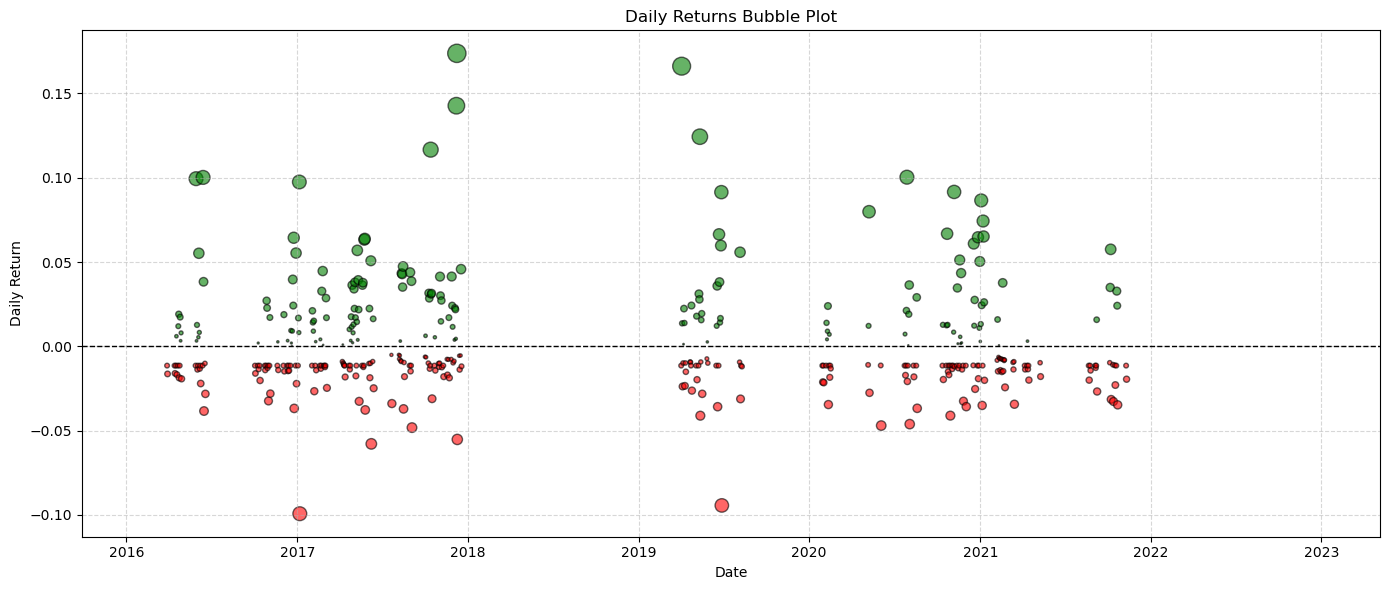

In [127]:
plot_daily_returns_bubble(df_orig, return_col='portfolio_daily_pct_returns')

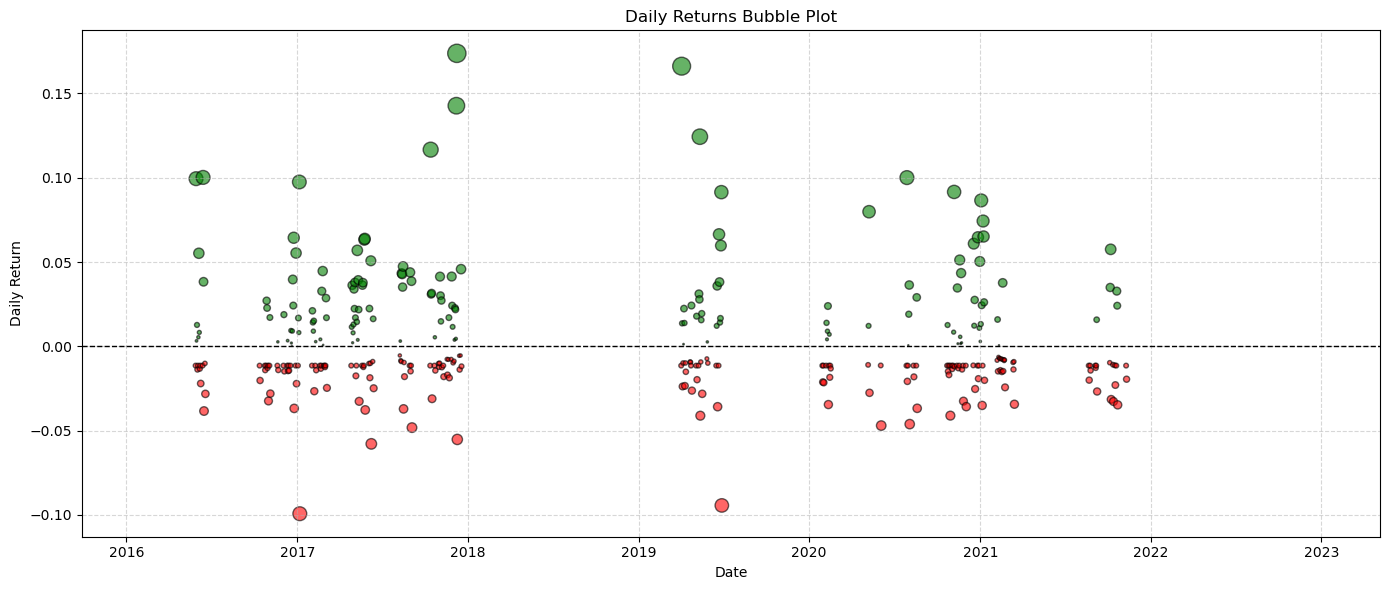

In [285]:
plot_daily_returns_bubble(df, return_col='portfolio_daily_pct_returns')

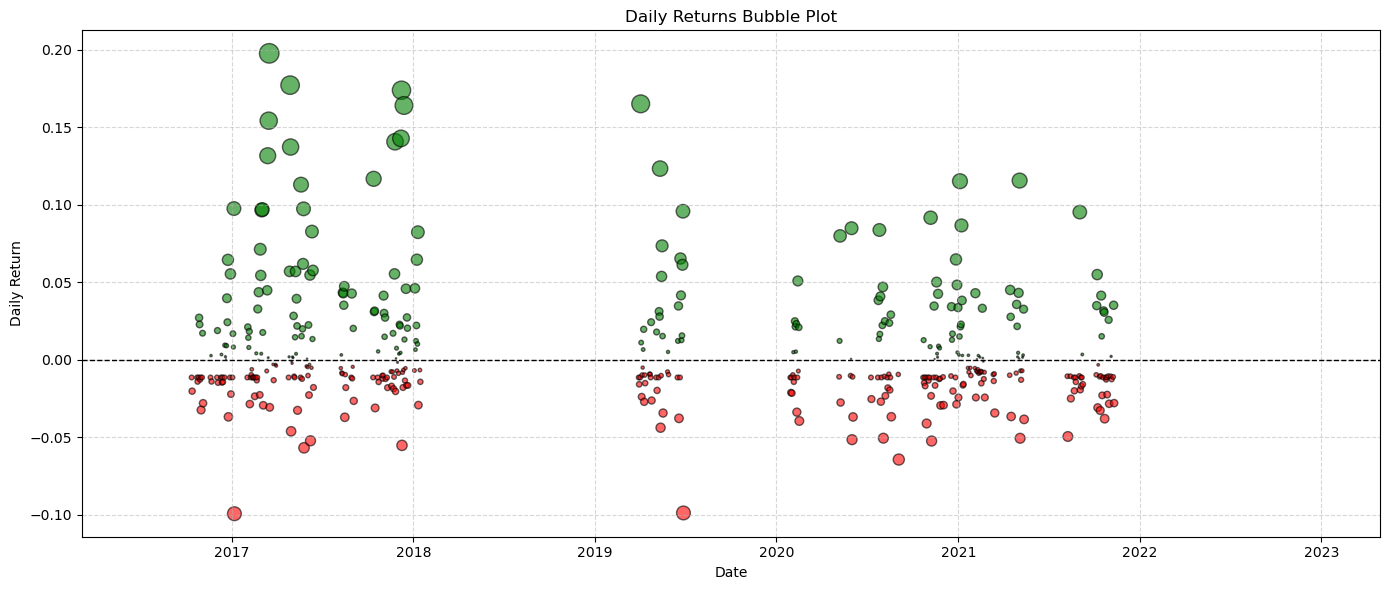

In [299]:
plot_daily_returns_bubble(df, return_col='portfolio_daily_pct_returns')

In [371]:
# Rank the returns and divide into quantiles using pd.cut
df['rank'] = df['portfolio_daily_pct_returns'].rank(method='first')
df['quantile'] = pd.cut(df['rank'], bins=5, labels=False)

In [375]:
df.groupby(['quantile']).agg({'portfolio_daily_pct_returns': ['median','mean']})

portfolio_daily_pct_returns          
                              median      mean
quantile                                      
0                                0.0 -0.006745
1                                0.0  0.000000
2                                0.0  0.000000
3                                0.0  0.000000
4                                0.0  0.009394

In [357]:
df.groupby(['daily_returns_quintile']).size()

daily_returns_quintile
(-0.1003, 0.0]    2378
(0.0, 0.174]       148
dtype: int64

In [359]:
def analyze_quantile_performance(df, return_col='portfolio_daily_pct_returns', quantiles=5):
    # Drop NaNs and copy to avoid modifying original
    df = df.dropna(subset=[return_col]).copy()

    # Rank the returns and divide into quantiles using pd.cut
    df['rank'] = df[return_col].rank(method='first')
    df['quantile'] = pd.cut(df['rank'], bins=quantiles, labels=False)

    # Group by quantile and calculate cumulative returns
    cumrets_by_quantile = (
        df.groupby('quantile')[return_col]
        .apply(lambda x: (1 + x).cumprod() - 1)
        .unstack()
        .T
    )

    # Plot cumulative returns for each quantile
    cumrets_by_quantile.plot(figsize=(12, 6), cmap='viridis')
    plt.title(f'Cumulative Returns by Quantile (n={quantiles})')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend(title='Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return cumrets_by_quantile

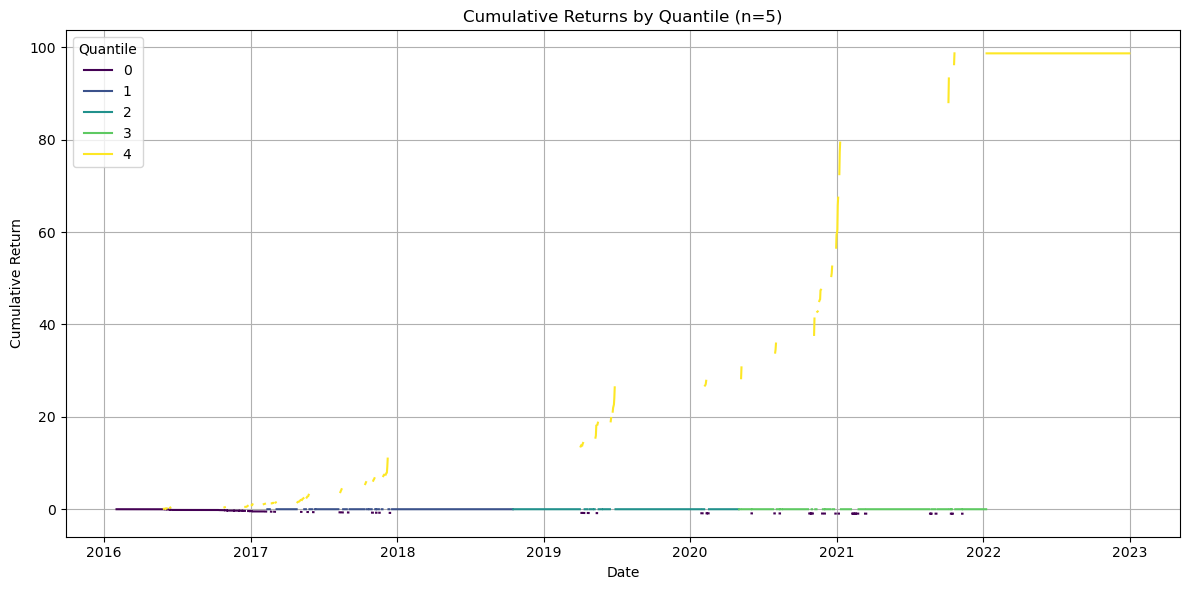

In [363]:
cum_returns = analyze_quantile_performance(df, return_col='portfolio_daily_pct_returns', quantiles=5)

In [365]:
cum_returns

quantile           0    1    2    3          4
date                                          
2016-02-01  0.000000  NaN  NaN  NaN        NaN
2016-02-02  0.000000  NaN  NaN  NaN        NaN
2016-02-03  0.000000  NaN  NaN  NaN        NaN
2016-02-04  0.000000  NaN  NaN  NaN        NaN
2016-02-05  0.000000  NaN  NaN  NaN        NaN
2016-02-06  0.000000  NaN  NaN  NaN        NaN
2016-02-07  0.000000  NaN  NaN  NaN        NaN
2016-02-08  0.000000  NaN  NaN  NaN        NaN
2016-02-09  0.000000  NaN  NaN  NaN        NaN
2016-02-10  0.000000  NaN  NaN  NaN        NaN
2016-02-11  0.000000  NaN  NaN  NaN        NaN
2016-02-12  0.000000  NaN  NaN  NaN        NaN
2016-02-13  0.000000  NaN  NaN  NaN        NaN
2016-02-14  0.000000  NaN  NaN  NaN        NaN
2016-02-15  0.000000  NaN  NaN  NaN        NaN
2016-02-16  0.000000  NaN  NaN  NaN        NaN
2016-02-17  0.000000  NaN  NaN  NaN        NaN
2016-02-18  0.000000  NaN  NaN  NaN        NaN
2016-02-19  0.000000  NaN  NaN  NaN        NaN
2016-02-20  0.000000  NaN  NaN  NaN        NaN
2016-02-21  0.000000  NaN  NaN  NaN        NaN
2016-02-22  0.000000  NaN  NaN  NaN        NaN
2016-02-23  0.000000  NaN  NaN  NaN        NaN
2016-02-24  0.000000  NaN  NaN  NaN        NaN
2016-02-25  0.000000  NaN  NaN  NaN        NaN
2016-02-26  0.000000  NaN  NaN  NaN        NaN
2016-02-27  0.000000  NaN  NaN  NaN        NaN
2016-02-28  0.000000  NaN  NaN  NaN        NaN
2016-02-29  0.000000  NaN  NaN  NaN        NaN
2016-03-01  0.000000  NaN  NaN  NaN        NaN
2016-03-02  0.000000  NaN  NaN  NaN        NaN
2016-03-03  0.000000  NaN  NaN  NaN        NaN
2016-03-04  0.000000  NaN  NaN  NaN        NaN
2016-03-05  0.000000  NaN  NaN  NaN        NaN
2016-03-06  0.000000  NaN  NaN  NaN        NaN
2016-03-07  0.000000  NaN  NaN  NaN        NaN
2016-03-08  0.000000  NaN  NaN  NaN        NaN
2016-03-09  0.000000  NaN  NaN  NaN        NaN
2016-03-10  0.000000  NaN  NaN  NaN        NaN
2016-03-11  0.000000  NaN  NaN  NaN        NaN
2016-03-12  0.000000  NaN  NaN  NaN        NaN
2016-03-13  0.000000  NaN  NaN  NaN        NaN
2016-03-14  0.000000  NaN  NaN  NaN        NaN
2016-03-15  0.000000  NaN  NaN  NaN        NaN
2016-03-16  0.000000  NaN  NaN  NaN        NaN
2016-03-17  0.000000  NaN  NaN  NaN        NaN
2016-03-18  0.000000  NaN  NaN  NaN        NaN
2016-03-19  0.000000  NaN  NaN  NaN        NaN
2016-03-20  0.000000  NaN  NaN  NaN        NaN
2016-03-21  0.000000  NaN  NaN  NaN        NaN
2016-03-22  0.000000  NaN  NaN  NaN        NaN
2016-03-23  0.000000  NaN  NaN  NaN        NaN
2016-03-24  0.000000  NaN  NaN  NaN        NaN
2016-03-25  0.000000  NaN  NaN  NaN        NaN
2016-03-26  0.000000  NaN  NaN  NaN        NaN
2016-03-27  0.000000  NaN  NaN  NaN        NaN
2016-03-28  0.000000  NaN  NaN  NaN        NaN
2016-03-29  0.000000  NaN  NaN  NaN        NaN
2016-03-30  0.000000  NaN  NaN  NaN        NaN
2016-03-31  0.000000  NaN  NaN  NaN        NaN
2016-04-01  0.000000  NaN  NaN  NaN        NaN
2016-04-02  0.000000  NaN  NaN  NaN        NaN
2016-04-03  0.000000  NaN  NaN  NaN        NaN
2016-04-04  0.000000  NaN  NaN  NaN        NaN
2016-04-05  0.000000  NaN  NaN  NaN        NaN
2016-04-06  0.000000  NaN  NaN  NaN        NaN
2016-04-07  0.000000  NaN  NaN  NaN        NaN
2016-04-08  0.000000  NaN  NaN  NaN        NaN
2016-04-09  0.000000  NaN  NaN  NaN        NaN
2016-04-10  0.000000  NaN  NaN  NaN        NaN
2016-04-11  0.000000  NaN  NaN  NaN        NaN
2016-04-12  0.000000  NaN  NaN  NaN        NaN
2016-04-13  0.000000  NaN  NaN  NaN        NaN
2016-04-14  0.000000  NaN  NaN  NaN        NaN
2016-04-15  0.000000  NaN  NaN  NaN        NaN
2016-04-16  0.000000  NaN  NaN  NaN        NaN
2016-04-17  0.000000  NaN  NaN  NaN        NaN
2016-04-18  0.000000  NaN  NaN  NaN        NaN
2016-04-19  0.000000  NaN  NaN  NaN        NaN
2016-04-20  0.000000  NaN  NaN  NaN        NaN
2016-04-21  0.000000  NaN  NaN  NaN        NaN
2016-04-22  0.000000  NaN  NaN  NaN        NaN
2016-04-23  0.000000  NaN  NaN  NaN        NaN
2016-

In [337]:
df.head()

BTC-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2016-02-01                                    357.53   
2016-02-02                                    357.53   
2016-02-03                                    357.53   
2016-02-04                                    357.53   
2016-02-05                                    357.53   

            BTC-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2016-02-01                                    449.19   
2016-02-02                                    434.01   
2016-02-03                                    432.77   
2016-02-04                                    430.03   
2016-02-05                                    418.54   

            BTC-USD_35_6_60_mavg_crossover_20_donchian_signal  \
date                                                            
2016-02-01                                                  0   
2016-02-02                                                  0   
2016-02-03                                                  0   
2016-02-04                                                  0   
2016-02-05                                                  0   

            BTC-USD_actual_position_entry_price  \
date                                              
2016-02-01                                  0.0   
2016-02-02                                  0.0   
2016-02-03                                  0.0   
2016-02-04                                  0.0   
2016-02-05                                  0.0   

            BTC-USD_actual_position_exit_price  \
date                                             
2016-02-01                                 0.0   
2016-02-02                                 0.0   
2016-02-03                                 0.0   
2016-02-04                                 0.0   
2016-02-05                                 0.0   

            BTC-USD_actual_position_notional  BTC-USD_actual_size  \
date                                                                
2016-02-01                               0.0                  0.0   
2016-02-02                               0.0                  0.0   
2016-02-03                               0.0                  0.0   
2016-02-04                               0.0                  0.0   
2016-02-05                               0.0                  0.0   

            BTC-USD_annualized_volatility_20  BTC-USD_close BTC-USD_event  \
date                                                                        
2016-02-01                          1.076237         371.33             0   
2016-02-02                          1.072386         372.93      No Event   
2016-02-03                          1.073254         368.87      No Event   
2016-02-04                          1.073469         387.99      No Event   
2016-02-05                          0.814133         384.50      No Event   

            BTC-USD_open  BTC-USD_position_volatility_adjusted_weight  \
date                                                                    
2016-02-01        367.89                                          0.0   
2016-02-02        371.33                                          0.0   
2016-02-03        372.93                                          0.0   
2016-02-04        368.87                                          0.0   
2016-02-05        387.99                                          0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_stop_loss  BTC-USD_t_1_close  \
date                                                                            
2016-02-01                          0.0                0.0             367.95   
2016-02-02                          0.0                0.0             371.33   
2016-02-03                          0.0                0.0             372.93   
2016-02-04                          0.0                0.0             368.87   
2016-02-05                          0.0

In [257]:
perf_cols = ['ma_crossover_signal_weight', 'donchian_signal_weight', 'final_weighted_additive_signal_threshold','fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio',
             'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
df_ma_crossover_donchian_channel_weight = pd.DataFrame(columns=perf_cols)
final_weighted_additive_signal_threshold = 0.1
donchian_signal_weight = 0.4

for i in np.arange(0, 1.1, 0.1):
    for j in np.arange(0, 1.1, 0.1):
        if (i+j == 1):
            print(i,j)
            ma_crossover_signal_weight = i
            donchian_signal_weight = j
            df = apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_threshold, donchian_threshold,
                                                                        final_weighted_additive_signal_threshold, 
                                                                        final_weighted_multiplicative_signal_threshold, rolling_donchian_window,
                                                                        donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                                        macro_signal_200d_weight, macro_signal_100d_weight, long_only, initial_capital, rolling_cov_window, 
                                                                        volatility_window, transaction_cost_est, passive_trade_rate,
                                                                        use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                        annual_trading_days, use_specific_start_date, signal_start_date)
            performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                        strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                        passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
            row = {'ma_crossover_signal_weight': ma_crossover_signal_weight,
                   'donchian_signal_weight': donchian_signal_weight,
                   'final_weighted_additive_signal_threshold': final_weighted_additive_signal_threshold,
                   'ticker': ticker,
                   'fast_mavg': fast_mavg,
                   'slow_mavg': slow_mavg,
                   'stepsize': mavg_stepsize,
                   'annualized_return': performance_metrics['annualized_return'],
                   'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                   'calmar_ratio': performance_metrics['calmar_ratio'],
                   'annualized_std_dev': performance_metrics['annualized_std_dev'],
                   'max_drawdown': performance_metrics['max_drawdown'],
                   'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                   'hit_rate': performance_metrics['hit_rate'],
                   't_statistic': performance_metrics['t_statistic'],
                   'p_value': performance_metrics['p_value'],
                   'trade_count': performance_metrics['trade_count']
                  }
            df_ma_crossover_donchian_channel_weight = pd.concat([df_ma_crossover_donchian_channel_weight, pd.DataFrame([row])], ignore_index=True)

0.0 1.0
0.1 0.9
0.2 0.8
0.30000000000000004 0.7000000000000001
0.4 0.6000000000000001
0.5 0.5
0.6000000000000001 0.4
0.7000000000000001 0.30000000000000004
0.8 0.2
0.9 0.1
1.0 0.0


In [259]:
df_ma_crossover_donchian_channel_weight

ma_crossover_signal_weight  donchian_signal_weight  \
0                          0.0                     1.0   
1                          0.1                     0.9   
2                          0.2                     0.8   
3                          0.3                     0.7   
4                          0.4                     0.6   
5                          0.5                     0.5   
6                          0.6                     0.4   
7                          0.7                     0.3   
8                          0.8                     0.2   
9                          0.9                     0.1   
10                         1.0                     0.0   

    final_weighted_additive_signal_threshold fast_mavg slow_mavg stepsize  \
0                                        0.1        35        60        6   
1                                        0.1        35        60        6   
2                                        0.1        35        60        6   
3                                        0.1        35        60        6   
4                                        0.1        35        60        6   
5                                        0.1        35        60        6   
6                                        0.1        35        60        6   
7                                        0.1        35        60        6   
8                                        0.1        35        60        6   
9                                        0.1        35        60        6   
10                                       0.1        35        60        6   

    annualized_return  sharpe_ratio  calmar_ratio  annualized_std_dev  \
0            0.146305      0.477863      0.402815            0.597661   
1            0.146305      0.477863      0.402815            0.597661   
2            0.146305      0.477863      0.402815            0.597661   
3            0.146305      0.477863      0.402815            0.597661   
4            0.151186      0.495479      0.437941            0.599910   
5            0.156424      0.515489      0.455014            0.601858   
6            0.162893      0.538880      0.492740            0.603753   
7            0.170795      0.568709      0.516643            0.612500   
8            0.179477      0.603403      0.616107            0.617957   
9            0.166256      0.560621      0.469547            0.613153   
10           0.151575      0.513053      0.468470            0.604703   

    max_drawdown max_drawdown_duration  hit_rate  t_statistic   p_value  \
0      -0.363205              721 days  0.064529     1.784478  0.074466   
1      -0.363205              721 days  0.064529     1.784478  0.074466   
2      -0.363205              721 days  0.064529     1.784478  0.074466   
3      -0.363205              721 days  0.064529     1.784478  0.074466   
4      -0.345220              721 days  0.064133     1.831135  0.067198   
5      -0.343778              721 days  0.063341     1.886313  0.059367   
6      -0.330587              721 days  0.062945     1.948450  0.051472   
7      -0.330587              721 days  0.060570     2.029890  0.042472   
8      -0.291308              721 days  0.058591     2.126935  0.033522   
9      -0.354078              721 days  0.057403     2.021870  0.043295   
10     -0.323552              721 days  0.056215     1.908960  0.056381   

    trade_count   ticker  
0         281.0  BTC-USD  
1         281.0  BTC-USD  
2         281.0  BTC-USD  
3         281.0  BTC-USD  
4         278.0  BTC-USD  
5         272.0  BTC-USD  
6         269.0  BTC-USD  
7         259.0  BTC-USD  
8         247.0  BTC-USD  
9         243.0  BTC-USD  
10        237.0  BTC-USD

In [273]:
perf_cols = ['ma_crossover_signal_weight', 'donchian_signal_weight', 'final_weighted_additive_signal_threshold','fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio',
             'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
df_final_weighted_additive_signal_threshold = pd.DataFrame(columns=perf_cols)
ma_crossover_signal_weight = 0.84
donchian_signal_weight = 0.2

for i in np.arange(0, 1.1, 0.1):
    print(i)
    final_weighted_additive_signal_threshold = i
    df = apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_threshold, donchian_threshold,
                                                                final_weighted_additive_signal_threshold, final_weighted_multiplicative_signal_threshold, rolling_donchian_window,
                                                                donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                                macro_signal_200d_weight, macro_signal_100d_weight, long_only, initial_capital, rolling_cov_window, 
                                                                volatility_window, transaction_cost_est, passive_trade_rate, use_coinbase_data, rolling_sharpe_window,
                                                                cash_buffer_percentage, annualized_target_volatility, annual_trading_days, use_specific_start_date, signal_start_date)
    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    row = {'ma_crossover_signal_weight': ma_crossover_signal_weight,
           'donchian_signal_weight': donchian_signal_weight,
           'final_weighted_additive_signal_threshold': final_weighted_additive_signal_threshold,
           'ticker': ticker,
           'fast_mavg': fast_mavg,
           'slow_mavg': slow_mavg,
           'stepsize': mavg_stepsize,
           'annualized_return': performance_metrics['annualized_return'],
           'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
           'calmar_ratio': performance_metrics['calmar_ratio'],
           'annualized_std_dev': performance_metrics['annualized_std_dev'],
           'max_drawdown': performance_metrics['max_drawdown'],
           'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
           'hit_rate': performance_metrics['hit_rate'],
           't_statistic': performance_metrics['t_statistic'],
           'p_value': performance_metrics['p_value'],
           'trade_count': performance_metrics['trade_count']
          }
    df_final_weighted_additive_signal_threshold = pd.concat([df_final_weighted_additive_signal_threshold, pd.DataFrame([row])], ignore_index=True)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


In [274]:
df_final_weighted_additive_signal_threshold

ma_crossover_signal_weight  donchian_signal_weight  \
0                         0.84                     0.2   
1                         0.84                     0.2   
2                         0.84                     0.2   
3                         0.84                     0.2   
4                         0.84                     0.2   
5                         0.84                     0.2   
6                         0.84                     0.2   
7                         0.84                     0.2   
8                         0.84                     0.2   
9                         0.84                     0.2   
10                        0.84                     0.2   

    final_weighted_additive_signal_threshold fast_mavg slow_mavg stepsize  \
0                                        0.0        35        60        6   
1                                        0.1        35        60        6   
2                                        0.2        35        60        6   
3                                        0.3        35        60        6   
4                                        0.4        35        60        6   
5                                        0.5        35        60        6   
6                                        0.6        35        60        6   
7                                        0.7        35        60        6   
8                                        0.8        35        60        6   
9                                        0.9        35        60        6   
10                                       1.0        35        60        6   

    annualized_return  sharpe_ratio  calmar_ratio  annualized_std_dev  \
0            0.171247      0.573099      0.554171            0.615047   
1            0.179477      0.603403      0.616107            0.617957   
2            0.160427      0.540801      0.550713            0.609436   
3            0.139218      0.465616      0.395703            0.603439   
4            0.135725      0.452245      0.392897            0.606777   
5            0.137311      0.459791      0.404972            0.612530   
6            0.119788      0.392380      0.353290            0.618610   
7            0.110052      0.354233      0.317979            0.622618   
8            0.089950      0.275196      0.226984            0.620225   
9            0.102829      0.328817      0.285677            0.625190   
10           0.128811      0.436146      0.430786            0.632390   

    max_drawdown max_drawdown_duration  hit_rate  t_statistic   p_value  \
0      -0.309015              721 days  0.058987     2.045844  0.040875   
1      -0.291308              721 days  0.058591     2.126935  0.033522   
2      -0.291308              721 days  0.057403     1.972303  0.048684   
3      -0.351826              721 days  0.056611     1.783180  0.074677   
4      -0.345447              721 days  0.055028     1.747985  0.080588   
5      -0.339064              721 days  0.053444     1.771382  0.076618   
6      -0.339064              721 days  0.051465     1.595974  0.110620   
7      -0.346097              721 days  0.050277     1.496602  0.134622   
8      -0.396282             1283 days  0.048298     1.302644  0.192815   
9      -0.359947              721 days  0.047506     1.447330  0.147929   
10     -0.299015              721 days  0.046318     1.734224  0.083000   

    trade_count   ticker  
0         252.0  BTC-USD  
1         247.0  BTC-USD  
2         243.0  BTC-USD  
3         240.0  BTC-USD  
4         237.0  BTC-USD  
5         229.0  BTC-USD  
6         224.0  BTC-USD  
7         221.0  BTC-USD  
8         213.0  BTC-USD  
9         208.0  BTC-USD  
10        200.0  BTC-USD

In [267]:
df_final_weighted_additive_signal_threshold

ma_crossover_signal_weight  donchian_signal_weight  \
0                          0.2                     0.8   
1                          0.2                     0.8   
2                          0.2                     0.8   
3                          0.2                     0.8   
4                          0.2                     0.8   
5                          0.2                     0.8   
6                          0.2                     0.8   
7                          0.2                     0.8   
8                          0.2                     0.8   
9                          0.2                     0.8   
10                         0.2                     0.8   

    final_weighted_additive_signal_threshold fast_mavg slow_mavg stepsize  \
0                                        0.0        35        60        6   
1                                        0.1        35        60        6   
2                                        0.2        35        60        6   
3                                        0.3        35        60        6   
4                                        0.4        35        60        6   
5                                        0.5        35        60        6   
6                                        0.6        35        60        6   
7                                        0.7        35        60        6   
8                                        0.8        35        60        6   
9                                        0.9        35        60        6   
10                                       1.0        35        60        6   

    annualized_return  sharpe_ratio  calmar_ratio  annualized_std_dev  \
0            0.146305      0.477863      0.402815            0.597661   
1            0.146305      0.477863      0.402815            0.597661   
2            0.146305      0.477863      0.402815            0.597661   
3            0.146305      0.477863      0.402815            0.597661   
4            0.146396      0.478194      0.403067            0.598527   
5            0.146562      0.478801      0.403524            0.599429   
6            0.153000      0.503187      0.445054            0.602320   
7            0.089816      0.271678      0.275102            0.602987   
8            0.061932      0.160410      0.194846            0.625168   
9            0.022952     -0.010415      0.052147            0.631275   
10          -0.008704     -0.172614     -0.019595            0.640242   

    max_drawdown max_drawdown_duration  hit_rate  t_statistic   p_value  \
0      -0.363205              721 days  0.064529     1.784478  0.074466   
1      -0.363205              721 days  0.064529     1.784478  0.074466   
2      -0.363205              721 days  0.064529     1.784478  0.074466   
3      -0.363205              721 days  0.064529     1.784478  0.074466   
4      -0.363205              721 days  0.064529     1.785356  0.074324   
5      -0.363205              721 days  0.064133     1.786976  0.074061   
6      -0.343778              721 days  0.062945     1.853853  0.063877   
7      -0.326484              721 days  0.056611     1.260843  0.207482   
8      -0.317852              721 days  0.049089     0.976014  0.329151   
9      -0.440136             1329 days  0.043943     0.550289  0.582170   
10     -0.444218             1329 days  0.038401     0.156738  0.875464   

    trade_count   ticker  
0         281.0  BTC-USD  
1         281.0  BTC-USD  
2         281.0  BTC-USD  
3         281.0  BTC-USD  
4         280.0  BTC-USD  
5         279.0  BTC-USD  
6         272.0  BTC-USD  
7         257.0  BTC-USD  
8         233.0  BTC-USD  
9         211.0  BTC-USD  
10        185.0  BTC-USD

In [138]:
perf_cols = ['ma_crossover_signal_weight', 'donchian_signal_weight', 'final_weighted_additive_signal_threshold','fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio',
             'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
df_final_weighted_additive_signal_threshold = pd.DataFrame(columns=perf_cols)
ma_crossover_signal_weight = 0.6
donchian_signal_weight = 0.4

for i in np.arange(0, 1, 0.1):
    print(i)
    final_weighted_additive_signal_threshold = i
    df = apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_threshold, donchian_threshold,
                                                                final_weighted_additive_signal_threshold, final_weighted_multiplicative_signal_threshold, rolling_donchian_window,
                                                                donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                                macro_signal_200d_weight, macro_signal_100d_weight, long_only, initial_capital, rolling_cov_window, 
                                                                volatility_window, transaction_cost_est, passive_trade_rate, use_coinbase_data, rolling_sharpe_window,
                                                                cash_buffer_percentage, annualized_target_volatility, annual_trading_days, use_specific_start_date, signal_start_date)
    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    row = {'ma_crossover_signal_weight': ma_crossover_signal_weight,
           'donchian_signal_weight': donchian_signal_weight,
           'final_weighted_additive_signal_threshold': final_weighted_additive_signal_threshold,
           'ticker': ticker,
           'fast_mavg': fast_mavg,
           'slow_mavg': slow_mavg,
           'stepsize': mavg_stepsize,
           'annualized_return': performance_metrics['annualized_return'],
           'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
           'calmar_ratio': performance_metrics['calmar_ratio'],
           'annualized_std_dev': performance_metrics['annualized_std_dev'],
           'max_drawdown': performance_metrics['max_drawdown'],
           'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
           'hit_rate': performance_metrics['hit_rate'],
           't_statistic': performance_metrics['t_statistic'],
           'p_value': performance_metrics['p_value'],
           'trade_count': performance_metrics['trade_count']
          }
    df_final_weighted_additive_signal_threshold = pd.concat([df_final_weighted_additive_signal_threshold, pd.DataFrame([row])], ignore_index=True)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


In [140]:
df_final_weighted_additive_signal_threshold

ma_crossover_signal_weight  donchian_signal_weight  \
0                         0.6                     0.4   
1                         0.6                     0.4   
2                         0.6                     0.4   
3                         0.6                     0.4   
4                         0.6                     0.4   
5                         0.6                     0.4   
6                         0.6                     0.4   
7                         0.6                     0.4   
8                         0.6                     0.4   
9                         0.6                     0.4   

   final_weighted_additive_signal_threshold fast_mavg slow_mavg stepsize  \
0                                       0.0        35        60        6   
1                                       0.1        35        60        6   
2                                       0.2        35        60        6   
3                                       0.3        35        60        6   
4                                       0.4        35        60        6   
5                                       0.5        35        60        6   
6                                       0.6        35        60        6   
7                                       0.7        35        60        6   
8                                       0.8        35        60        6   
9                                       0.9        35        60        6   

   annualized_return  sharpe_ratio  calmar_ratio  annualized_std_dev  \
0           0.024884     -0.242297      0.010677            0.480604   
1           0.097017      0.376741      0.029867            0.596002   
2           0.045794      0.024081      0.015835            0.501600   
3          -0.010617     -0.552019     -0.003636            0.336133   
4           0.097741      0.331831      0.061045            0.436234   
5           0.062631      0.152550      0.066032            0.455430   
6           0.018137     -0.245503      0.019122            0.506777   
7           0.031418     -0.099867      0.033124            0.432337   
8           0.007048     -0.423404      0.007431            0.465873   
9          -0.030231     -0.636384     -0.011731            0.523118   

   max_drawdown max_drawdown_duration  hit_rate  t_statistic   p_value  \
0     -2.330707             1544 days  0.013460     0.866620  0.386233   
1     -3.248273              615 days  0.015835     1.899557  0.057605   
2     -2.891992              534 days  0.013460     1.123657  0.261266   
3     -2.920018             1903 days  0.015835    -0.156682  0.875508   
4     -1.601142             1036 days  0.019002     1.599070  0.109930   
5     -0.948503              856 days  0.019794     1.323043  0.185941   
6     -0.948503             1513 days  0.015044     0.587899  0.556653   
7     -0.948503             1487 days  0.015439     0.851676  0.394475   
8     -0.948503             1620 days  0.014648     0.321664  0.747734   
9     -2.577093             1283 days  0.013856    -0.553692  0.579839   

   trade_count   ticker  
0         59.0  BTC-USD  
1         66.0  BTC-USD  
2         61.0  BTC-USD  
3         72.0  BTC-USD  
4         82.0  BTC-USD  
5         77.0  BTC-USD  
6         69.0  BTC-USD  
7         67.0  BTC-USD  
8         64.0  BTC-USD  
9         68.0  BTC-USD

In [146]:
df_ma_crossover_donchian_channel_weight

ma_crossover_signal_weight  donchian_signal_weight  \
0                         0.1                     0.9   
1                         0.2                     0.8   
2                         0.3                     0.7   
3                         0.4                     0.6   
4                         0.5                     0.5   
5                         0.6                     0.4   
6                         0.7                     0.3   
7                         0.8                     0.2   
8                         0.9                     0.1   

   final_weighted_additive_signal_threshold fast_mavg slow_mavg stepsize  \
0                                       0.1        35        60        6   
1                                       0.1        35        60        6   
2                                       0.1        35        60        6   
3                                       0.1        35        60        6   
4                                       0.1        35        60        6   
5                                       0.1        35        60        6   
6                                       0.1        35        60        6   
7                                       0.1        35        60        6   
8                                       0.1        35        60        6   

   annualized_return  sharpe_ratio  calmar_ratio  annualized_std_dev  \
0          -0.008118     -0.354719     -0.003753            0.363974   
1           0.028636     -0.054255      0.005944            0.332088   
2           0.061899      0.147775      0.011968            0.343914   
3           0.091632      0.289112      0.013644            0.394836   
4           0.056046      0.105004      0.016824            0.442845   
5           0.097017      0.376741      0.029867            0.596002   
6           0.028641     -0.165147      0.011855            0.570492   
7          -0.012328     -0.792064     -0.007133            0.486345   
8          -0.002646     -0.677944     -0.001531            0.384945   

   max_drawdown max_drawdown_duration  hit_rate  t_statistic   p_value  \
0     -2.162990             2019 days  0.030087     0.014210  0.988664   
1     -4.818010             2227 days  0.030087     0.670641  0.502511   
2     -5.171932             1106 days  0.030087     1.088042  0.276680   
3     -6.715780              773 days  0.022565     1.423478  0.154721   
4     -3.331230              374 days  0.019794     1.335751  0.181751   
5     -3.248273              615 days  0.015835     1.899557  0.057605   
6     -2.415937             1020 days  0.011481     0.889489  0.373825   
7     -1.728264             1903 days  0.008314    -0.346616  0.728909   
8     -1.728264             1903 days  0.009501    -0.001601  0.998722   

   trade_count   ticker  
0        140.0  BTC-USD  
1        144.0  BTC-USD  
2        140.0  BTC-USD  
3        108.0  BTC-USD  
4         82.0  BTC-USD  
5         66.0  BTC-USD  
6         50.0  BTC-USD  
7         39.0  BTC-USD  
8         40.0  BTC-USD

In [53]:
perf_cols = ['mavg_z_score_threshold', 'fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
            'hit_rate', 't_statistic', 'p_value', 'trade_count']
df_mavg_z_score_performance = pd.DataFrame(columns=perf_cols)

for i in np.arange(-5, 3, 0.5):
    print(i)
    mavg_z_score_threshold = i
    df = apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_threshold, donchian_threshold,
                                                                final_weighted_additive_signal_threshold, final_weighted_multiplicative_signal_threshold, rolling_donchian_window,
                                                                donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                                macro_signal_200d_weight, macro_signal_100d_weight, long_only, initial_capital, rolling_cov_window, 
                                                                volatility_window, transaction_cost_est, passive_trade_rate, use_coinbase_data, rolling_sharpe_window,
                                                                cash_buffer_percentage, annualized_target_volatility, annual_trading_days, use_specific_start_date, signal_start_date)
    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    row = {'mavg_z_score_threshold': mavg_z_score_threshold,
           'ticker': ticker,
           'fast_mavg': fast_mavg,
           'slow_mavg': slow_mavg,
           'stepsize': mavg_stepsize,
           'annualized_return': performance_metrics['annualized_return'],
           'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
           'calmar_ratio': performance_metrics['calmar_ratio'],
           'annualized_std_dev': performance_metrics['annualized_std_dev'],
           'max_drawdown': performance_metrics['max_drawdown'],
           'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
           'hit_rate': performance_metrics['hit_rate'],
           't_statistic': performance_metrics['t_statistic'],
           'p_value': performance_metrics['p_value'],
           'trade_count': performance_metrics['trade_count']
          }
    df_mavg_z_score_performance = pd.concat([df_mavg_z_score_performance, pd.DataFrame([row])], ignore_index=True)

-5.0
-4.5
-4.0
-3.5
-3.0
-2.5
-2.0
-1.5
-1.0
-0.5
0.0
0.5
1.0
1.5
2.0
2.5


In [55]:
df_mavg_z_score_performance

mavg_z_score_threshold fast_mavg slow_mavg stepsize  annualized_return  \
0                     -5.0        35        60        6           0.008856   
1                     -4.5        35        60        6           0.008856   
2                     -4.0        35        60        6           0.008856   
3                     -3.5        35        60        6           0.008856   
4                     -3.0        35        60        6           0.008856   
5                     -2.5        35        60        6           0.005976   
6                     -2.0        35        60        6           0.008856   
7                     -1.5        35        60        6           0.005555   
8                     -1.0        35        60        6          -0.001166   
9                     -0.5        35        60        6           0.013688   
10                     0.0        35        60        6           0.047490   
11                     0.5        35        60        6           0.022266   
12                     1.0        35        60        6           0.017633   
13                     1.5        35        60        6           0.013718   
14                     2.0        35        60        6           0.008468   
15                     2.5        35        60        6          -0.008597   

    sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0      -0.492166      0.004953            0.891682     -1.787963   
1      -0.492166      0.004953            0.891682     -1.787963   
2      -0.492166      0.004953            0.891682     -1.787963   
3      -0.492166      0.004953            0.891682     -1.787963   
4      -0.492166      0.004953            0.891682     -1.787963   
5      -0.528383      0.003343            0.871175     -1.787963   
6      -0.492166      0.004953            0.891682     -1.787963   
7      -0.533138      0.002260            0.846278     -2.458327   
8      -0.605998     -0.000493            0.829142     -2.363588   
9      -0.400813      0.004265            0.820563     -3.209614   
10      0.023250      0.050068            0.719799     -0.948503   
11     -0.227176      0.012635            0.697595     -1.762274   
12     -0.302791      0.018590            0.691861     -0.948503   
13     -0.214365      0.002126            0.686186     -6.452060   
14     -0.389935      0.002737            0.524569     -3.094370   
15     -1.024605          -inf            0.389492      0.000000   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              1075 days  0.003167     0.398120  0.690576         16.0   
1              1075 days  0.003167     0.398120  0.690576         16.0   
2              1075 days  0.003167     0.398120  0.690576         16.0   
3              1075 days  0.003167     0.398120  0.690576         16.0   
4              1075 days  0.003167     0.398120  0.690576         16.0   
5              1075 days  0.003167     0.298705  0.765190         17.0   
6              1075 days  0.003167     0.398120  0.690576         16.0   
7              1075 days  0.003563     0.284097  0.776360         18.0   
8              1367 days  0.003563     0.055664  0.955614         19.0   
9              1075 days  0.003959     0.543312  0.586963         21.0   
10              881 days  0.009105     1.344209  0.179002         35.0   
11              967 days  0.007522     0.715119  0.474602         33.0   
12             1367 days  0.008314     0.619230  0.535821         35.0   
13             1283 days  0.011481     0.446412  0.655338         47.0   
14             1331 days  0.009897     0.359332  0.719377         42.0   
15             2525 days  0.004751    -0.343683  0.731114         20.0   

     ticker  
0   BTC-USD  
1   BTC-USD  
2   BTC-USD  
3   BTC-USD  
4   BTC-USD  
5   BTC-USD  
6   BTC-USD  
7   BTC-USD  
8   BTC-USD  
9   BTC-USD  
10  BTC-USD  
11  BTC-USD  
12  BTC-USD  
13  BTC-USD  
14  BTC-USD  
15  BTC-USD

In [81]:
perf_cols = ['donchian_threshold', 'fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
             'hit_rate', 't_statistic', 'p_value', 'trade_count']
df_donchian_performance = pd.DataFrame(columns=perf_cols)

for i in np.arange(0, 2, 0.1):
    print(i)
    donchian_threshold = i
    df = apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_threshold, donchian_threshold,
                                                                final_weighted_additive_signal_threshold, final_weighted_multiplicative_signal_threshold, rolling_donchian_window,
                                                                donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                                macro_signal_200d_weight, macro_signal_100d_weight, long_only, initial_capital, rolling_cov_window, 
                                                                volatility_window, transaction_cost_est, passive_trade_rate, use_coinbase_data, rolling_sharpe_window,
                                                                cash_buffer_percentage, annualized_target_volatility, annual_trading_days, use_specific_start_date, signal_start_date)
    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    row = {'donchian_threshold': donchian_threshold,
           'ticker': ticker,
           'fast_mavg': fast_mavg,
           'slow_mavg': slow_mavg,
           'stepsize': mavg_stepsize,
           'annualized_return': performance_metrics['annualized_return'],
           'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
           'calmar_ratio': performance_metrics['calmar_ratio'],
           'annualized_std_dev': performance_metrics['annualized_std_dev'],
           'max_drawdown': performance_metrics['max_drawdown'],
           'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
           'hit_rate': performance_metrics['hit_rate'],
           't_statistic': performance_metrics['t_statistic'],
           'p_value': performance_metrics['p_value'],
           'trade_count': performance_metrics['trade_count']
          }
    df_donchian_performance = pd.concat([df_donchian_performance, pd.DataFrame([row])], ignore_index=True)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001


In [83]:
df_donchian_performance

donchian_threshold fast_mavg slow_mavg stepsize  annualized_return  \
0                  0.0        35        60        6           0.007343   
1                  0.1        35        60        6          -0.063301   
2                  0.2        35        60        6          -0.100537   
3                  0.3        35        60        6          -0.137710   
4                  0.4        35        60        6           0.012211   
5                  0.5        35        60        6           0.347640   
6                  0.6        35        60        6           0.025911   
7                  0.7        35        60        6          -0.070007   
8                  0.8        35        60        6          -0.074324   
9                  0.9        35        60        6          -0.047137   
10                 1.0        35        60        6          -0.021050   
11                 1.1        35        60        6          -0.026767   
12                 1.2        35        60        6          -0.021822   
13                 1.3        35        60        6          -0.016208   
14                 1.4        35        60        6          -0.011637   
15                 1.5        35        60        6          -0.007359   
16                 1.6        35        60        6          -0.007359   
17                 1.7        35        60        6          -0.007359   
18                 1.8        35        60        6          -0.007359   
19                 1.9        35        60        6          -0.004068   

    sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0      -0.233411      0.001459            0.280110     -5.033991   
1      -0.806735     -0.011118            0.372007     -5.693288   
2      -1.155991          -inf            0.370848      0.000000   
3      -1.462166          -inf            0.369480      0.000000   
4      -0.112727      0.000053            0.474353   -231.798801   
5       1.169668      0.170878            0.541815     -2.034440   
6      -0.042104      0.008096            0.596312     -3.200690   
7      -0.903089          -inf            0.528453      0.000000   
8      -1.359999          -inf            0.513133      0.000000   
9      -1.368429          -inf            0.531485      0.000000   
10     -1.039861     -0.005222            0.660112     -4.031073   
11     -2.742094          -inf            0.025831      0.000000   
12     -4.218013          -inf            0.030913      0.000000   
13     -4.844850          -inf            0.035604      0.000000   
14     -5.080714          -inf            0.012321      0.000000   
15     -6.243426          -inf            0.015906      0.000000   
16     -6.243426          -inf            0.015906      0.000000   
17     -6.243426          -inf            0.015906      0.000000   
18     -6.243426          -inf            0.015906      0.000000   
19     -8.016605          -inf            0.019481      0.000000   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              1628 days  0.032067     0.316496  0.751653        144.0   
1              2356 days  0.035629    -1.143091  0.253109        162.0   
2              2525 days  0.037213    -2.030202  0.042441        171.0   
3              2525 days  0.042359    -2.851993  0.004380        210.0   
4               706 days  0.065321     0.405890  0.684858        307.0   
5               721 days  0.089074     3.620560  0.000300        405.0   
6              1088 days  0.033254     0.598156  0.549789        210.0   
7              2525 days  0.017419    -1.356919  0.174928        125.0   
8              2525 days  0.007126    -2.149078  0.031723         65.0   
9              2525 days  0.003959    -1.747569  0.080660         34.0   
10             1849 days  0.002771    -0.774907  0.438467         22.0   
11             2525 days  0.001979    -2.554687  0.010687         15.0   
12             2525 days  0.001188    -3.439841  0.000592 

<Axes: xlabel='date'>

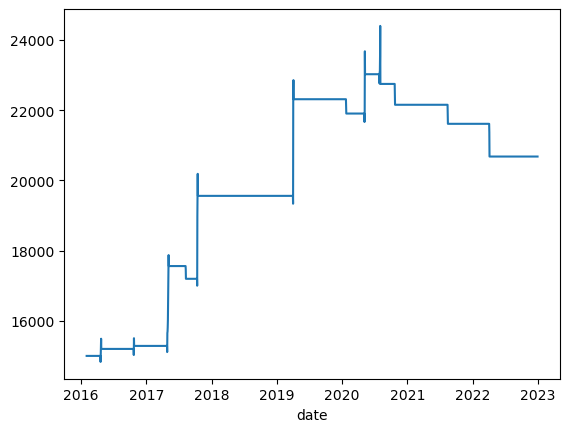

In [497]:
df['total_portfolio_value'].plot()

In [32]:
df_trend.head()

BTC-USD_close  BTC-USD_open  BTC-USD_pct_returns  BTC-USD_35_mavg  \
date                                                                            
2016-01-11         449.19        449.99            -0.001778       443.474492   
2016-01-12         434.01        449.26            -0.033794       442.415178   
2016-01-13         432.77        434.01            -0.002857       441.393247   
2016-01-14         430.03        432.70            -0.006331       440.247046   
2016-01-15         357.53        430.04            -0.168593       432.265142   

            BTC-USD_35_mavg_slope  BTC-USD_40_mavg  BTC-USD_40_mavg_slope  \
date                                                                        
2016-01-11               0.781449       443.315818               0.765582   
2016-01-12               0.688889       442.309867               0.678312   
2016-01-13               0.714191       441.336363               0.707596   
2016-01-14               0.610480       440.240943               0.609096   
2016-01-15              -0.169781       432.595264              -0.137612   

            BTC-USD_45_mavg  BTC-USD_45_mavg_slope  BTC-USD_50_mavg  \
date                                                                  
2016-01-11       443.191869               0.753187       443.092417   
2016-01-12       442.226203               0.669909       442.158208   
2016-01-13       441.289473               0.702204       441.250326   
2016-01-14       440.232842               0.607683       440.224257   
2016-01-15       432.843845              -0.113415       433.037466   

            BTC-USD_50_mavg_slope  BTC-USD_55_mavg  BTC-USD_55_mavg_slope  \
date                                                                        
2016-01-11               0.743242       443.010877               0.735088   
2016-01-12               0.663081       442.101896               0.657426   
2016-01-13               0.697727       441.217231               0.693958   
2016-01-14               0.606340       440.215848               0.605101   
2016-01-15              -0.094583       433.192373              -0.079528   

            BTC-USD_60_mavg  BTC-USD_60_mavg_slope  BTC-USD_ribbon_thickness  \
date                                                                           
2016-01-11       442.942824               0.728282                  0.506441   
2016-01-12       442.054515               0.652668                  0.531669   
2016-01-13       441.188931               0.690746                  0.360663   
2016-01-14       440.207892               0.603974                  0.204316   
2016-01-15       433.319027              -0.067227                  0.039154   

            BTC-USD_trend_signal  BTC-USD_trend_strategy_returns_35_6_60  \
date                                                                       
2016-01-11                   1.0                               -0.001778   
2016-01-12                   1.0                               -0.033794   
2016-01-13                   1.0                               -0.002857   
2016-01-14                   1.0                               -0.006331   
2016-01-15                   1.0                               -0.168593   

            BTC-USD_trend_strategy_trades_35_6_60  BTC-USD_trend_slope_signal  \
date                                                                            
2016-01-11                                    0.0                         0.0   
2016-01-12                                    0.0                         1.0   
2016-01-13                                    0.0                         1.0   
2016-01-14                                    0.0                         1.0   
2016-01-15                                    0.0                         1.0   

            BTC-USD_trend_slope_strategy_returns  \
date                                               
2016-01-11                             -0.000000   
2016-01-12                             -0.033794

In [87]:
np.linspace(slow_mavg, fast_mavg, mavg_stepsize)

array([60., 55., 50., 45., 40., 35.])

In [101]:
from scipy.stats import linregress

def calc_ribbon_slope(row, ticker, fast_mavg, slow_mavg, mavg_stepsize):
    x = np.linspace(slow_mavg, fast_mavg, mavg_stepsize)
    y = row.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

mavg_cols = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]

df_trend[f'{ticker}_mavg_ribbon_slope'] = df_trend[mavg_cols].apply(
    calc_ribbon_slope, 
    axis=1, 
    args=(ticker, fast_mavg, slow_mavg, mavg_stepsize)
)
df_trend[f'{ticker}_mavg_ribbon_z_score'] = (df_trend[f'{ticker}_mavg_ribbon_slope'] - df_trend[f'{ticker}_mavg_ribbon_slope'].rolling(window=100).mean())/df_trend[f'{ticker}_mavg_ribbon_slope'].rolling(window=100).std()

<Axes: xlabel='date'>

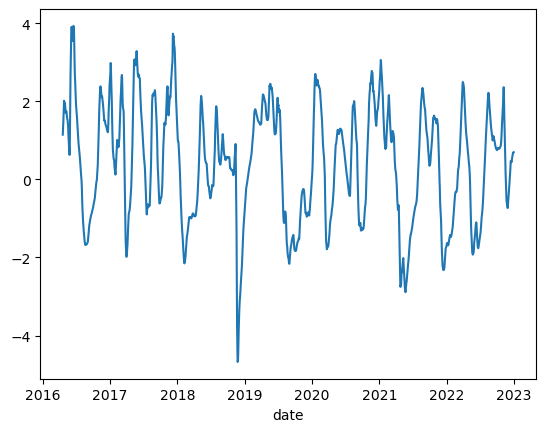

In [103]:
df_trend[f'{ticker}_mavg_ribbon_z_score'].plot()

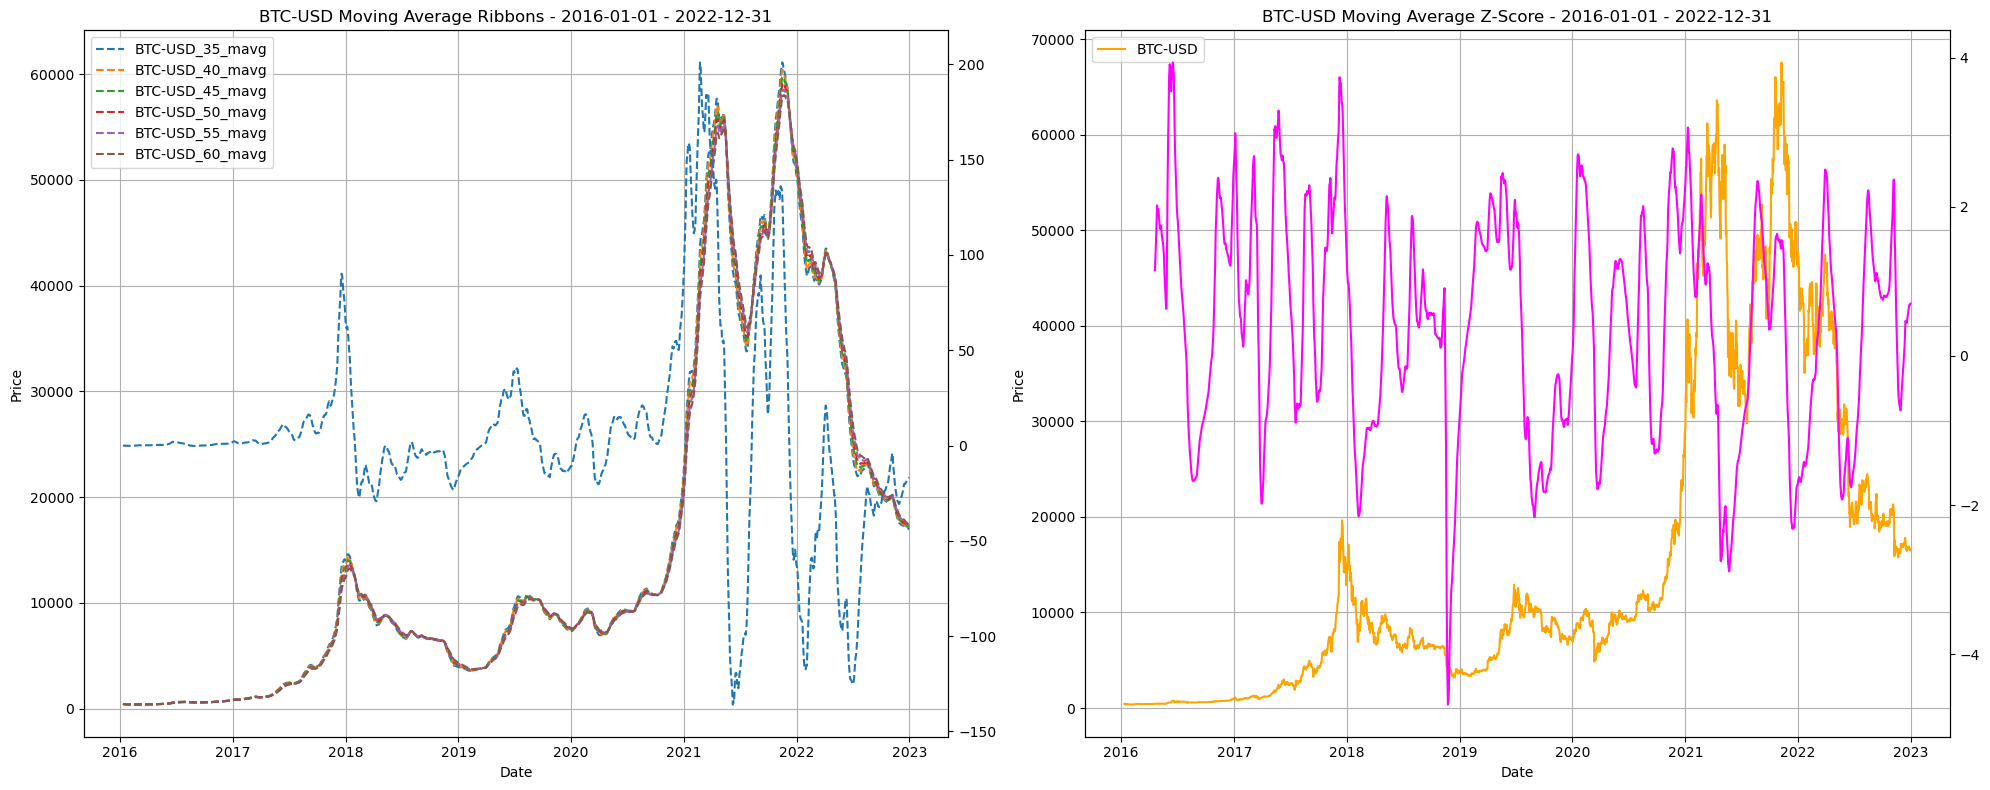

In [117]:
fig = plt.figure(figsize=(20,8))
layout = (1,2)
trend_ax = plt.subplot2grid(layout, (0,0))
trend_slope_ax = plt.subplot2grid(layout, (0,1))

for mavg in mavg_cols:
    _ = trend_ax.plot(df_trend.index, df_trend[mavg], label=mavg, linestyle='--')

trend_ax2 = trend_ax.twinx()
_ = trend_ax2.plot(df_trend.index, df_trend[f'{ticker}_mavg_ribbon_slope'], label='Ribbon Slope', linestyle='--')

trend_slope_ax2 = trend_slope_ax.twinx()
_ = trend_slope_ax.plot(df_trend.index, df_trend[f'{ticker}_close'], label=ticker, linestyle='-', color='orange')
_ = trend_slope_ax2.plot(df_trend.index, df_trend[f'{ticker}_mavg_ribbon_z_score'], label='Ribbon Slope Z-Score', linestyle='-', color='magenta')

_ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
_ = trend_ax.set_ylabel('Price')
_ = trend_ax.set_xlabel('Date')
_ = trend_ax.legend(loc='upper left')
_ = trend_ax.grid()

_ = trend_slope_ax.set_title(f'{ticker} Moving Average Z-Score - {start_date} - {end_date}')
_ = trend_slope_ax.set_ylabel('Price')
_ = trend_slope_ax.set_xlabel('Date')
_ = trend_slope_ax.legend(loc='upper left')
_ = trend_slope_ax.grid()

plt.tight_layout()

In [511]:
df_trend_portfolio = get_trend_donchian_signal_for_portfolio_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, donchian_signal_weight,
                                                                   ma_crossover_signal_weight, ribbon_width_signal_weight, macro_signal_200d_weight, macro_signal_100d_weight,
                                                                   price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=True)

In [512]:
df_trend_portfolio.head()

BTC-USD_close  BTC-USD_open  \
date                                      
2016-01-11         449.19        449.99   
2016-01-12         434.01        449.26   
2016-01-13         432.77        434.01   
2016-01-14         430.03        432.70   
2016-01-15         357.53        430.04   

            BTC-USD_35_6_60_mavg_crossover_20_donchian_signal  \
date                                                            
2016-01-11                                                  0   
2016-01-12                                                  0   
2016-01-13                                                  0   
2016-01-14                                                  0   
2016-01-15                                                  0   

            BTC-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2016-01-11                                       NaN   
2016-01-12                                       NaN   
2016-01-13                                       NaN   
2016-01-14                                       NaN   
2016-01-15                                       NaN   

            BTC-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2016-01-11                                       NaN   
2016-01-12                                       NaN   
2016-01-13                                       NaN   
2016-01-14                                       NaN   
2016-01-15                                       NaN   

            BTC-USD_ribbon_thickness_mod2_signal  \
date                                               
2016-01-11                                     0   
2016-01-12                                     0   
2016-01-13                                     0   
2016-01-14                                     0   
2016-01-15                                     0   

            BTC-USD_final_weighted_signal  ETH-USD_close  ETH-USD_open  \
date                                                                     
2016-01-11                            0.2            NaN           NaN   
2016-01-12                            0.2            NaN           NaN   
2016-01-13                            0.0            NaN           NaN   
2016-01-14                            0.0            NaN           NaN   
2016-01-15                            0.0            NaN           NaN   

            ETH-USD_35_6_60_mavg_crossover_20_donchian_signal  \
date                                                            
2016-01-11                                                NaN   
2016-01-12                                                NaN   
2016-01-13                                                NaN   
2016-01-14                                                NaN   
2016-01-15                                                NaN   

            ETH-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2016-01-11                                       NaN   
2016-01-12                                       NaN   
2016-01-13                                       NaN   
2016-01-14                                       NaN   
2016-01-15                                       NaN   

            ETH-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2016-01-11                                       NaN   
2016-01-12                                       NaN   
2016-01-13                                       NaN   
2016-01-14                                       NaN   
2016-01-15                                       NaN   

            ETH-USD_ribbon_thickness_mod2_signal  \
date                                               
2016-01-11                                   NaN   
2016-01-12                                   NaN   
2016-01-13                                   NaN   
2016-01-14                                   NaN   
2016-01-15                    

<Axes: xlabel='date'>

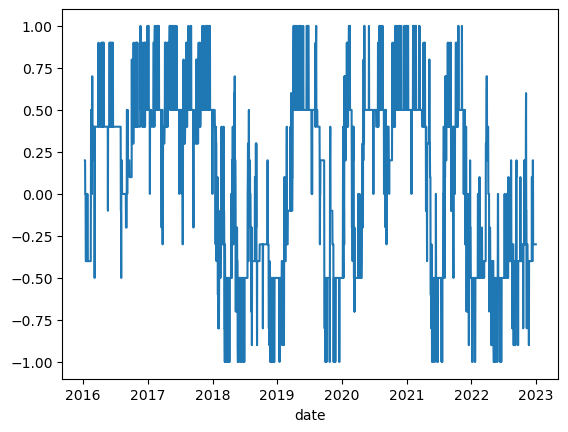

In [513]:
df_trend_portfolio['BTC-USD_final_weighted_signal'].plot()

In [494]:
df.head()

BTC-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2016-07-02                                     604.5   
2016-07-03                                     604.5   
2016-07-04                                     604.5   
2016-07-05                                     604.5   
2016-07-06                                     604.5   

            BTC-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2016-07-02                                    769.76   
2016-07-03                                    769.76   
2016-07-04                                    769.76   
2016-07-05                                    769.76   
2016-07-06                                    769.76   

            BTC-USD_35_6_60_mavg_crossover_20_donchian_signal  \
date                                                            
2016-07-02                                                  0   
2016-07-03                                                  0   
2016-07-04                                                  0   
2016-07-05                                                  0   
2016-07-06                                                  0   

            BTC-USD_actual_position_entry_price  \
date                                              
2016-07-02                                  0.0   
2016-07-03                                  0.0   
2016-07-04                                  0.0   
2016-07-05                                  0.0   
2016-07-06                                  0.0   

            BTC-USD_actual_position_exit_price  \
date                                             
2016-07-02                                 0.0   
2016-07-03                                 0.0   
2016-07-04                                 0.0   
2016-07-05                                 0.0   
2016-07-06                                 0.0   

            BTC-USD_actual_position_notional  BTC-USD_actual_size  \
date                                                                
2016-07-02                               0.0                  0.0   
2016-07-03                               0.0                  0.0   
2016-07-04                               0.0                  0.0   
2016-07-05                               0.0                  0.0   
2016-07-06                               0.0                  0.0   

            BTC-USD_annualized_volatility_20  BTC-USD_close BTC-USD_event  \
date                                                                        
2016-07-02                          1.048549         704.95             0   
2016-07-03                          0.949507         663.55      No Event   
2016-07-04                          0.968061         681.98      No Event   
2016-07-05                          0.967378         669.87      No Event   
2016-07-06                          0.966506         678.79      No Event   

            BTC-USD_open  BTC-USD_position_volatility_adjusted_weight  \
date                                                                    
2016-07-02        678.09                                          0.0   
2016-07-03        705.25                                          0.0   
2016-07-04        664.09                                          0.0   
2016-07-05        681.98                                          0.0   
2016-07-06        669.75                                          0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_stop_loss  BTC-USD_t_1_close  \
date                                                                            
2016-07-02                          0.0                0.0             678.19   
2016-07-03                          0.0                0.0             704.95   
2016-07-04                          0.0                0.0             663.55   
2016-07-05                          0.0                0.0             681.98   
2016-07-06                          0.0

In [396]:
# ticker_list = ['BTC-USD']
performance_metrics

{'annualized_return': -0.02898510981159752,
 'annualized_sharpe_ratio': -0.9432694225759116,
 'calmar_ratio': -0.0018736821550051222,
 'annualized_std_dev': 0.45147223926496366,
 'max_drawdown': -15.469598050112337,
 'max_drawdown_duration': Timedelta('450 days 00:00:00'),
 'hit_rate': 0.00998003992015968,
 't_statistic': -0.3871411848457737,
 'p_value': 0.6988164153984768,
 'trade_count': 14.0}

In [404]:
# ticker_list = ['BTC-USD','ETH-USD']
performance_metrics

{'annualized_return': 0.037476941827179866,
 'annualized_sharpe_ratio': -0.03189775920765597,
 'calmar_ratio': 0.022837259849232797,
 'annualized_std_dev': 0.5295000670089354,
 'max_drawdown': -1.6410437186683269,
 'max_drawdown_duration': Timedelta('436 days 00:00:00'),
 'hit_rate': 0.021956087824351298,
 't_statistic': 0.4087658114064141,
 'p_value': 0.6828865491921722,
 'trade_count': 33.0}

In [412]:
# ticker_list = ['BTC-USD','ETH-USD','SOL-USD']
performance_metrics

{'annualized_return': 0.12043033448268203,
 'annualized_sharpe_ratio': 0.6151175316920633,
 'calmar_ratio': 0.38101101615350386,
 'annualized_std_dev': 0.3943163517987241,
 'max_drawdown': -0.3160809776538387,
 'max_drawdown_duration': Timedelta('436 days 00:00:00'),
 'hit_rate': 0.03592814371257485,
 't_statistic': 1.2121083453671042,
 'p_value': 0.22604336415153553,
 'trade_count': 53.0}

In [421]:
# ticker_list = ['BTC-USD','ETH-USD','SOL-USD','DOGE-USD']
performance_metrics

{'annualized_return': 0.4050957365711392,
 'annualized_sharpe_ratio': 1.0689715015280914,
 'calmar_ratio': 1.2816201075370832,
 'annualized_std_dev': 1.0191899923007064,
 'max_drawdown': -0.3160809776538387,
 'max_drawdown_duration': Timedelta('373 days 00:00:00'),
 'hit_rate': 0.041916167664670656,
 't_statistic': 1.4362969547306796,
 'p_value': 0.1515432230033698,
 'trade_count': 59.0}

In [428]:
# ticker_list = ['BTC-USD','ETH-USD','SOL-USD','DOGE-USD','LTC-USD']
performance_metrics

{'annualized_return': 0.39735015923615835,
 'annualized_sharpe_ratio': 1.0414380725010512,
 'calmar_ratio': 1.2568551505839562,
 'annualized_std_dev': 0.9502211910228792,
 'max_drawdown': -0.31614634275997733,
 'max_drawdown_duration': Timedelta('373 days 00:00:00'),
 'hit_rate': 0.04590818363273453,
 't_statistic': 1.4016377074157043,
 'p_value': 0.16164389611016788,
 'trade_count': 75.0}

In [147]:
perf.calculate_sharpe_ratio(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions', include_transaction_costs_and_fees=False,
                           passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

1.2098798289061523

In [149]:
def calculate_negative_sharpe(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions', include_transaction_costs_and_fees=False,
                              passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001):
    sharpe = perf.calculate_sharpe_ratio(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions', include_transaction_costs_and_fees=False,
                                         passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    return -sharpe

In [451]:
def optimize_weights(weights):

    final_weighted_additive_signal_threshold = 0.0
    final_weighted_multiplicative_signal_threshold = 0.0
    mavg_z_score_threshold = 2.5#weights[0]
    donchian_threshold = weights[0]#0.7
    donchian_signal_weight = 0.5
    ma_crossover_signal_weight = 0.3
    ribbon_width_signal_weight = 0.0
    macro_signal_200d_weight = 0.0
    macro_signal_100d_weight = 0.0
    start_date = pd.to_datetime('2016-01-01').date()
    end_date = pd.to_datetime('2022-12-31').date()
    ticker_list = ['BTC-USD']#,'ETH-USD']#,'SOL-USD','DOGE-USD','LTC-USD']
    fast_mavg = 35
    slow_mavg = 60
    mavg_stepsize = 6
    rolling_donchian_window = 20
    long_only = True
    use_coinbase_data = True
    volatility_window = 20
    annual_trading_days = 365
    rolling_cov_window = 20
    annualized_target_volatility = 0.70
    use_specific_start_date = False
    signal_start_date = None
    initial_capital = 15000
    cash_buffer_percentage = 0.10
    transaction_cost_est = 0.001#0.0025
    passive_trade_rate = 0.05
    rolling_sharpe_window = 50
    price_or_returns_calc = 'price'
    ticker = ticker_list[0]
    df = apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_threshold, donchian_threshold, final_weighted_additive_signal_threshold, 
                                                                final_weighted_multiplicative_signal_threshold, rolling_donchian_window,
                                                                donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                                macro_signal_200d_weight, macro_signal_100d_weight, long_only, initial_capital, rolling_cov_window, 
                                                                volatility_window, transaction_cost_est, passive_trade_rate,
                                                                use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                annual_trading_days, use_specific_start_date, signal_start_date)
    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    sharpe = -performance_metrics['annualized_sharpe_ratio']

    return sharpe

In [324]:
## Through 2022-12-31
optimize_weights(weights=[0.5, 0.5, 0.5])

-0.12209316789123403

In [255]:
## Through 2022-12-31
optimize_weights(weights=[0.5, 0.2, 0.1, 0.1, 0.1])

-1.4242789663861402

In [259]:
## Through 2023-12-31
optimize_weights(weights=[0.5, 0.2, 0.1, 0.1, 0.1])

-1.1278338655681694

In [263]:
## Through 2024-12-31
optimize_weights(weights=[0.5, 0.2, 0.1, 0.1, 0.1])

-1.0491793988309155

In [453]:
from scipy.optimize import minimize

# Initial weights (start with Donchian dominant)
mavg_z_score_init_weights = np.array([0.0]) 

# Constraints: weights sum to 1
mavg_z_score_constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds for each weight (Donchian dominant, Ribbon Width small)
mavg_z_score_bounds = [(0.0, 5.0)]

In [421]:
mavg_z_score_threshold_result = minimize(optimize_weights, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)

In [423]:
mavg_z_score_threshold_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.30279055657174625
       x: [ 1.000e+00]
     nit: 2
     jac: [ 0.000e+00]
    nfev: 4
    njev: 2

In [455]:
from scipy.optimize import minimize

# Initial weights (start with Donchian dominant)
donchian_channel_init_weights = np.array([0.0]) 

# Constraints: weights sum to 1
donchian_channel_constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds for each weight (Donchian dominant, Ribbon Width small)
donchian_channel_bounds = [(0.0, 5.0)]

In [457]:
donchian_channel_threshold_result = minimize(optimize_weights, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)

In [458]:
donchian_channel_threshold_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.0398614458077273
       x: [ 1.000e+00]
     nit: 2
     jac: [ 0.000e+00]
    nfev: 4
    njev: 2

In [269]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.025261471625112032
       x: [ 3.333e-01  3.333e-01  3.333e-01]
     nit: 1
     jac: [ 0.000e+00  0.000e+00  0.000e+00]
    nfev: 5
    njev: 1

In [265]:
weights=[1, 0, 0, 0, 0]
donchian_signal_weight = weights[0]
ma_crossover_signal_weight = weights[1]
ribbon_width_signal_weight = weights[2]
macro_signal_200d_weight = weights[3]
macro_signal_100d_weight = weights[4]

In [267]:
df_donchian_perf = apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                                                          donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                                          macro_signal_200d_weight, macro_signal_100d_weight, 
                                                                          long_only, initial_capital, rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                          use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                          annual_trading_days, use_specific_start_date, signal_start_date)

In [268]:
weights=[0, 1, 0, 0, 0]
donchian_signal_weight = weights[0]
ma_crossover_signal_weight = weights[1]
ribbon_width_signal_weight = weights[2]
macro_signal_200d_weight = weights[3]
macro_signal_100d_weight = weights[4]

In [271]:
df_mavg_crossover_perf = apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                                                          donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                                          macro_signal_200d_weight, macro_signal_100d_weight, 
                                                                          long_only, initial_capital, rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                          use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                          annual_trading_days, use_specific_start_date, signal_start_date)

In [272]:
weights=[0, 0, 1, 0, 0]
donchian_signal_weight = weights[0]
ma_crossover_signal_weight = weights[1]
ribbon_width_signal_weight = weights[2]
macro_signal_200d_weight = weights[3]
macro_signal_100d_weight = weights[4]

In [275]:
df_mavg_ribbon_width_perf = apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                                                          donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                                          macro_signal_200d_weight, macro_signal_100d_weight, 
                                                                          long_only, initial_capital, rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                          use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                          annual_trading_days, use_specific_start_date, signal_start_date)

In [277]:
weights=[0, 0, 0, 1, 0]
donchian_signal_weight = weights[0]
ma_crossover_signal_weight = weights[1]
ribbon_width_signal_weight = weights[2]
macro_signal_200d_weight = weights[3]
macro_signal_100d_weight = weights[4]

In [279]:
df_macro_signal_200d_perf = apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                                                          donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                                          macro_signal_200d_weight, macro_signal_100d_weight, 
                                                                          long_only, initial_capital, rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                          use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                          annual_trading_days, use_specific_start_date, signal_start_date)

In [280]:
weights=[0, 0, 0, 0, 1]
donchian_signal_weight = weights[0]
ma_crossover_signal_weight = weights[1]
ribbon_width_signal_weight = weights[2]
macro_signal_200d_weight = weights[3]
macro_signal_100d_weight = weights[4]

In [281]:
df_macro_signal_100d_perf = apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                                                          donchian_signal_weight, ma_crossover_signal_weight, ribbon_width_signal_weight,
                                                                          macro_signal_200d_weight, macro_signal_100d_weight, 
                                                                          long_only, initial_capital, rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                          use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                          annual_trading_days, use_specific_start_date, signal_start_date)

In [285]:
df_returns = df_donchian_perf[['portfolio_daily_pct_returns']].rename(columns={'portfolio_daily_pct_returns': 'donchian_daily_returns'})
df_returns = (pd.merge(df_returns, df_mavg_crossover_perf['portfolio_daily_pct_returns'], left_index=True, right_index=True, how='left')
              .rename(columns={'portfolio_daily_pct_returns': 'mavg_crossover_daily_returns'}))
df_returns = (pd.merge(df_returns, df_mavg_ribbon_width_perf['portfolio_daily_pct_returns'], left_index=True, right_index=True, how='left')
              .rename(columns={'portfolio_daily_pct_returns': 'ribbon_width_daily_returns'}))
df_returns = (pd.merge(df_returns, df_macro_signal_200d_perf['portfolio_daily_pct_returns'], left_index=True, right_index=True, how='left')
              .rename(columns={'portfolio_daily_pct_returns': 'macro_signal_200d_daily_returns'}))
df_returns = (pd.merge(df_returns, df_macro_signal_100d_perf['portfolio_daily_pct_returns'], left_index=True, right_index=True, how='left')
              .rename(columns={'portfolio_daily_pct_returns': 'macro_signal_100d_daily_returns'}))

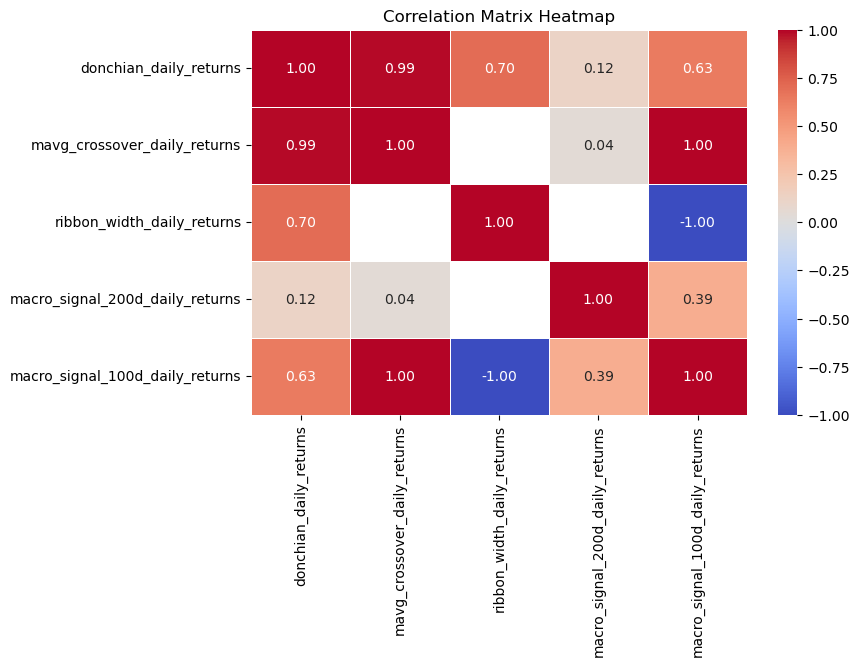

In [293]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df_returns.mask(df_returns == 0).corr()

# Set the figure size
plt.figure(figsize=(8, 5))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)

# Set the title
plt.title("Correlation Matrix Heatmap")

# Show the plot
plt.show()

In [113]:
df.head()

BTC-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2016-02-01                                    357.53   
2016-02-02                                    357.53   
2016-02-03                                    357.53   
2016-02-04                                    357.53   
2016-02-05                                    357.53   

            BTC-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2016-02-01                                    449.19   
2016-02-02                                    434.01   
2016-02-03                                    432.77   
2016-02-04                                    430.03   
2016-02-05                                    418.54   

            BTC-USD_35_6_60_mavg_crossover_20_donchian_signal  \
date                                                            
2016-02-01                                                  0   
2016-02-02                                                  0   
2016-02-03                                                  0   
2016-02-04                                                  0   
2016-02-05                                                  0   

            BTC-USD_actual_position_entry_price  \
date                                              
2016-02-01                                  0.0   
2016-02-02                                  0.0   
2016-02-03                                  0.0   
2016-02-04                                  0.0   
2016-02-05                                  0.0   

            BTC-USD_actual_position_exit_price  \
date                                             
2016-02-01                                 0.0   
2016-02-02                                 0.0   
2016-02-03                                 0.0   
2016-02-04                                 0.0   
2016-02-05                                 0.0   

            BTC-USD_actual_position_notional  BTC-USD_actual_size  \
date                                                                
2016-02-01                               0.0                  0.0   
2016-02-02                               0.0                  0.0   
2016-02-03                               0.0                  0.0   
2016-02-04                               0.0                  0.0   
2016-02-05                               0.0                  0.0   

            BTC-USD_annualized_volatility_20  BTC-USD_close BTC-USD_event  \
date                                                                        
2016-02-01                          1.076237         371.33             0   
2016-02-02                          1.072386         372.93      No Event   
2016-02-03                          1.073254         368.87      No Event   
2016-02-04                          1.073469         387.99      No Event   
2016-02-05                          0.814133         384.50      No Event   

            BTC-USD_open  BTC-USD_position_volatility_adjusted_weight  \
date                                                                    
2016-02-01        367.89                                          0.0   
2016-02-02        371.33                                          0.0   
2016-02-03        372.93                                          0.0   
2016-02-04        368.87                                          0.0   
2016-02-05        387.99                                          0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_stop_loss  BTC-USD_t_1_close  \
date                                                                            
2016-02-01                          0.0                0.0             367.95   
2016-02-02                          0.0                0.0             371.33   
2016-02-03                          0.0                0.0             372.93   
2016-02-04                          0.0                0.0             368.87   
2016-02-05                          0.0

In [115]:
df_trend.head()

BTC-USD_close  BTC-USD_open  BTC-USD_pct_returns  BTC-USD_35_mavg  \
date                                                                            
2016-01-11         449.19        449.99            -0.001778       443.474492   
2016-01-12         434.01        449.26            -0.033794       442.415178   
2016-01-13         432.77        434.01            -0.002857       441.393247   
2016-01-14         430.03        432.70            -0.006331       440.247046   
2016-01-15         357.53        430.04            -0.168593       432.265142   

            BTC-USD_35_mavg_slope  BTC-USD_40_mavg  BTC-USD_40_mavg_slope  \
date                                                                        
2016-01-11               0.781449       443.315818               0.765582   
2016-01-12               0.688889       442.309867               0.678312   
2016-01-13               0.714191       441.336363               0.707596   
2016-01-14               0.610480       440.240943               0.609096   
2016-01-15              -0.169781       432.595264              -0.137612   

            BTC-USD_45_mavg  BTC-USD_45_mavg_slope  BTC-USD_50_mavg  \
date                                                                  
2016-01-11       443.191869               0.753187       443.092417   
2016-01-12       442.226203               0.669909       442.158208   
2016-01-13       441.289473               0.702204       441.250326   
2016-01-14       440.232842               0.607683       440.224257   
2016-01-15       432.843845              -0.113415       433.037466   

            BTC-USD_50_mavg_slope  BTC-USD_55_mavg  BTC-USD_55_mavg_slope  \
date                                                                        
2016-01-11               0.743242       443.010877               0.735088   
2016-01-12               0.663081       442.101896               0.657426   
2016-01-13               0.697727       441.217231               0.693958   
2016-01-14               0.606340       440.215848               0.605101   
2016-01-15              -0.094583       433.192373              -0.079528   

            BTC-USD_60_mavg  BTC-USD_60_mavg_slope  BTC-USD_ribbon_thickness  \
date                                                                           
2016-01-11       442.942824               0.728282                  0.506441   
2016-01-12       442.054515               0.652668                  0.531669   
2016-01-13       441.188931               0.690746                  0.360663   
2016-01-14       440.207892               0.603974                  0.204316   
2016-01-15       433.319027              -0.067227                  0.039154   

            BTC-USD_trend_signal  BTC-USD_trend_strategy_returns_35_6_60  \
date                                                                       
2016-01-11                   1.0                               -0.001778   
2016-01-12                   1.0                               -0.033794   
2016-01-13                   1.0                               -0.002857   
2016-01-14                   1.0                               -0.006331   
2016-01-15                   1.0                               -0.168593   

            BTC-USD_trend_strategy_trades_35_6_60  BTC-USD_trend_slope_signal  \
date                                                                            
2016-01-11                                    0.0                         0.0   
2016-01-12                                    0.0                         1.0   
2016-01-13                                    0.0                         1.0   
2016-01-14                                    0.0                         1.0   
2016-01-15                                    0.0                         1.0   

            BTC-USD_trend_slope_strategy_returns  \
date                                               
2016-01-11                             -0.000000   
2016-01-12                             -0.033794

In [247]:
## Donchian Channel Only Performance
performance_metrics

{'annualized_return': 0.34764001836591496,
 'annualized_sharpe_ratio': 1.1696684946303546,
 'calmar_ratio': 0.1708775164952615,
 'annualized_std_dev': 0.23616471346199716,
 'max_drawdown': -2.0344397876098297,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.08907363420427554,
 't_statistic': 3.6205604925209913,
 'p_value': 0.0002997490122264077,
 'trade_count': 405.0}

In [255]:
## Moving Average Crossover Only Performance
performance_metrics

{'annualized_return': 0.004695944487797421,
 'annualized_sharpe_ratio': -0.5546837096444185,
 'calmar_ratio': 0.005918936873631777,
 'annualized_std_dev': 0.07485916676380543,
 'max_drawdown': -0.7933763424167177,
 'max_drawdown_duration': Timedelta('1156 days 00:00:00'),
 'hit_rate': 0.001979414093428345,
 't_statistic': 0.2554909309109224,
 'p_value': 0.7983647567102977,
 'trade_count': 13.0}

In [263]:
## Ribbon Width Only Performance
performance_metrics

{'annualized_return': -0.06571612366765278,
 'annualized_sharpe_ratio': -1.4343342212489252,
 'calmar_ratio': -inf,
 'annualized_std_dev': 0.07916430915383062,
 'max_drawdown': 0.0,
 'max_drawdown_duration': Timedelta('2525 days 00:00:00'),
 'hit_rate': 0.007521773555027712,
 't_statistic': -2.1518489951461692,
 'p_value': 0.0315037944267384,
 'trade_count': 37.0}

In [277]:
## Ribbon Width & Donchian Channel Performance
performance_metrics

{'annualized_return': 0.26176716519770826,
 'annualized_sharpe_ratio': 1.0718272679073257,
 'calmar_ratio': 0.2199869290561772,
 'annualized_std_dev': 0.18684337247180308,
 'max_drawdown': -1.1899214481550484,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.04117181314330958,
 't_statistic': 3.506644388613179,
 'p_value': 0.0004617107665852398,
 'trade_count': 182.0}

In [285]:
## Moving Average Crossover & Donchian Channel Performance
performance_metrics

{'annualized_return': 0.4072296982799757,
 'annualized_sharpe_ratio': 1.4294117923174463,
 'calmar_ratio': 0.36298358128732094,
 'annualized_std_dev': 0.2212017268920184,
 'max_drawdown': -1.121895642871052,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.06690419635787807,
 't_statistic': 4.3406314743516985,
 'p_value': 1.4766825739191315e-05,
 'trade_count': 292.0}

In [296]:
## Moving Average Crossover, Donchian Channel Performance and Ribbon Width Indicator Equal Weighted
performance_metrics

{'annualized_return': 0.29211352334696605,
 'annualized_sharpe_ratio': 1.2098798289061523,
 'calmar_ratio': 0.245489753798356,
 'annualized_std_dev': 0.18488113367526934,
 'max_drawdown': -1.1899214481550484,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.03721298495645289,
 't_statistic': 3.8771097911570824,
 'p_value': 0.00010840096783091848,
 'trade_count': 161.0}

In [108]:
## Moving Average Crossover, Donchian Channel Performance and Ribbon Width Indicator Signal Weighted
performance_metrics

{'annualized_return': 0.29211352334696605,
 'annualized_sharpe_ratio': 1.2098798289061523,
 'calmar_ratio': 0.245489753798356,
 'annualized_std_dev': 0.6563256763385574,
 'max_drawdown': -1.1899214481550484,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.03721298495645289,
 't_statistic': 3.8771097911570824,
 'p_value': 0.00010840096783091848,
 'trade_count': 161.0}

In [229]:
df.head()

BTC-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2016-02-01                                    357.53   
2016-02-02                                    357.53   
2016-02-03                                    357.53   
2016-02-04                                    357.53   
2016-02-05                                    357.53   

            BTC-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2016-02-01                                    449.19   
2016-02-02                                    434.01   
2016-02-03                                    432.77   
2016-02-04                                    430.03   
2016-02-05                                    418.54   

            BTC-USD_35_6_60_mavg_crossover_20_donchian_signal  \
date                                                            
2016-02-01                                                  0   
2016-02-02                                                  0   
2016-02-03                                                  0   
2016-02-04                                                  0   
2016-02-05                                                  0   

            BTC-USD_actual_position_entry_price  \
date                                              
2016-02-01                                  0.0   
2016-02-02                                  0.0   
2016-02-03                                  0.0   
2016-02-04                                  0.0   
2016-02-05                                  0.0   

            BTC-USD_actual_position_exit_price  \
date                                             
2016-02-01                                 0.0   
2016-02-02                                 0.0   
2016-02-03                                 0.0   
2016-02-04                                 0.0   
2016-02-05                                 0.0   

            BTC-USD_actual_position_notional  BTC-USD_actual_size  \
date                                                                
2016-02-01                               0.0                  0.0   
2016-02-02                               0.0                  0.0   
2016-02-03                               0.0                  0.0   
2016-02-04                               0.0                  0.0   
2016-02-05                               0.0                  0.0   

            BTC-USD_annualized_volatility_20  BTC-USD_close BTC-USD_event  \
date                                                                        
2016-02-01                          1.076237         371.33             0   
2016-02-02                          1.072386         372.93      No Event   
2016-02-03                          1.073254         368.87      No Event   
2016-02-04                          1.073469         387.99      No Event   
2016-02-05                          0.814133         384.50      No Event   

            BTC-USD_open  BTC-USD_position_volatility_adjusted_weight  \
date                                                                    
2016-02-01        367.89                                          0.0   
2016-02-02        371.33                                          0.0   
2016-02-03        372.93                                          0.0   
2016-02-04        368.87                                          0.0   
2016-02-05        387.99                                          0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_stop_loss  BTC-USD_t_1_close  \
date                                                                            
2016-02-01                          0.0                0.0             367.95   
2016-02-02                          0.0                0.0             371.33   
2016-02-03                          0.0                0.0             372.93   
2016-02-04                          0.0                0.0             368.87   
2016-02-05                          0.0

In [220]:
## With Ribbon Mod Signal Equal Weighted
performance_metrics

{'annualized_return': 0.08812809363714846,
 'annualized_sharpe_ratio': 0.2870381576186949,
 'calmar_ratio': 0.07955832996489406,
 'annualized_std_dev': 0.1747282647876872,
 'max_drawdown': -1.107716736588562,
 'max_drawdown_duration': Timedelta('799 days 00:00:00'),
 'hit_rate': 0.035629453681710214,
 't_statistic': 1.489738928889646,
 'p_value': 0.13641778761150286,
 'trade_count': 157.0}

In [239]:
## With Ribbon Mod2 Signal
performance_metrics

{'annualized_return': 0.29211352334696605,
 'annualized_sharpe_ratio': 1.2098798289061523,
 'calmar_ratio': 0.245489753798356,
 'annualized_std_dev': 0.18488113367526934,
 'max_drawdown': -1.1899214481550484,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.03721298495645289,
 't_statistic': 3.8771097911570824,
 'p_value': 0.00010840096783091848,
 'trade_count': 161.0}

In [151]:
## With Ribbon Mod2 Signal with a z-score threshold at 0.5 and -0.5
performance_metrics

{'annualized_return': 0.1006204170595204,
 'annualized_sharpe_ratio': 0.49706739930244154,
 'calmar_ratio': 0.3352864349333859,
 'annualized_std_dev': 0.10537094885720731,
 'max_drawdown': -0.300102857067604,
 'max_drawdown_duration': Timedelta('1064 days 00:00:00'),
 'hit_rate': 0.015439429928741092,
 't_statistic': 2.525809675123117,
 'p_value': 0.011603896701851288,
 'trade_count': 61.0}

In [169]:
## With Ribbon Mod Signal with a z-score threshold at 0.5 and -0.5 and no monotonic signal
performance_metrics

{'annualized_return': 0.29211352334696605,
 'annualized_sharpe_ratio': 1.2098798289061523,
 'calmar_ratio': 0.245489753798356,
 'annualized_std_dev': 0.18488113367526934,
 'max_drawdown': -1.1899214481550484,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.03721298495645289,
 't_statistic': 3.8771097911570824,
 'p_value': 0.00010840096783091848,
 'trade_count': 161.0}

In [161]:
## With Ribbon Mod2 Signal with a z-score threshold at 0.5 and -0.5 and no monotonic signal
performance_metrics

{'annualized_return': 0.2429241856003994,
 'annualized_sharpe_ratio': 1.1711974773105711,
 'calmar_ratio': 0.8094697530509549,
 'annualized_std_dev': 0.15361036439495868,
 'max_drawdown': -0.300102857067604,
 'max_drawdown_duration': Timedelta('1054 days 00:00:00'),
 'hit_rate': 0.028503562945368172,
 't_statistic': 3.9166857500952204,
 'p_value': 9.215508331216118e-05,
 'trade_count': 117.0}

In [330]:
## With Macro with 100d Simple Mavg
performance_metrics

{'annualized_return': 0.424938405374653,
 'annualized_sharpe_ratio': 1.4883785052757181,
 'calmar_ratio': 0.3563554767021332,
 'annualized_std_dev': 0.22078679598284492,
 'max_drawdown': -1.192456502443054,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.0665083135391924,
 't_statistic': 4.4968453693300985,
 'p_value': 7.208516122098651e-06,
 'trade_count': 287.0}

In [40]:
## With Macro with 100d Exp Mavg
performance_metrics

{'annualized_return': 0.4072296982799757,
 'annualized_sharpe_ratio': 1.4294117923174463,
 'calmar_ratio': 0.36298358128732094,
 'annualized_std_dev': 0.2212017268920184,
 'max_drawdown': -1.121895642871052,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.06690419635787807,
 't_statistic': 4.3406314743516985,
 'p_value': 1.4766825739191315e-05,
 'trade_count': 292.0}

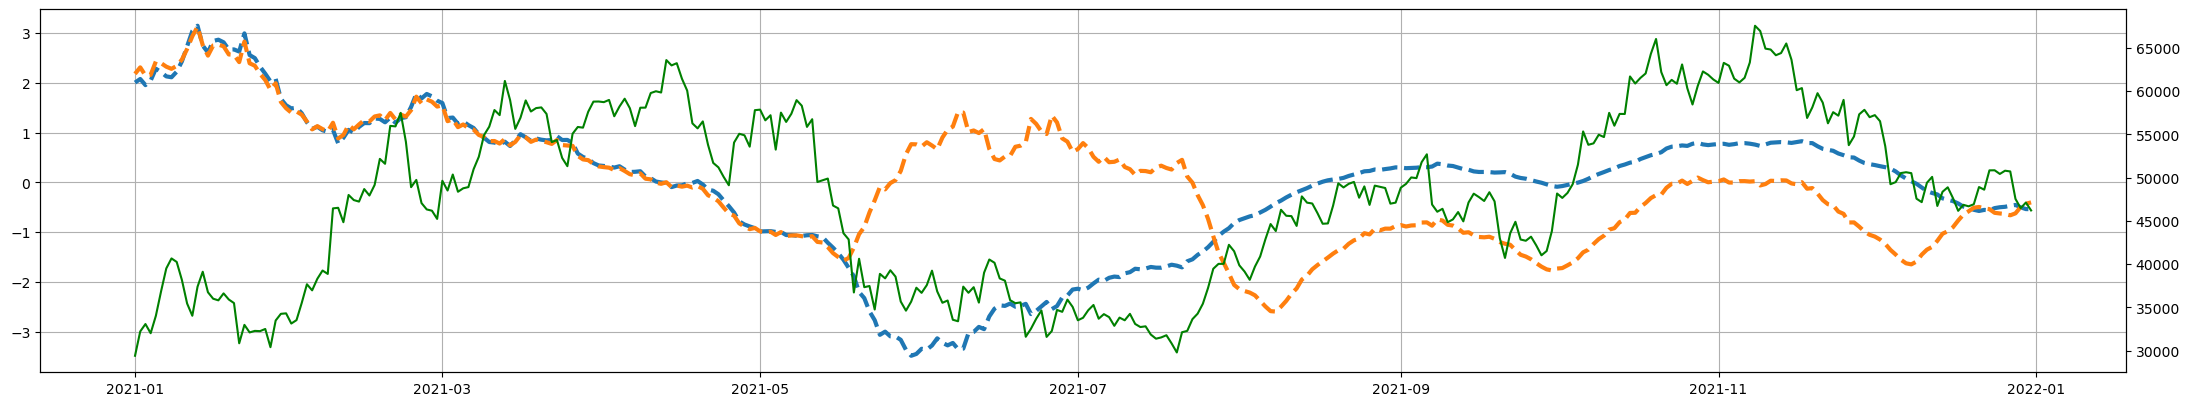

In [118]:
fig = plt.figure(figsize=(22,20))
layout = (5,2)
ribbon_ax = plt.subplot2grid(layout, (0,0), colspan=2)

df_date_cond = (df.index >= pd.Timestamp('2021-01-01').date()) & (df.index <= pd.Timestamp('2021-12-31').date())

ribbon_ax2 = ribbon_ax.twinx()
_ = ribbon_ax.plot(df[df_date_cond].index, df[df_date_cond]['BTC-USD_ribbon_thickness_mod_zscore'], linewidth=3, linestyle='--')
_ = ribbon_ax.plot(df[df_date_cond].index, df[df_date_cond]['BTC-USD_ribbon_thickness_mod2_zscore'], linewidth=3, linestyle='--')
_ = ribbon_ax2.plot(df[df_date_cond].index, df[df_date_cond]['BTC-USD_close'], color='green')

_ = ribbon_ax.grid()
plt.tight_layout()

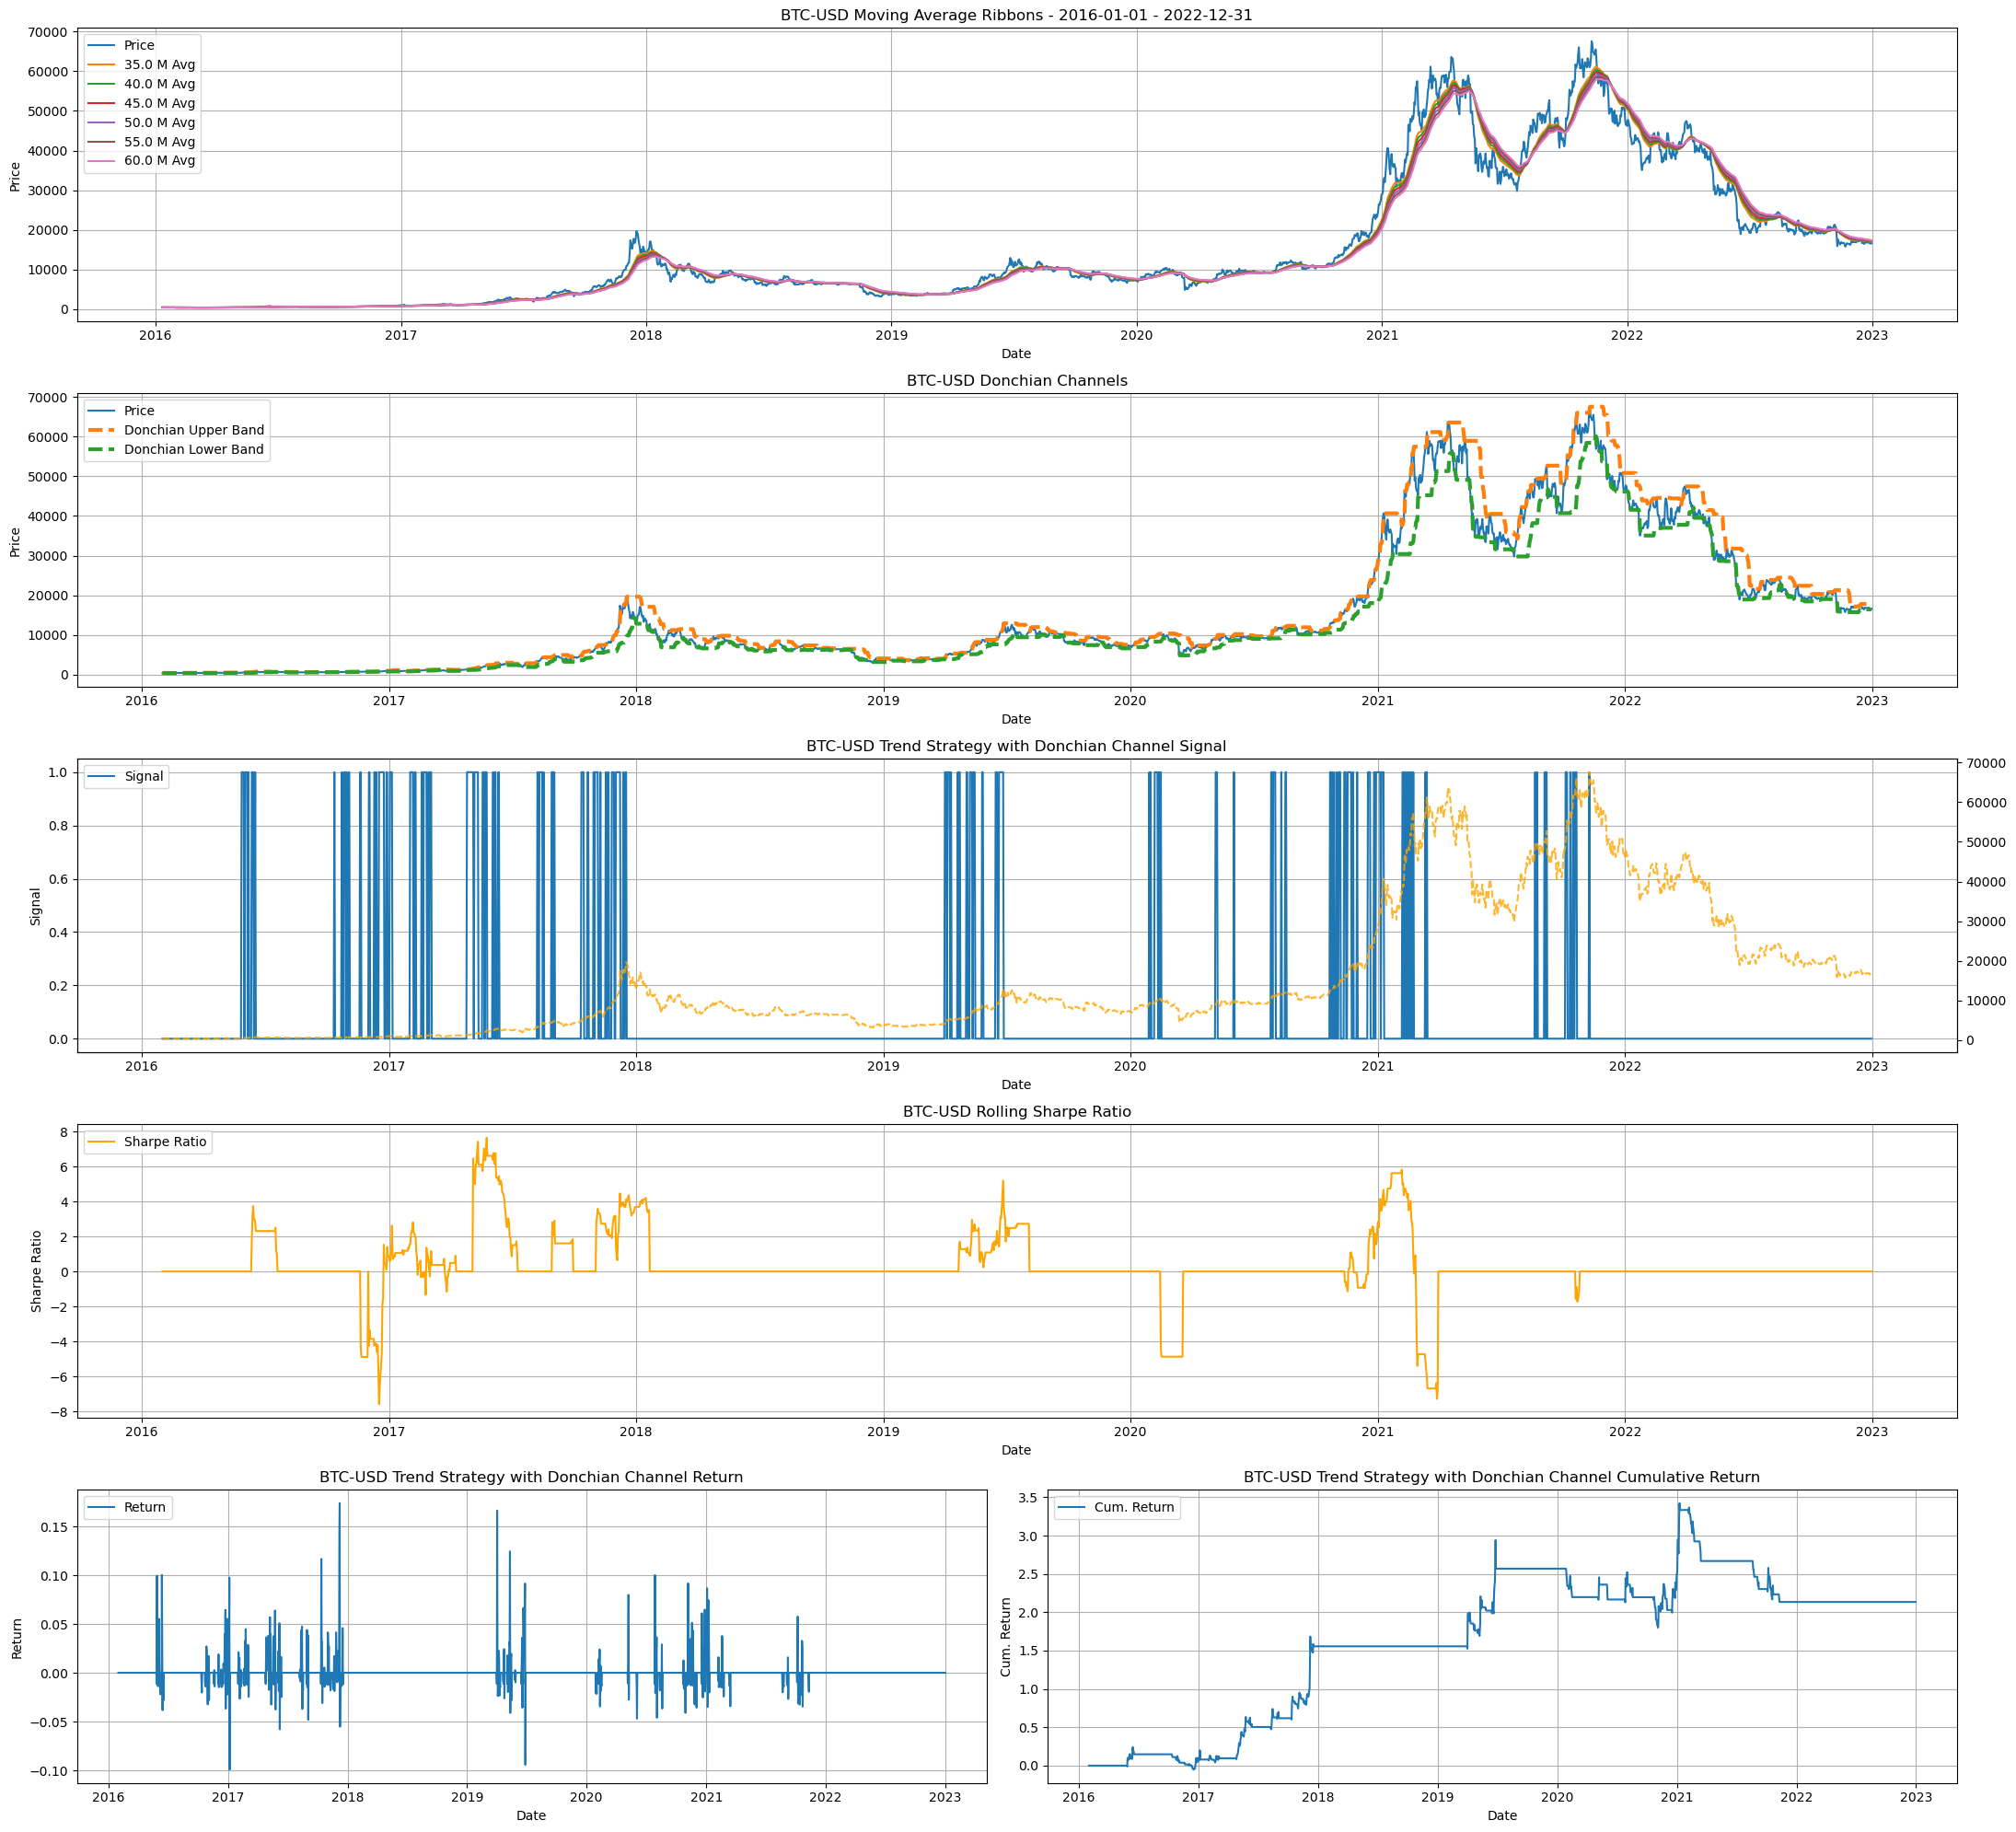

In [287]:
ticker = ticker_list[0]
df_date_cond = (df.index >= pd.Timestamp('2021-01-01').date()) & (df.index <= pd.Timestamp('2021-12-31').date())
df_trend_date_cond = (df_trend.index >= pd.Timestamp('2021-01-01').date()) & (df_trend.index <= pd.Timestamp('2021-12-31').date())
                
plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, 
                                             rolling_sharpe_window)

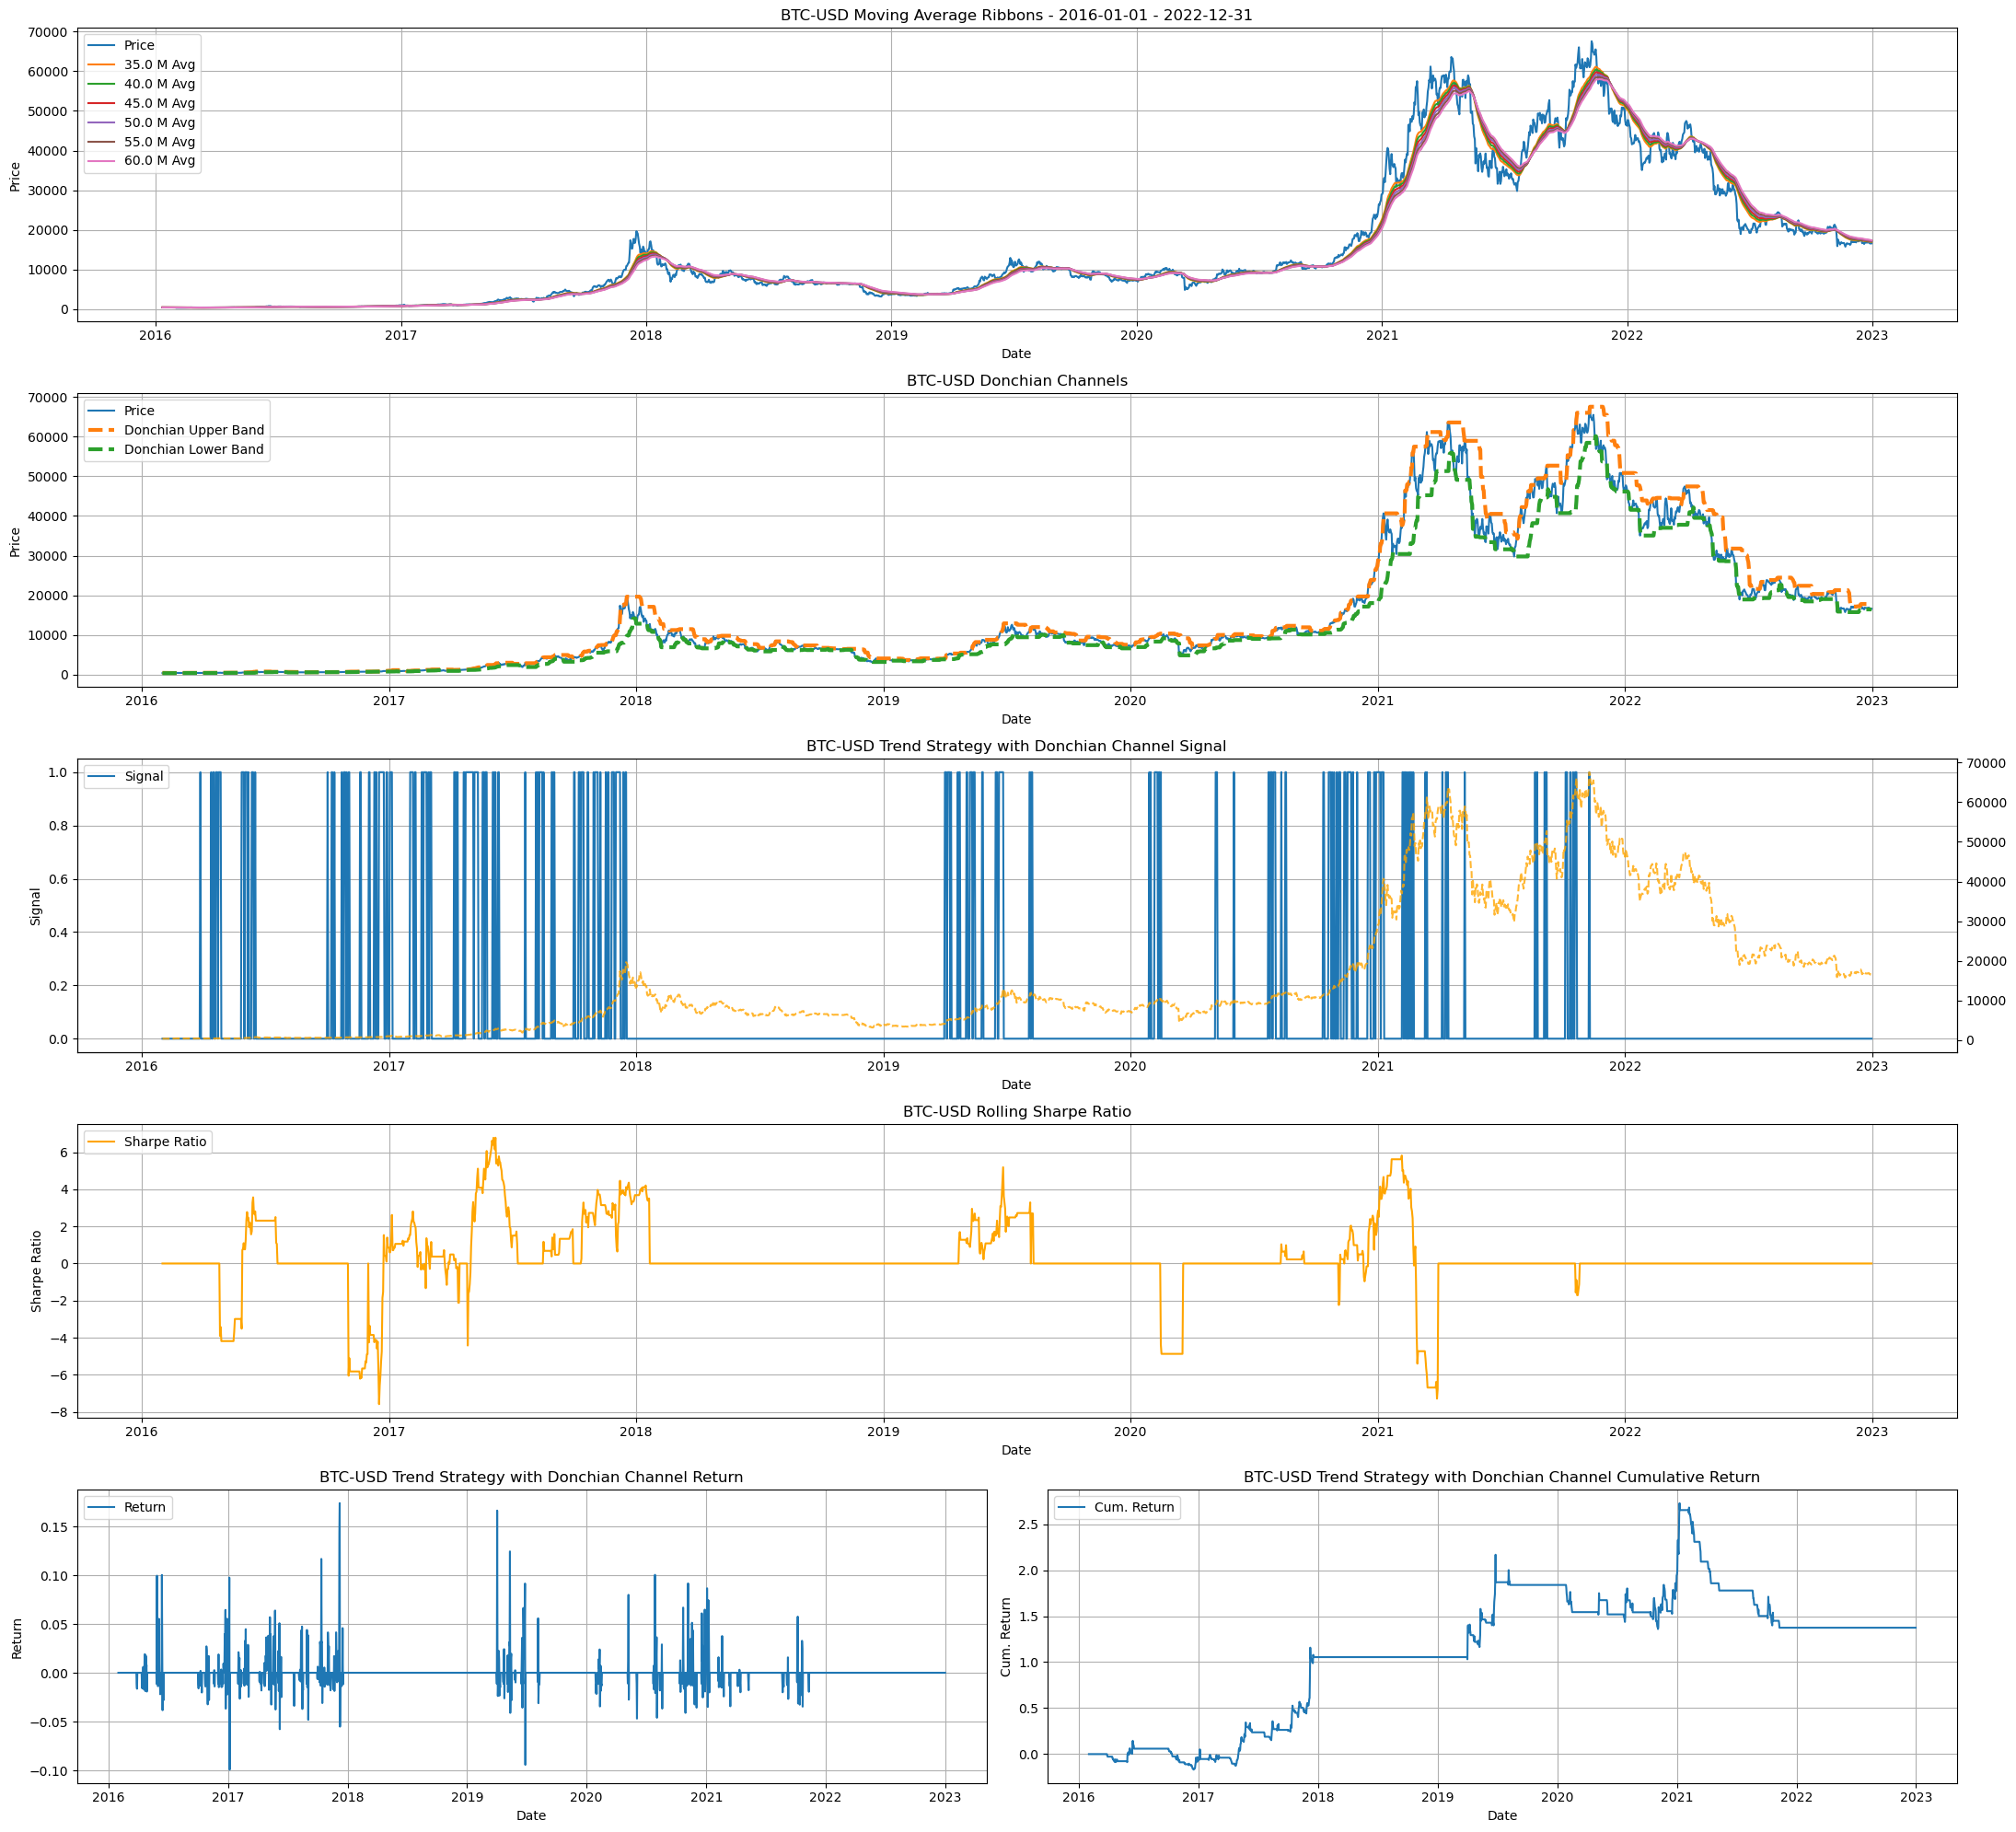

In [288]:
ticker = ticker_list[0]
df_date_cond = (df.index >= pd.Timestamp('2021-01-01').date()) & (df.index <= pd.Timestamp('2021-12-31').date())
df_trend_date_cond = (df_trend.index >= pd.Timestamp('2021-01-01').date()) & (df_trend.index <= pd.Timestamp('2021-12-31').date())
                
plot_trend_following_performance_time_series(df_orig, df_trend_orig, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, 
                                             rolling_sharpe_window)

In [49]:
df_orig['total_portfolio_value'].tail()

date
2022-12-27    159535.853128
2022-12-28    159535.853128
2022-12-29    159535.853128
2022-12-30    159535.853128
2022-12-31    159535.853128
Name: total_portfolio_value, dtype: float64

In [51]:
df['total_portfolio_value'].tail()

date
2022-12-27    171011.271413
2022-12-28    171011.271413
2022-12-29    171011.271413
2022-12-30    171011.271413
2022-12-31    171011.271413
Name: total_portfolio_value, dtype: float64

<Axes: xlabel='date'>

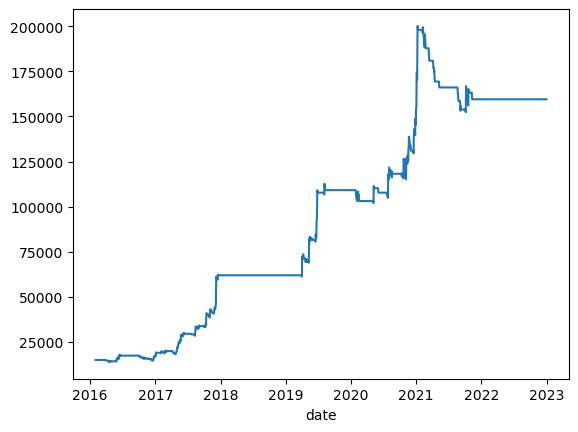

In [47]:
df_orig['total_portfolio_value'].plot()

<Axes: xlabel='date'>

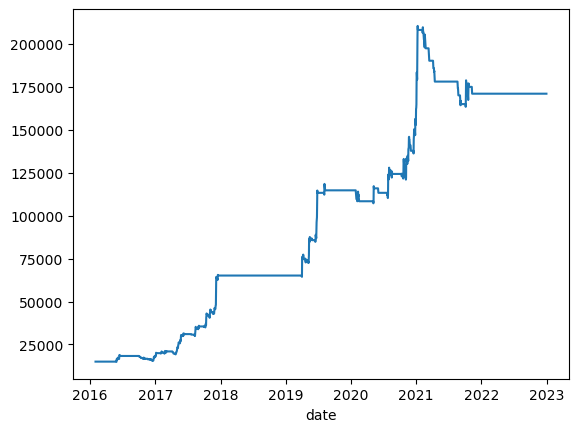

In [45]:
df['total_portfolio_value'].plot()

In [209]:
start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2022-12-31').date()
ticker_list = ['BTC-USD']
rolling_donchian_window = 20
long_only = True
use_coinbase_data = True
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001
passive_trade_rate = 0.05
rolling_sharpe_window = 50
# fast_mavg_list=np.arange(10, 101, 10)
# slow_mavg_list=np.arange(50, 501, 50)
fast_mavg_list = np.arange(5, 51, 5)
slow_mavg_list = np.arange(10, 101, 10)
df_performance_returns = moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list, slow_mavg_list, rolling_donchian_window, long_only, initial_capital,
                                                                   rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                   use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                   annual_trading_days, use_specific_start_date, signal_start_date)

In [84]:
df_performance_returns.shape

(372, 13)

In [255]:
import os

# Ensure the directory exists
if not os.path.exists('trend_following_results'):
    os.makedirs('trend_following_results')

# Save the DataFrame to a pickle file
df_performance_returns.to_pickle('trend_following_results/BTC-USD_Moving_Average_Donchian_Results_Version_2_2016-01-01-2022-12-31.pickle')

In [88]:
df_performance_returns

fast_mavg slow_mavg stepsize  annualized_return  sharpe_ratio  \
0          10        50        2           0.363419      1.287083   
1          10        50        4           0.363419      1.287083   
2          10        50        6           0.363419      1.287083   
3          10        50        8           0.363419      1.287083   
4          20        50        2           0.360958      1.281526   
5          20        50        4           0.360958      1.281526   
6          20        50        6           0.360958      1.281526   
7          20        50        8           0.360958      1.281526   
8          30        50        2           0.392139      1.378250   
9          30        50        4           0.392139      1.378250   
10         30        50        6           0.392139      1.378250   
11         30        50        8           0.392139      1.378250   
12         40        50        2           0.396504      1.392930   
13         40        50        4           0.396504      1.392930   
14         40        50        6           0.396504      1.392930   
15         40        50        8           0.396504      1.392930   
16         10       100        2           0.385787      1.428746   
17         10       100        4           0.385787      1.428746   
18         10       100        6           0.385787      1.428746   
19         10       100        8           0.385787      1.428746   
20         20       100        2           0.383010      1.419474   
21         20       100        4           0.383010      1.419474   
22         20       100        6           0.383010      1.419474   
23         20       100        8           0.383010      1.419474   
24         30       100        2           0.380989      1.412322   
25         30       100        4           0.380989      1.412322   
26         30       100        6           0.380989      1.412322   
27         30       100        8           0.380989      1.412322   
28         40       100        2           0.382168      1.416366   
29         40       100        4           0.382168      1.416366   
30         40       100        6           0.382168      1.416366   
31         40       100        8           0.382168      1.416366   
32         50       100        2           0.382168      1.416366   
33         50       100        4           0.382168      1.416366   
34         50       100        6           0.382168      1.416366   
35         50       100        8           0.382168      1.416366   
36         60       100        2           0.380578      1.408527   
37         60       100        4           0.380578      1.408527   
38         60       100        6           0.380578      1.408527   
39         60       100        8           0.380578      1.408527   
40         70       100        2           0.371261      1.375156   
41         70       100        4           0.371261      1.375156   
42         70       100        6           0.371261      1.375156   
43         70       100        8           0.371261      1.375156   
44         80       100        2           0.371261      1.375156   
45         80       100        4           0.371261      1.375156   
46         80       100        6           0.371261      1.375156   
47         80       100        8           0.371261      1.375156   
48         90       100        2           0.374948      1.388394   
49         90       100        4           0.374948      1.388394   
50         90       100        6           0.374948      1.388394   
51         90       100        8           0.374948      1.388394   
52         10       150        2           0.351414      1.344709   
53         10       150        4           0.351414      1.344709   
54         10       150        6           0.351414      1.344709   
55         10       150        8           0.351414      1.344709   
56         20       150        2           0.349439      1.337333   
57

In [217]:
df_performance_returns.sort_values('sharpe_ratio', ascending=False)

fast_mavg slow_mavg stepsize  annualized_return  sharpe_ratio  \
127        35        60        8           0.407230      1.429412   
126        35        60        6           0.407230      1.429412   
125        35        60        4           0.407230      1.429412   
124        35        60        2           0.407230      1.429412   
264        10       100        2           0.385787      1.428746   
265        10       100        4           0.385787      1.428746   
266        10       100        6           0.385787      1.428746   
267        10       100        8           0.385787      1.428746   
119        25        60        8           0.406513      1.426464   
116        25        60        2           0.406513      1.426464   
118        25        60        6           0.406513      1.426464   
117        25        60        4           0.406513      1.426464   
129        40        60        4           0.406382      1.425941   
130        40        60        6           0.406382      1.425941   
131        40        60        8           0.406382      1.425941   
128        40        60        2           0.406382      1.425941   
260         5       100        2           0.383762      1.421595   
261         5       100        4           0.383762      1.421595   
262         5       100        6           0.383762      1.421595   
263         5       100        8           0.383762      1.421595   
123        30        60        8           0.404457      1.419723   
122        30        60        6           0.404457      1.419723   
121        30        60        4           0.404457      1.419723   
120        30        60        2           0.404457      1.419723   
275        20       100        8           0.383010      1.419474   
273        20       100        4           0.383010      1.419474   
272        20       100        2           0.383010      1.419474   
274        20       100        6           0.383010      1.419474   
296        50       100        2           0.382168      1.416366   
295        45       100        8           0.382168      1.416366   
294        45       100        6           0.382168      1.416366   
293        45       100        4           0.382168      1.416366   
292        45       100        2           0.382168      1.416366   
291        40       100        8           0.382168      1.416366   
297        50       100        4           0.382168      1.416366   
298        50       100        6           0.382168      1.416366   
284        35       100        2           0.382168      1.416366   
290        40       100        6           0.382168      1.416366   
287        35       100        8           0.382168      1.416366   
289        40       100        4           0.382168      1.416366   
285        35       100        4           0.382168      1.416366   
286        35       100        6           0.382168      1.416366   
299        50       100        8           0.382168      1.416366   
288        40       100        2           0.382168      1.416366   
234        20        90        6           0.382381      1.416296   
232        20        90        2           0.382381      1.416296   
233        20        90        4           0.382381      1.416296   
235        20        90        8           0.382381      1.416296   
276        25       100        2           0.380989      1.412322   
277        25       100        4           0.380989      1.412322   
278        25       100        6           0.380989      1.412322   
279        25       100        8           0.380989      1.412322   
282        30       100        6           0.380989      1.412322   
283        30       100        8           0.380989      1.412322   
281        30       100        4           0.380989      1.412322   
280        30       100        2           0.380989      1.412322   
237        25        90        4           0.381201      1.412254   
23

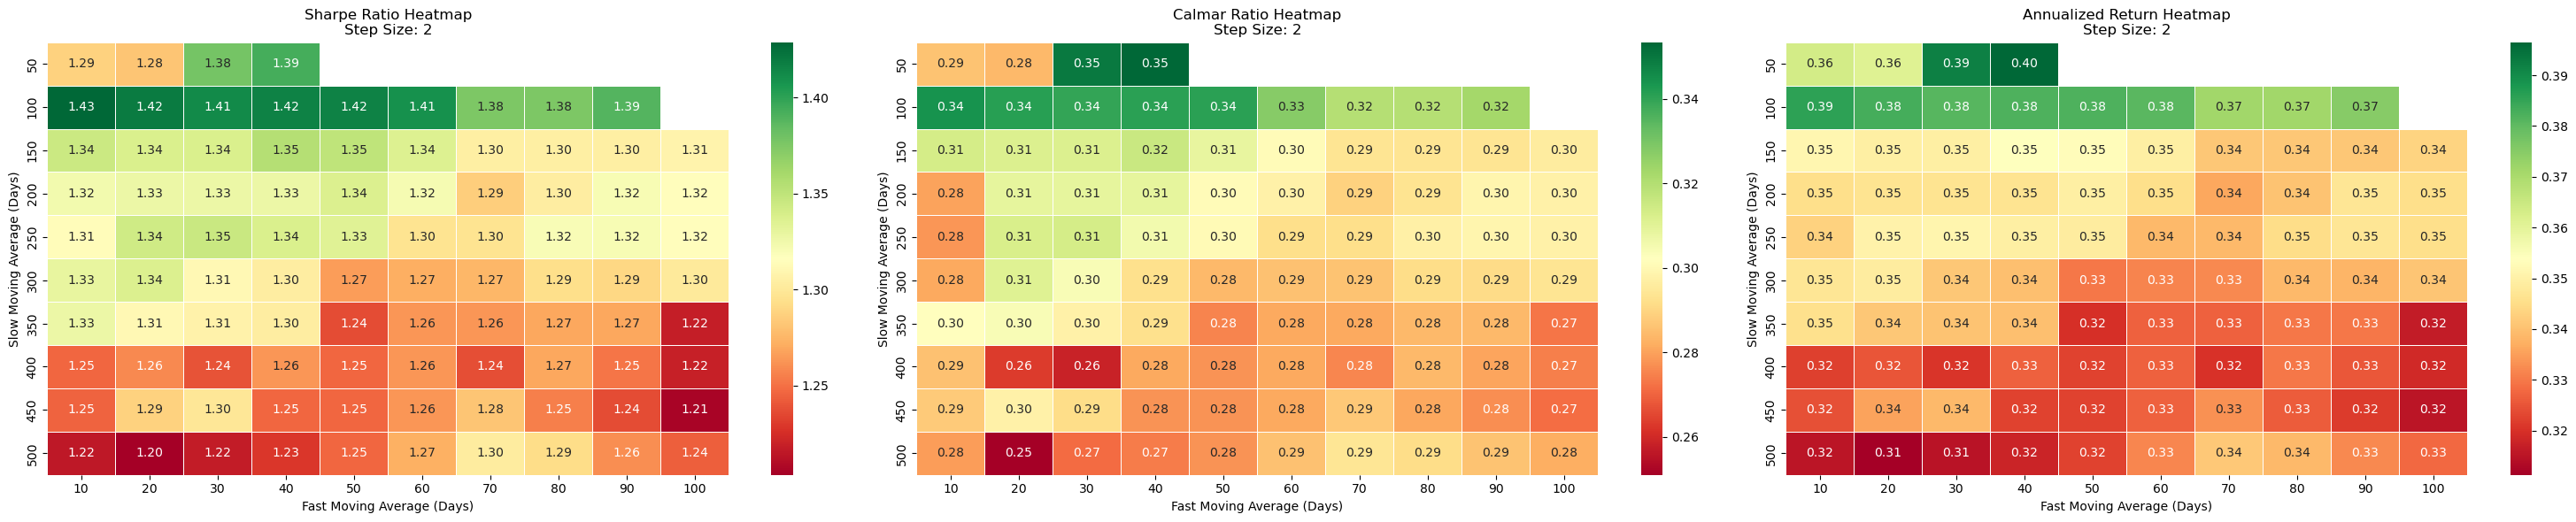

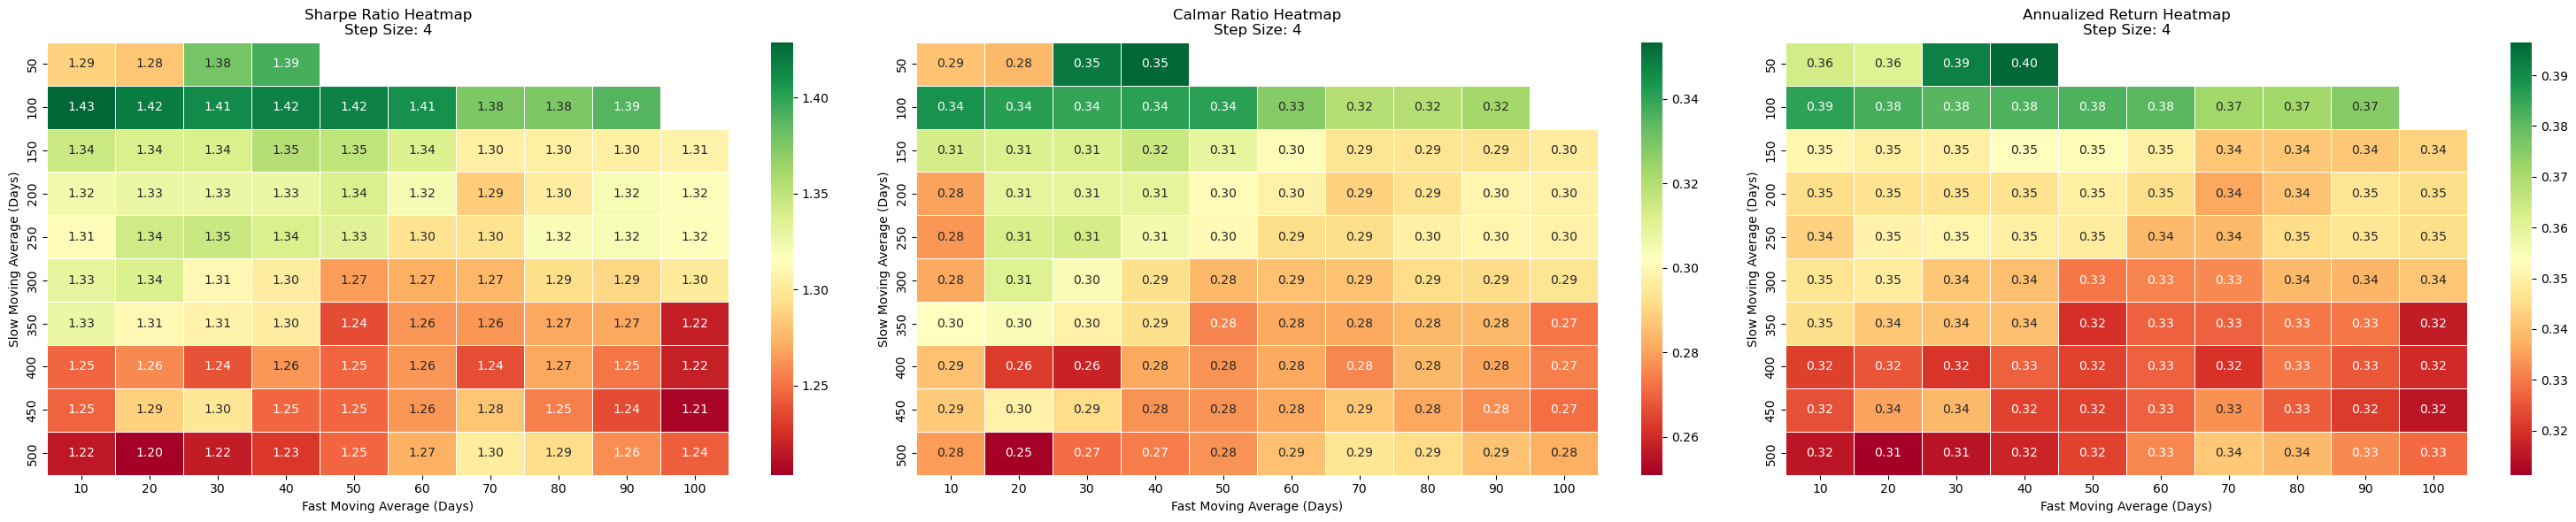

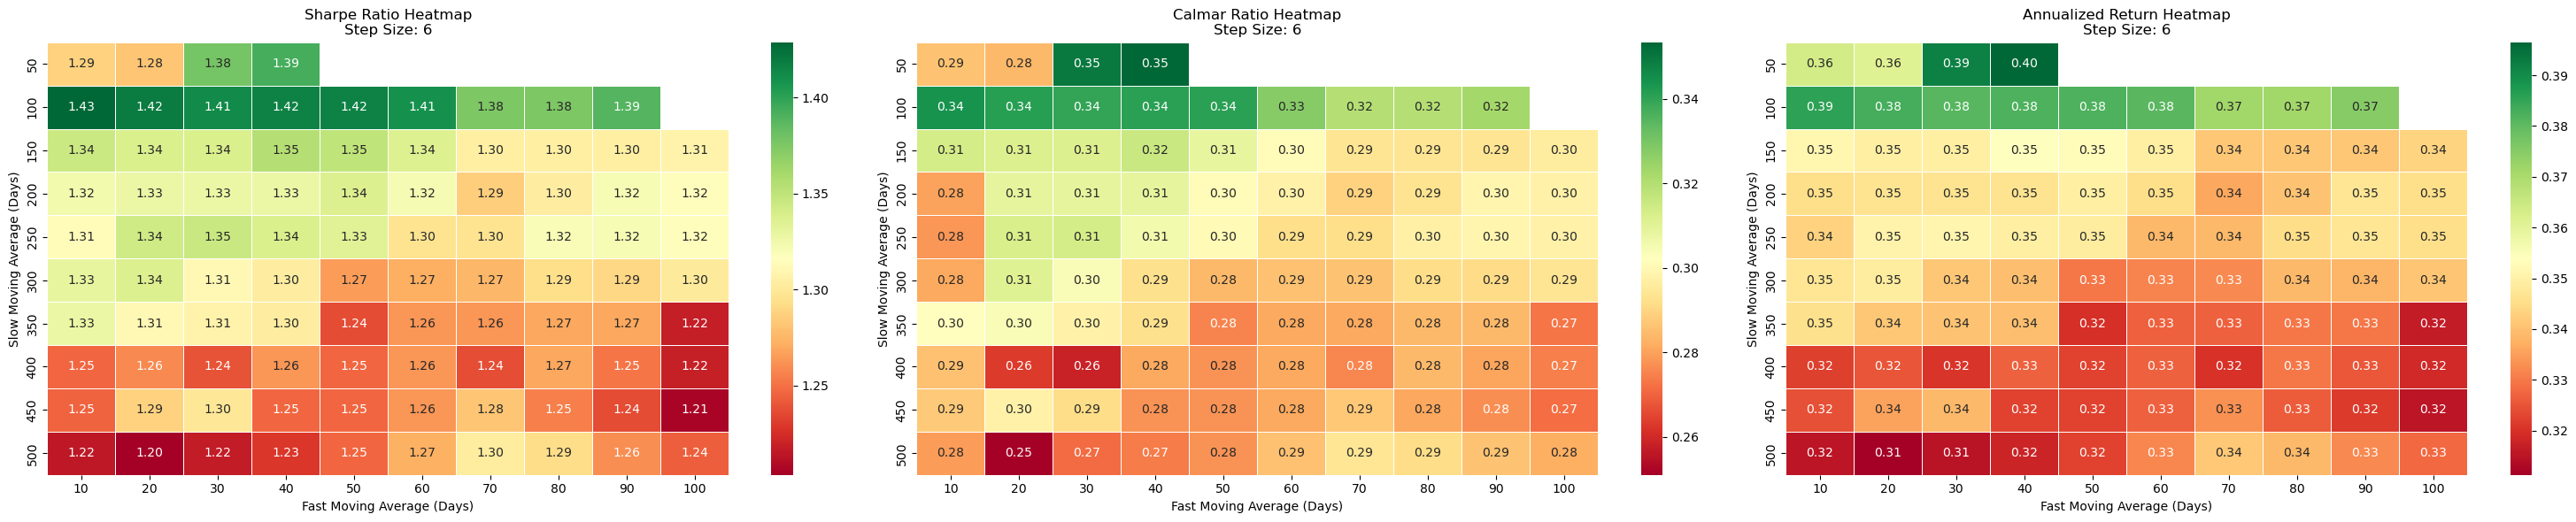

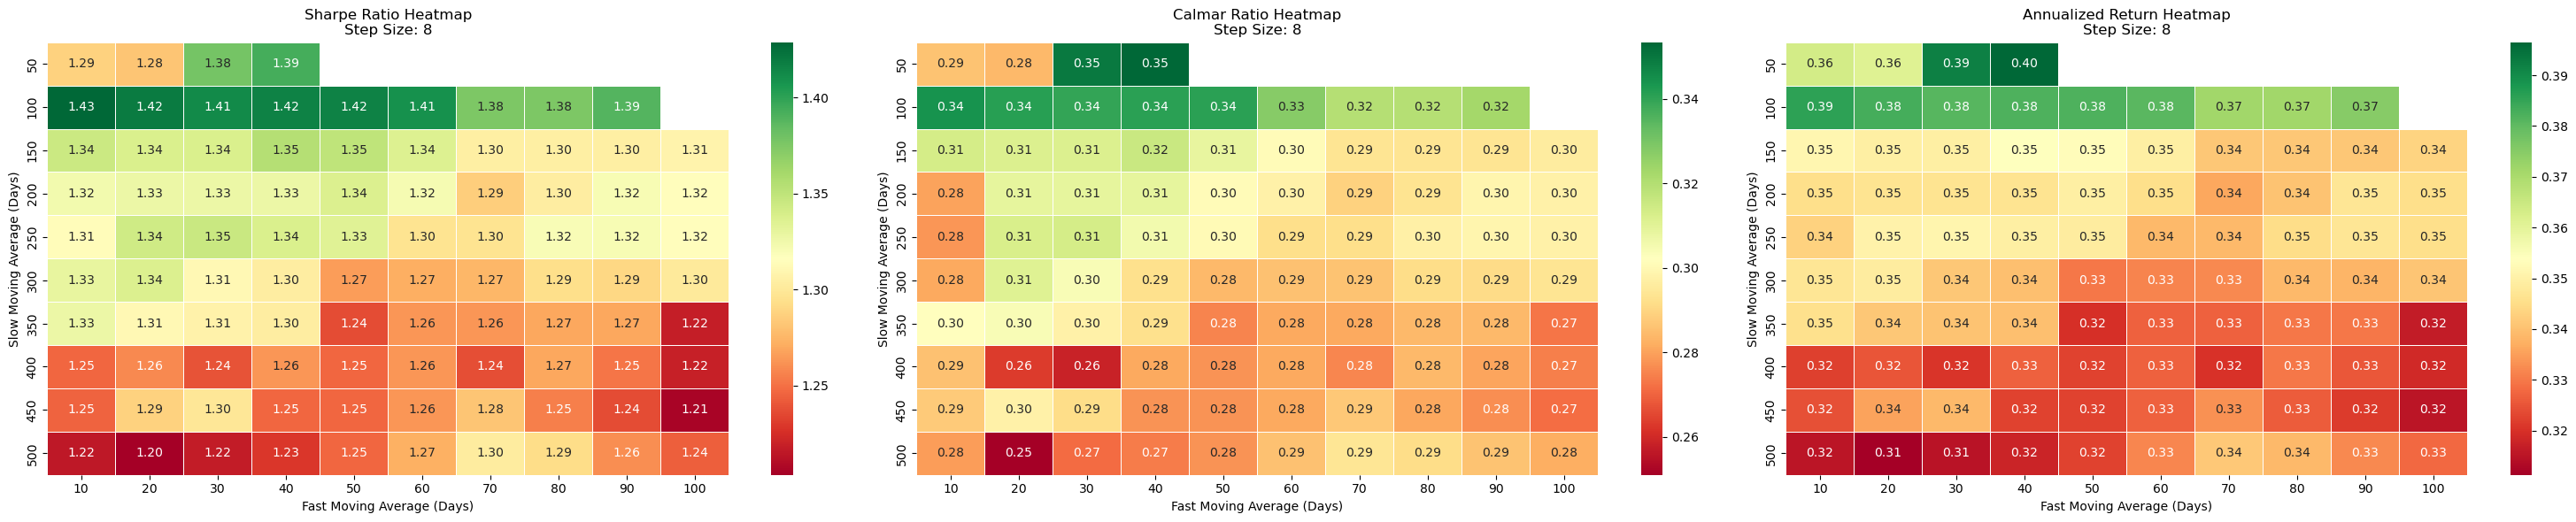

In [142]:
plot_moving_avg_crossover_performance_heatmap(df_performance_returns)

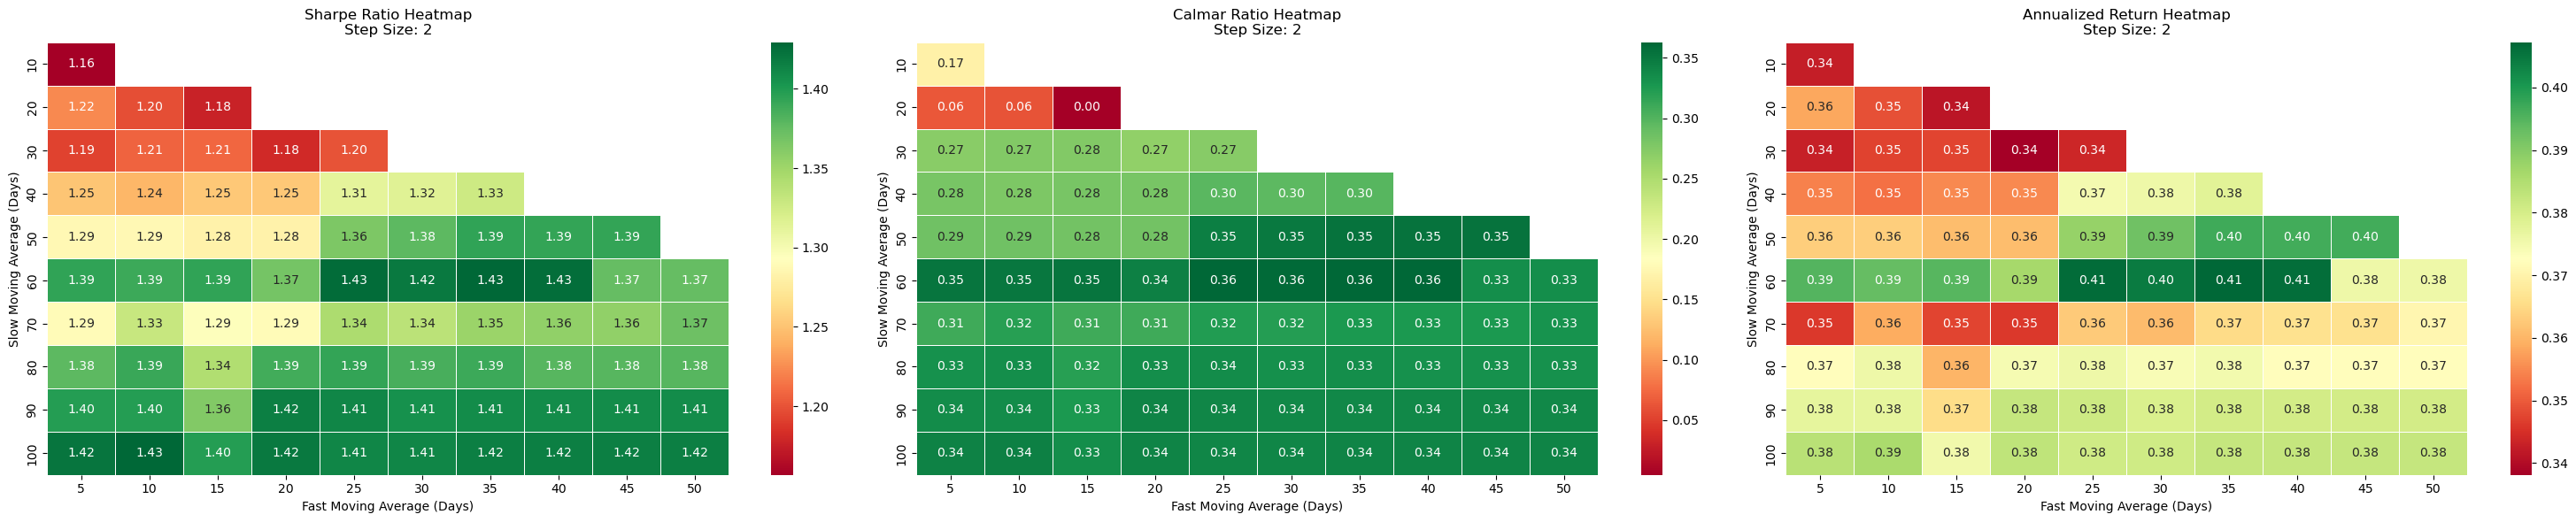

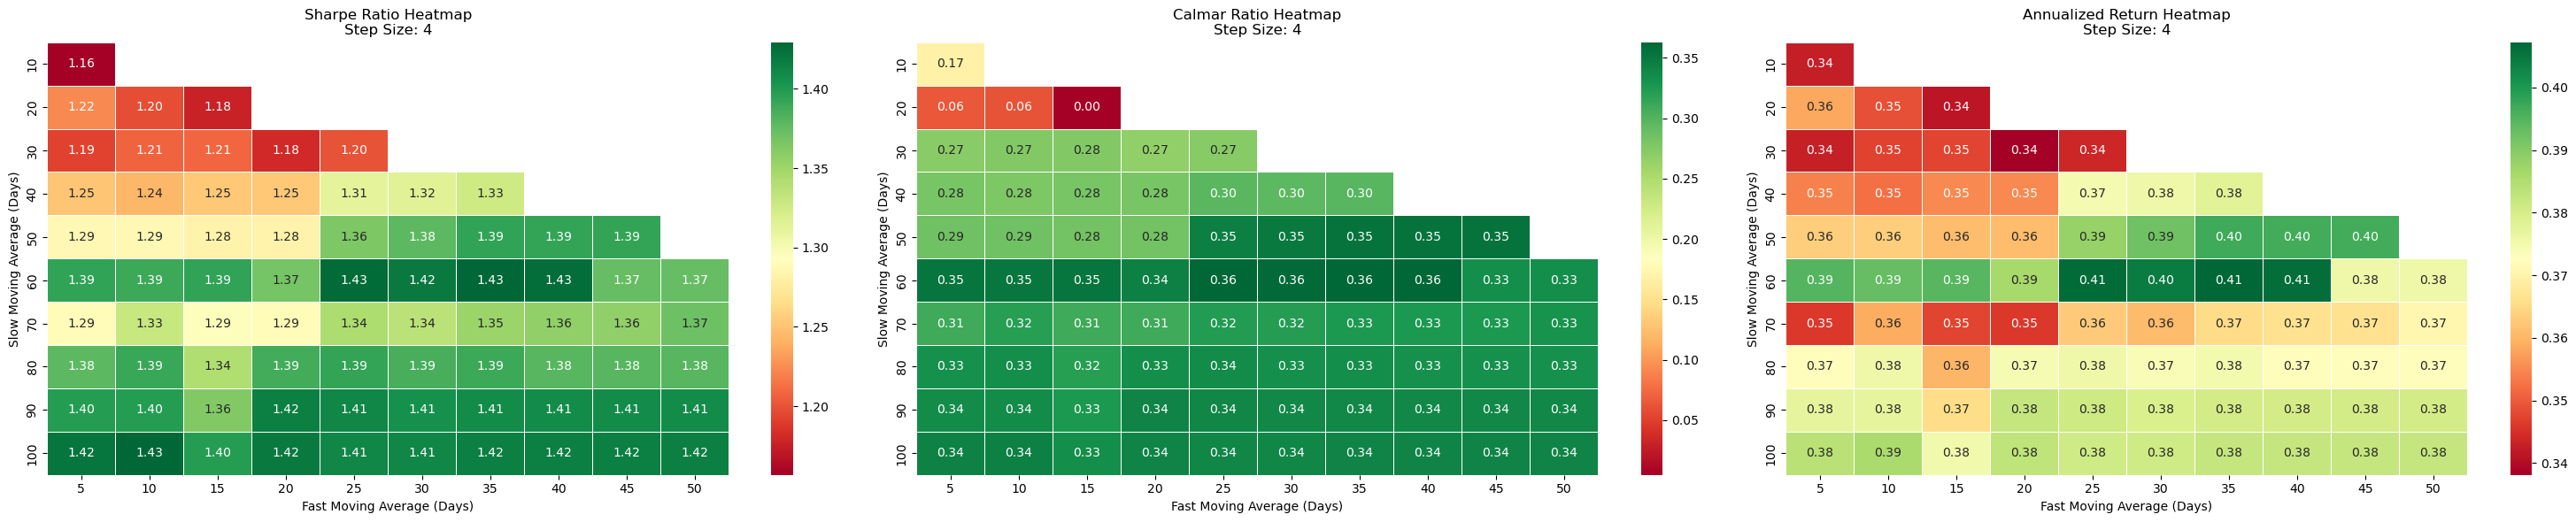

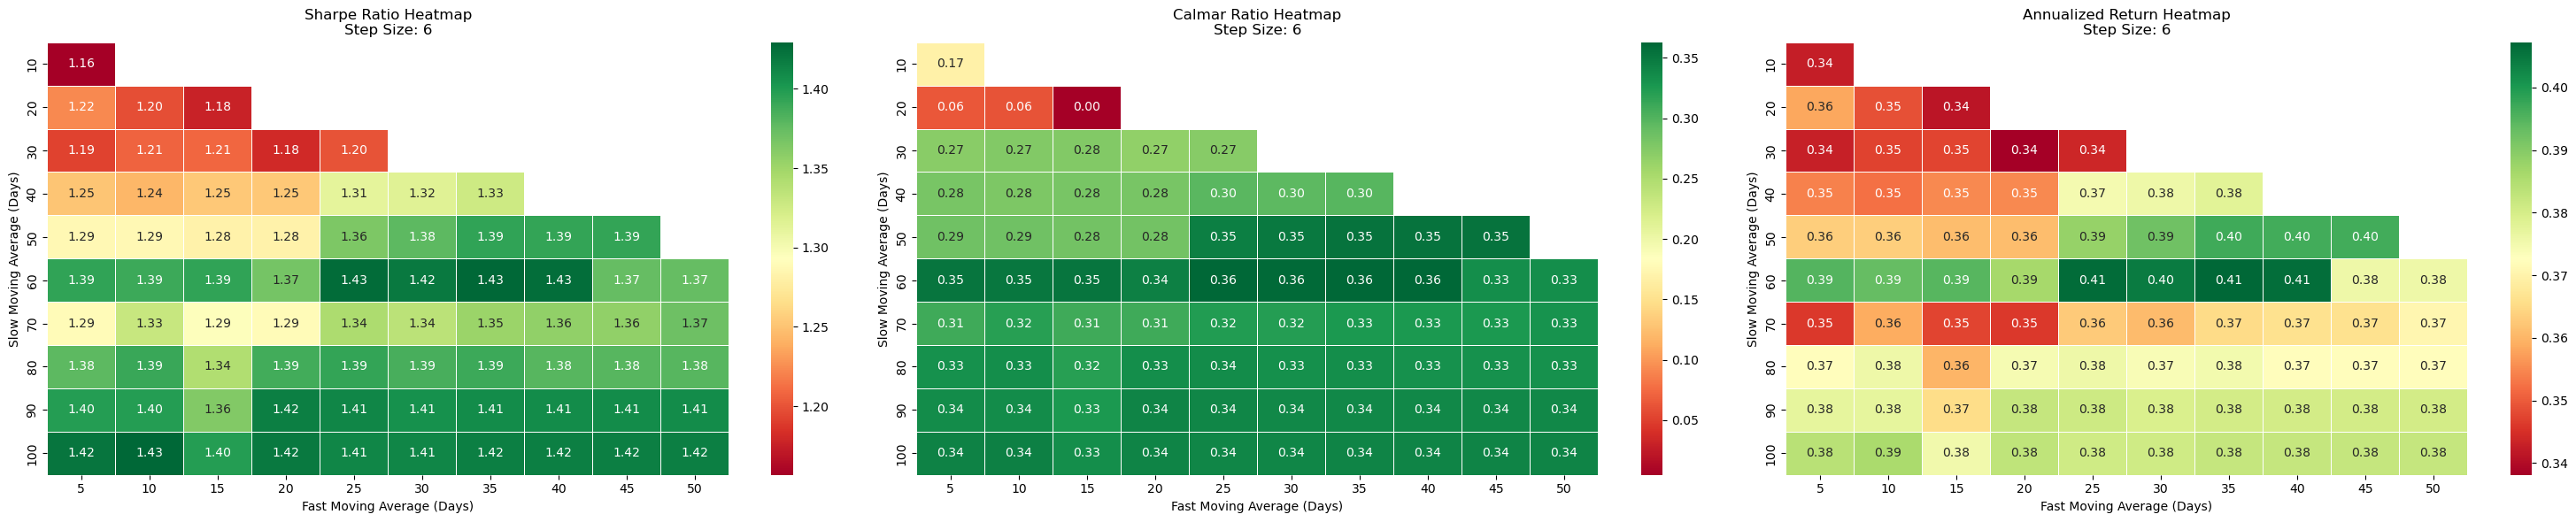

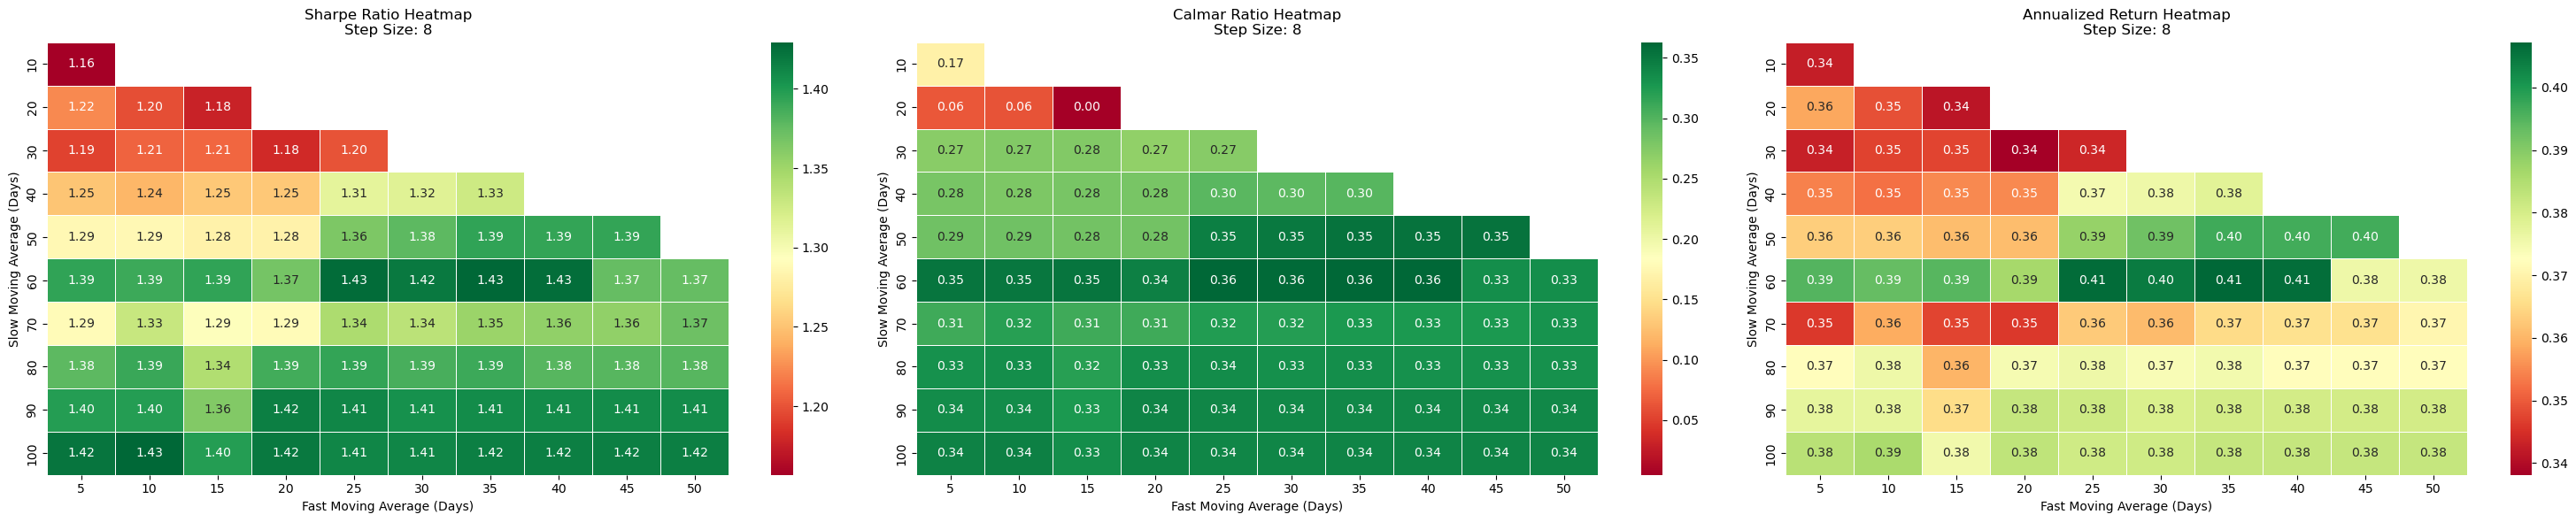

In [211]:
plot_moving_avg_crossover_performance_heatmap(df_performance_returns)

<Axes: xlabel='date'>

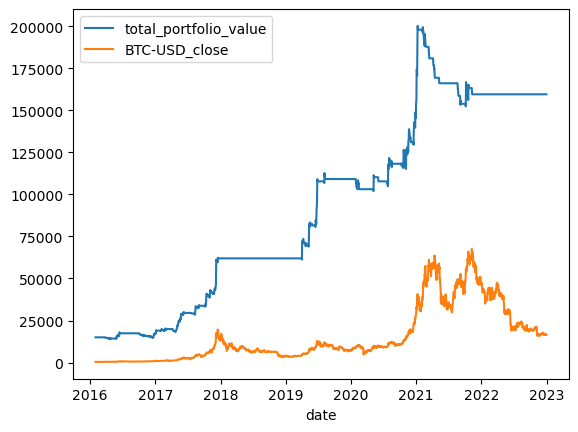

In [261]:
df[['total_portfolio_value','BTC-USD_close']].plot()

<Axes: xlabel='date'>

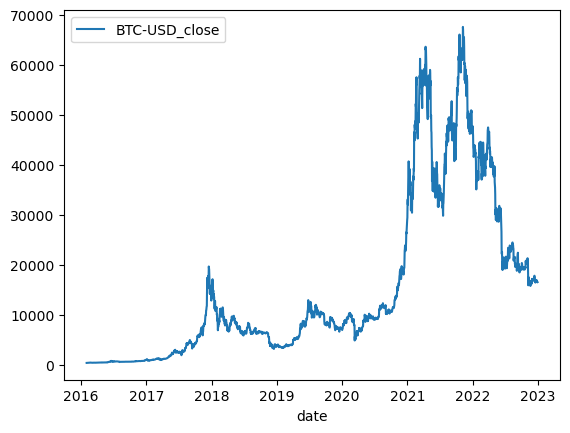

In [281]:
df[['BTC-USD_close']].plot()

In [271]:
df[(df.index > pd.Timestamp('2021-01-01').date()) & (df.index < pd.Timestamp('2021-12-31').date()) & (df['BTC-USD_event'] != 'No Event')]

BTC-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2021-01-02                                  18821.28   
2021-01-03                                  19166.65   
2021-01-04                                  19272.37   
2021-01-05                                  19444.60   
2021-01-06                                  21359.65   
2021-01-07                                  22729.40   
2021-01-08                                  22729.40   
2021-01-09                                  22729.40   
2021-01-10                                  22729.40   
2021-02-06                                  30407.13   
2021-02-07                                  30407.13   
2021-02-08                                  30407.13   
2021-02-09                                  30407.13   
2021-02-10                                  30407.13   
2021-02-11                                  30407.13   
2021-02-12                                  30407.13   
2021-02-13                                  30407.13   
2021-02-15                                  30407.13   
2021-02-16                                  30407.13   
2021-02-17                                  30407.13   
2021-02-18                                  33137.74   
2021-02-19                                  33137.74   
2021-02-20                                  33137.74   
2021-02-21                                  33137.74   
2021-02-22                                  33533.19   
2021-02-23                                  35512.67   
2021-03-12                                  45231.75   
2021-03-13                                  45231.75   
2021-03-14                                  45231.75   
2021-03-15                                  45231.75   
2021-04-06                                  51325.01   
2021-04-07                                  51325.01   
2021-04-11                                  51325.01   
2021-04-12                                  51325.01   
2021-04-13                                  51325.01   
2021-04-14                                  51325.01   
2021-04-15                                  51325.01   
2021-05-09                                  49121.00   
2021-05-10                                  49121.00   
2021-08-21                                  38191.44   
2021-08-22                                  38191.44   
2021-08-24                                  38191.44   
2021-08-25                                  39722.41   
2021-09-04                                  44671.58   
2021-09-05                                  44671.58   
2021-09-06                                  44671.58   
2021-09-07                                  44671.58   
2021-09-08                                  44707.98   
2021-10-05                                  40719.60   
2021-10-06                                  40719.60   
2021-10-07                                  40719.60   
2021-10-08                                  40719.60   
2021-10-12                                  40719.60   
2021-10-13                                  41026.07   
2021-10-16                                  41026.07   
2021-10-17                                  41026.07   
2021-10-19                                  41026.07   
2021-10-20                                  41522.16   
2021-10-21                                  43824.43   
2021-10-22                                  47657.69   
2021-11-09                                  58455.47   
2021-11-10                                  58455.47   

            BTC-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2021-01-02                                  28990.08   
2021-01-03                                  29412.84   
2021-01-04                                  32225.91   
2021-01-05                                  33080.66   
2021-01-06                                  33080.66   
2021-01-07                         